<img src="Ser-SAM.jpg" width="700" height="500" align="center"/>

# Drift-Diffusion Simulator (Version 2.4)

***

An open-source computational tool developed in support of:

#### _A New Framework for Understanding Recombination-Limited Charge Extraction in Disordered Semiconductors_


_Austin M. Kay$^{*1}$, Drew B. Riley$^{*1}$, Paul Meredith$^1$, Ardalan Armin$^{*1}$, & Oskar J. Sandberg$^{*2}$_

$^1$Sustainable Advanced Materials (Sêr SAM), Centre for Integrative Semiconductor Materials (CISM), Swansea University Bay Campus, Crymlyn Burrows, SA1 8EN, United Kingdom

$^2$Physics, Faculty of Science and Engineering, Åbo Akademi University, 20500 Turku, Finland

Email: a.m.kay.954708@swansea.ac.uk; d.b.riley@swansea.ac.uk; oskar.sandberg@abo.fi

***

<a id = 'Table_of_Contents' ></a>
## Table of Contents

1.&emsp;&emsp;[Prerequisites](#Prelims)

&emsp;&emsp;1.1.&emsp;&emsp;[Prerequisite Imports](#PrerequisiteImports)

&emsp;&emsp;1.2.&emsp;&emsp;[Sifting Through Directory Environment](#Sifting)

&emsp;&emsp;1.3.&emsp;&emsp;[Loading Spectra](#LoadingSpectra)

&emsp;&emsp;1.4.&emsp;&emsp;[Determining Photon Fluxes](#PhotonFluxes)

&emsp;&emsp;1.5.&emsp;&emsp;[Light Power and Lux Constants](#PLights)

&emsp;&emsp;1.6.&emsp;&emsp;[Time and Date](#TimeDate)

&emsp;&emsp;1.7.&emsp;&emsp;[Determine Stored Device Architectures](#Architectures)

2.&emsp;&emsp;[Theoretical Background](#Theory)

&emsp;&emsp;2.1.&emsp;&emsp;[A Description of the Diode](#Diode_Description)

&emsp;&emsp;2.2.&emsp;&emsp;[Drift-Diffusion Equations](#DD_Equations)

&emsp;&emsp;2.3.&emsp;&emsp;[Generation Rate Models](#GR_Models)

&emsp;&emsp;2.4.&emsp;&emsp;[Normalisation](#N)

&emsp;&emsp;2.5.&emsp;&emsp;[Discretisation](#D)

&emsp;&emsp;2.6.&emsp;&emsp;[Iteration and Convergence](#I)

&emsp;&emsp;2.7.&emsp;&emsp;[Incorporating Resistance-Capacitance Effects](#RC_Theory)

3.&emsp;&emsp;[Computational Support](#Comp)

&emsp;&emsp;3.1.&emsp;&emsp;[Loading Spectra](#Spectra)

&emsp;&emsp;3.2.&emsp;&emsp;[Active Layer Parameters](#AL)

&emsp;&emsp;3.3.&emsp;&emsp;[Generation Rate](#Gen_Rate)

&emsp;&emsp;3.4.&emsp;&emsp;[Energetic Landscape](#Contacts)

&emsp;&emsp;3.5.&emsp;&emsp;[Resistance-Capacitance Effects](#RC)

&emsp;&emsp;3.6.&emsp;&emsp;[Simulation Control Parameters](#Control)

&emsp;&emsp;3.7.&emsp;&emsp;[Parameter Collection](#Param_Collect)

&emsp;&emsp;3.8.&emsp;&emsp;[User Interface Compiling](#UI_Compiling)

4.&emsp;&emsp;[User Interface](#UI)

<a id = 'Prelims' ></a>
## 1. Prerequisites

[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
In this section, a few prerequisites are carried out to help the script's operation.
<br/><br/>

<a id = 'PrerequisiteImports' ></a>
### 1.1. Prerequisite Imports
[Return to Table of Contents](#Table_of_Contents)
<br/><br/> 
To begin, the libraries and tools needed by the script are imported:
<br/><br/> 

In [2767]:
from os import getcwd, mkdir, path, walk, listdir

from pandas import DataFrame, concat, ExcelFile, read_excel, read_csv

from datetime import datetime

from time import time

from numpy import arange, arcsin, arctan, array, cos, exp, inf, interp, linalg, linspace, log, log10, logspace, mean, meshgrid, pi, sin, sqrt

from ipywidgets import Accordion, BoundedFloatText, BoundedIntText, Button, Checkbox, Combobox, Dropdown, FloatText, HBox, IntText, Label, Layout, Output, RadioButtons, Tab, Text, Valid, VBox 

from itertools import chain

from scipy.constants import e, h, c, k, epsilon_0

from scipy.integrate import simps

from scipy.optimize import curve_fit 

import matplotlib as mpl

import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

<a id = 'Sifting' ></a>
### 1.2. Sifting Through Directory Environment
[Return to Table of Contents](#Table_of_Contents)
<br/><br/> 
Following this, the path to the current working folder (directory) is determined, such that it can be sifted through and the paths to its contents can be determined:
<br/><br/> 

In [2768]:
Current_Working_Directory = getcwd()

<br/><br/> 
The path to 'supporting files' folder can now be written:
<br/><br/> 

In [2769]:
Supporting_Files_Directory_Path = path.join( Current_Working_Directory , 'Supporting_Files' )

<br/><br/> 
Within this 'supporting files' folder lies all the optical constant data, photon flux spectra, etc, luminous efficiency data, etc. The filepath to the optical constants folder is determined using:
<br/><br/> 

In [2770]:
Optical_Constants_Folder_Path = path.join( Supporting_Files_Directory_Path , 'Optical_Constants' )

<br/><br/> 
Using this filepath, the files containing optical constants are identified, then these files are stored, using:
<br/><br/> 

In [2771]:
Optical_File_List = []

Optical_File_Paths = {}

Folder_Names = []

for Root, Dirs, Files in walk( Optical_Constants_Folder_Path ):
    
    Folder_Names.append( Dirs )
    
    for File in Files:
    
        Trimmed_Filename = File.replace( '.xlsx' , '' )
        
        Optical_File_List.append( Trimmed_Filename ) 
        
        Optical_File_Paths[ Trimmed_Filename ] = path.join( Root , File )

<br/><br/> 
From this list of files, the materials available for optical modelling simulations are identified by first identifying the materials with both refractive index and extinction coefficient values:
<br/><br/> 

In [2772]:
n_File_List = [ Entry.replace( '_n' , '' ) for Entry in Optical_File_List if '_n' in Entry ]

k_File_List = [ Entry.replace( '_k' , '' ) for Entry in Optical_File_List if '_k' in Entry ]

<br/><br/> 
The 'intersection' of these two lists will then give the materials available for optical modelling simulations:
<br/><br/> 

In [2773]:
Available_Materials = [ Entry for Entry in n_File_List if Entry in k_File_List ]

<br/><br/> 
While the non-intersecting entries will correspond to incomplete data (i.e., missing refractive index or extinction coefficient data):
<br/><br/> 

In [2774]:
Incomplete_Materials = [ Entry for Entry in n_File_List if Entry not in k_File_List ]

Incomplete_Materials += [ Entry for Entry in k_File_List if Entry not in n_File_List ]

<br/><br/> 
These incomplete materials are printed for the user below:
<br/><br/> 

In [2775]:
if len( Incomplete_Materials ) == 0:
    
    print( 'All optical constants present.' )
    
else:
    
    for Mat in Incomplete_Materials:
        
        if Mat not in n_File_List:
            
            print( Mat + ' refractive indices missing.' )
            
        else:
            
            print( Mat + ' extinction coefficients missing.' )

All optical constants present.


<br/><br/> 
Following the identification of which materials are available, the optical constant data is loaded using:
<br/><br/> 

In [2776]:
Refractive_Indices = {}

Extinction_Coefficients = {}

for Material in Available_Materials:
        
    Refractive_Indices[ Material ] = array( read_excel( Optical_File_Paths[ Material + '_n' ] ) )  
    
    Extinction_Coefficients[ Material ] = array( read_excel( Optical_File_Paths[ Material + '_k' ] ) )      

<br/><br/> 
The following helper function is defined for interpolating the above optical constant data (using a one-dimensional interpolation): 
<br/><br/> 

In [2777]:
def Optical_Constant_Interpolator( Wavelengths, Material ):
    
    """For a given material type, interpolate its optical constants at a given set of wavelengths."""
    
    Raw_ns = Refractive_Indices[ Material ] # first column is wavelengths, second is ns
    
    Raw_ks = Extinction_Coefficients[ Material ] # first column is wavelengths, second is ks
    
    ns = interp( Wavelengths , Raw_ns[ :, 0 ] , Raw_ns[ :, 1 ] )
    
    ks = interp( Wavelengths , Raw_ks[ :, 0 ] , Raw_ks[ :, 1 ] )
    
    return ns, ks

<br/><br/> 
Following this, the directories in the current working directory are scoped out, creat output folder if need be: 
<br/><br/> 

In [2778]:
Directories = []

for Root, Dirs, Files in walk( Current_Working_Directory ):

    Directories.append( Dirs )
    
# Ensure unique elements:
        
Directories = list( set( x for l in Directories for x in l ) )

<br/><br/> 
Creating output folder:
<br/><br/> 

In [2779]:
if 'Output' not in Directories:
    
    Output_Folder_Path = path.join( Current_Working_Directory , 'Output' )
        
    mkdir( Output_Folder_Path )

<a id = 'LoadingSpectra' ></a>
### 1.3. Loading Spectra

[Return to Table of Contents](#Table_of_Contents)
<br/><br/> 
A path to the spectra stored in the "Spectra" folder of the "Supporting_Files" directory is created using by appending the string "Spectra" to the path to that directory:
<br/><br/>

In [2780]:
Spectra_Folder_Path = path.join( Supporting_Files_Directory_Path , "Spectra" )

<br/><br/>
The content of the spectra folder is then identified using the function "listdir". This will produce a list of all the files saved in that folder, where each file is callable using its string:
<br/><br/>

In [2781]:
Spectra_Folder_Contents = listdir( Spectra_Folder_Path )

<br/><br/>
For each of the files in the list, the path needed to reach that file (which will be useful later) is now defined. These paths are stored in a Python dictionary wherein each element is stored according to a string (in this case, the file's name): 
<br/><br/>

In [2782]:
File_Path_Dictionary = { File_Name :
                       
    path.join( Spectra_Folder_Path , File_Name )
                       
    for File_Name in Spectra_Folder_Contents }

<br/><br/>
The paths to the files containing the air-mass (AM), light-emitting diode (LED), flourescent source (FL), and real spectra are determined using:
<br/><br/>

In [2783]:
AM_Spectra_Path = File_Path_Dictionary[ 'AM_Spectra.xlsx' ]

LED_Spectra_Path = File_Path_Dictionary[ 'LED_Spectra.xlsx' ]

FL_Spectra_Path = File_Path_Dictionary[ 'FL_Spectra.xlsx' ]

Position_Dep_Spectra_Path = File_Path_Dictionary[ 'Real_Position_Dep_Spectra.xlsx' ]

Time_Dep_Spectra_Path = File_Path_Dictionary[ 'Real_Time_Dep_Spectra.xlsx' ]

<br/><br/>
A Python module, Pandas, is now used to create "data frames" to store the irradiance spectra. These data frames can be used to select data from a large array using row number and/or column title. To begin with, the necessary modules are loaded:
<br/><br/>

In [2784]:
AM_Spectra = ExcelFile( AM_Spectra_Path )

LED_Spectra = ExcelFile( LED_Spectra_Path )

FL_Spectra = ExcelFile( FL_Spectra_Path )

Position_Dep_Spectra = ExcelFile( Position_Dep_Spectra_Path )

Time_Dep_Spectra = ExcelFile( Time_Dep_Spectra_Path )

<br/><br/>
Following this, the sheet names (i.e., all the spectra types saved in the file) are determined using:
<br/><br/>

In [2785]:
AM_Sheet_Names = AM_Spectra.sheet_names 

LED_Sheet_Names = LED_Spectra.sheet_names 

FL_Sheet_Names = FL_Spectra.sheet_names 

Position_Dep_Sheet_Names = Position_Dep_Spectra.sheet_names 

Time_Dep_Sheet_Names = Time_Dep_Spectra.sheet_names 

<br/><br/>
All of these available spectra are stored in a single list (for later use like, e.g., spectra superposition):
<br/><br/>

In [2786]:
AM_LED_Sheet_Names = AM_Sheet_Names + LED_Sheet_Names + FL_Sheet_Names + Position_Dep_Sheet_Names + Time_Dep_Sheet_Names

<br/><br/>
For each of the sheet names in the Excel files, the data is stored in an individual data frame - these data frames are then stored in a dictionary (where each spectrum's data is stored according to its name). The first row in each sheet is to be skipped (hence 'skiprows = 1') and each column has two headers (name and unit - 'header = [0, 1]').
<br/><br/>

In [2787]:
# Start with AM data:

Data_Frames_Dictionary = { Sheet_Name : 
                         
    AM_Spectra.parse( 
       
        Sheet_Name,
                     
        skiprows = 1, 
                     
        header = [ 0 , 1 ] ) 
                         
    for Sheet_Name in AM_Sheet_Names }

# Then store LED data (vertical bar joins two dictionaries):

Data_Frames_Dictionary = Data_Frames_Dictionary | { Sheet_Name : 
                         
    LED_Spectra.parse( 
       
        Sheet_Name,
                     
        skiprows = 1, 
                     
        header = [ 0 , 1 ] ) 
                         
    for Sheet_Name in LED_Sheet_Names }

# Then store FL data:

Data_Frames_Dictionary = Data_Frames_Dictionary | { Sheet_Name : 
                         
    FL_Spectra.parse( 
       
        Sheet_Name,
                     
        skiprows = 1, 
                     
        header = [ 0 , 1 ] ) 
                         
    for Sheet_Name in FL_Sheet_Names }

# Then store real position-dependent data:

Data_Frames_Dictionary = Data_Frames_Dictionary | { Sheet_Name : 
                         
    Position_Dep_Spectra.parse( 
       
        Sheet_Name,
                     
        skiprows = 1, 
                     
        header = [ 0 , 1 ] ) 
                         
    for Sheet_Name in Position_Dep_Sheet_Names }

# Then store real time-dependent data:

Data_Frames_Dictionary = Data_Frames_Dictionary | { Sheet_Name : 
                         
    Time_Dep_Spectra.parse( 
       
        Sheet_Name,
                     
        skiprows = 1, 
                     
        header = [ 0 , 1 ] ) 
                         
    for Sheet_Name in Time_Dep_Sheet_Names }

<br/><br/>
With the data now loaded in, it can be used. Firstly, the minimum and maximum wavelengths are determined and stored in a dictionary:
<br/><br/>

In [2788]:
Minimum_Spectra_Wavelengths = { Sheet_Name :
                              
    min( Data_Frames_Dictionary[ Sheet_Name ].loc[ : ,  'Wavelength' ].values )
                              
    for Sheet_Name in AM_LED_Sheet_Names }

Maximum_Spectra_Wavelengths = { Sheet_Name :
                              
    max( Data_Frames_Dictionary[ Sheet_Name ].loc[ : ,  'Wavelength' ].values )
                              
    for Sheet_Name in AM_LED_Sheet_Names }

<br/><br/>
In the final part of this section, the irradiance spectra are plotted, starting with the standard air-mass spectra:
<br/><br/>

In [2789]:
import matplotlib.pyplot as plt

# plt.figure( dpi = 200 )       # Un-hash and increase dpi for better quality

#for Sheet_Name in AM_Sheet_Names:     # Un-hash as necessary to plot a particular suite 
    
#for Sheet_Name in LED_Sheet_Names:
    
#for Sheet_Name in FL_Sheet_Names:
    
#for Sheet_Name in Position_Dep_Sheet_Names:

#for Sheet_Name in Time_Dep_Sheet_Names:

#    Data = Data_Frames_Dictionary[ Sheet_Name ]
    
#    xs = Data.loc[ : ,  'Wavelength' ].values
    
#    ys = Data.loc[ : ,  'Intensity per wavelength' ].values

#    ys = array( [ abs( y[ 0 ] ) for y in ys ] )
        
#    plt.plot( xs, ys / max( ys ), label = Sheet_Name )
    
#plt.legend()

#plt.ylabel( 'Norm. Irradiance' )

#plt.xlabel( 'Wavelength, $\lambda$ (nm)' )

#plt.xlim( [ 0 , 2000 ] )

#plt.show()

<a id = 'PhotonFluxes' ></a>
### 1.4. Determining Photon Fluxes

[Return to Table of Contents](#Table_of_Contents)
<br/><br/> 
To determine the photon flux corresponding to a particular irradiance value, the following function is defined to determine the photon energy at a given wavelength:

In [2790]:
def Energy_Wavelength_Converter( Energy_or_Wavelength ):
    
    """Convert from photon energy to wavelength or vice versa"""
    
    return h * c / ( e * Energy_or_Wavelength * 1e-9 )

<br/><br/>
Following this, for each sheet of the Excel files, the photon fluxes and irradiances are determined, then stored in a dictionary which will be used by the script to determine figures-of-merit.
<br/><br/>

In [2791]:
Photon_Irradiance_Spectra = {}

Photon_Flux_Spectra = {}

for Sheet_Name in AM_LED_Sheet_Names:
    
    Wavelengths = [ Value[ 0 ] for Value in Data_Frames_Dictionary[ Sheet_Name ].loc[ : ,  'Wavelength' ].values ]
    
    Irradiances = [ Value[ 0 ] for Value in Data_Frames_Dictionary[ Sheet_Name ].loc[ : ,  'Intensity per wavelength' ].values ]
    
    Fluxes = [ 0.1 * Irradiances[ i ] / e / Energy_Wavelength_Converter( Wavelengths[ i ] ) for i in range( len( Wavelengths ) ) ]
          
    Photon_Irradiance_Spectra[ Sheet_Name ] = array( [ Wavelengths , Irradiances ] )
    
    Photon_Flux_Spectra[ Sheet_Name ] = array( [ Wavelengths , Fluxes ] )

<br/><br/>
These photon flux spectra are then plotted below:
<br/><br/>

In [2792]:
#import matplotlib.pyplot as plt

# plt.figure( dpi = 200 )      # Un-hash and increase dpi for better quality

#for Sheet_Name in AM_Sheet_Names:     # Un-hash as necessary to plot a particular suite 
    
#for Sheet_Name in LED_Sheet_Names:
    
#for Sheet_Name in FL_Sheet_Names:
    
#for Sheet_Name in Position_Dep_Sheet_Names:

#for Sheet_Name in Time_Dep_Sheet_Names:
        
#    plt.plot( Photon_Flux_Spectra[ Sheet_Name ][ 0 , : ], Photon_Flux_Spectra[ Sheet_Name ][ 1 , : ] , label = Sheet_Name )
    
#plt.legend()

#plt.ylabel( 'Photon Flux (# $10^{-3}$Photons/cm2/s/nm)' )

#plt.xlabel( 'Wavelength, $\lambda$ (nm)' )

#plt.xlim( [ max( Minimum_Spectra_Wavelengths.values() ) , min( Maximum_Spectra_Wavelengths.values() ) ] )

#plt.show()

<a id = 'PLights' ></a>
### 1.5. Light Power and Lux Constants

[Return to Table of Contents](#Table_of_Contents)
<br/><br/> 

The powers densities associated with these spectra are determined using $$\tag{1.1}
P_\mathrm{light}=\int_0^\infty E\it{\Phi}_\mathrm{source}(E)\,\mathrm{d}E.
$$
where all the imported irradiance spectra have units of $\mathrm{W}\cdot\mathrm{m}^{-2}\cdot\mathrm{nm}^{-1}$. Integrating these irradiance spectra therefore gives a total incident power in units of $\mathrm{W}\cdot\mathrm{m}^{-2}$ and so, an addional scale factor of $10^{-1}$ is included to convert to units of $\mathrm{mW}\cdot\mathrm{cm}^{-2}$ in the following calculations:
<br/><br/>

In [2793]:
def Light_Power( Wavelengths , Irradiances ):
    
    """Determine the total light power of an irradiance spectrum."""
    
    return simps( Irradiances , x = Wavelengths )


P_lights = { Sheet_Name : 
            
    Light_Power( Photon_Irradiance_Spectra[ Sheet_Name ][ 0 ] , Photon_Irradiance_Spectra[ Sheet_Name ][ 1 ] ) / 10 
    
    for Sheet_Name in AM_LED_Sheet_Names }

<br/><br/>
Each of the photon flux spectra is then normalised to its power density and stored in a dictionary using:
<br/><br/>

In [2794]:
Normalised_Photon_Flux_Spectra = {}

for Sheet_Name in AM_LED_Sheet_Names:
    
    Wavelengths , Fluxes = Photon_Flux_Spectra[ Sheet_Name ]
    
    Normalised_Photon_Flux_Spectra[ Sheet_Name ] = array( [ Wavelengths , Fluxes / P_lights[ Sheet_Name ] ] )

<br/><br/>
Following this, the luminous efficiency data needed to determine the lux constants is loaded in using the following code:
<br/><br/>

In [2795]:
Luminous_Efficiency_File_Name = 'Luminous_Efficiency_Data.xlsx'

Luminous_Efficiency_File_Path = path.join( Supporting_Files_Directory_Path, Luminous_Efficiency_File_Name )

Luminous_Efficiency_Data = ExcelFile( 
    
    path.join( 
        
        Current_Working_Directory, 
        
        Luminous_Efficiency_File_Path ) )

<br/><br/>
This file contains luminous efficiency spectra for each of the three light cones that form the human eye: L - long wavelengths (red), M - medium wavelengths (green), and S - short wavelengths (blue). The required spectra (inferred from the sheet names) are given user-friendly names using the following dictionary:
<br/><br/>



In [2796]:
V_Names = { '2_Deg_V' : 'V 2-deg',
           
           '10_Deg_V' : 'V 10-deg' }

<br/><br/>
The spectra are then parsed into individual dictionaries using: 
<br/><br/>

In [2797]:
Luminous_Efficiency_Dictionary = { V_Names[ Sheet_Name ] : 
                         
    Luminous_Efficiency_Data.parse( 
       
        Sheet_Name ) 
                         
    for Sheet_Name in Luminous_Efficiency_Data.sheet_names }

<br/><br/>
For each of these data frames, invalid numbers are removed using:
<br/><br/>

In [2798]:
for Key in list( Luminous_Efficiency_Dictionary.keys() ):
    
    Luminous_Efficiency_Dictionary[ Key ] = Luminous_Efficiency_Dictionary[ Key ].dropna()

<br/><br/>
These luminous efficiency spectra are then plotted as a function of photon energy using:
<br/><br/>

In [2799]:
# plt.figure( dpi = 200 )      # Un-hash to increase dpi for better quality

#for Key in list( Luminous_Efficiency_Dictionary.keys() ):
    
#    Data = Luminous_Efficiency_Dictionary[ Key ]
    
#    plt.plot( h * c / ( e*  1e-9 * Data[ Data.columns[ 0 ] ] ) , Data[ Data.columns[ 1 ] ] , label = Key )
    
#plt.legend()
#plt.yscale( 'log' );
#plt.ylabel( 'Luminous Efficiency, $V$' );
#plt.xlabel( 'Photon Energy, $E$ (eV)');

<br/><br/>
Each of these dictionaries contains a finite amount of data - extrapolation will be needed to estimate the luminous efficiency outside the data set. This extrapolation is modelled as a Gaussian with respect to the photon energy $E$ of the form:
<br/><br/>
<a id="Gaussian"></a>
$$\tag{1.2}
V(E)= e^{a_0E^2+b_0E+c_0}\propto e^{[A-BE]^2}.
$$
<br/><br/>
All parameters are boundless bar the coefficient of the quadratic term, $a_0$, which is forced to be negative such that the natural logarithm of the luminous efficiency is an inverse parabola. The parameter $c_0$ will relate to the amplitude the Gaussian will take at $E=0$. In terms of the photon wavelength, this model takes the form
<br/><br/>
<a id="Gaussian"></a>
$$\tag{1.3}
V(E)= \exp\left(\frac{a_0h^2c^2}{\lambda^2}+\frac{b_0hc}{\lambda}+c_0\right),
$$
<br/><br/>
where $a_0h^2c^2$ must have units of length-squared, $b_0hc$ must have units of length, and $c_0$ must be unitless.
<br/><br/>
&emsp;&emsp;&emsp;&emsp; To perform the curve fitting, the following function is defined to fit the natural logarithm of the luminous efficiciency data:
<br/><br/>

In [2800]:
def Quadratic( x , a_0 , b_0 , c_0 ):
    
    """A model for a quadratic line with coefficients a_0, b_0, and c_0."""
    
    return a_0 * x ** 2 + b_0 * x + c_0 

<br/><br/>
The User can change the number of data points that should be fit with the model below:
<br/><br/>

In [2801]:
Number_of_Data_Points_to_Fit = 30

<br/><br/>
The parameters used in these Gaussian fittings are to be stored in the following dictionary:
<br/><br/>

In [2802]:
Gaussian_Fit_Parameter_Dictionary = {}

<br/><br/>
Using the first and last data points (default thirty - user can modify), the natural logarithm of the luminous efficiency spectra are fit with the above model using the following function:
<br/><br/>

In [2803]:
def Luminous_Efficiency_Extrapolater( Number_of_Data_Points_to_Fit , Wavelengths , Luminous_Efficiencies ):
    
    """For a given data set, extraploate the first and last portion of the luminous efficiencies using the wavelengths. The
    
    wavelengths should be in units of nm and ascending."""
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Prerequisite Data Sorting
    #-----------------------------------------------------------------------------------------------------------------------
    
    Energies = h * c / ( e * 1e-9 * Wavelengths )
    
    Energies_Flipped = Energies[ ::-1 ] # Flip the array so thei
    
    ln_Luminous_Efficiencies = log( Luminous_Efficiencies )
    
    ln_Luminous_Efficiencies_Flipped = ln_Luminous_Efficiencies[ ::-1 ]
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Fit First Tail
    #-----------------------------------------------------------------------------------------------------------------------
    
    Optimal_Parameters_1 , Optimal_Parameter_Errors_1 = curve_fit( 
    
        Quadratic, 
    
        Energies_Flipped[ :Number_of_Data_Points_to_Fit ],
    
        ln_Luminous_Efficiencies_Flipped[ :Number_of_Data_Points_to_Fit ],
        
        bounds = ( ( -inf ,  -inf , -inf ) , ( 0 , inf , inf ) ) )
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Fit Second Tail
    #-----------------------------------------------------------------------------------------------------------------------
    
    Optimal_Parameters_2 , Optimal_Parameter_Errors_2 = curve_fit( 
    
        Quadratic, 
    
        Energies_Flipped[ -Number_of_Data_Points_to_Fit: ],
    
        ln_Luminous_Efficiencies_Flipped[ -Number_of_Data_Points_to_Fit: ],
    
        bounds = ( ( -inf ,  -inf , -inf ) , ( 0 , inf , inf ) ) )
    
    Scale_Factors = [ ( h * c / ( e * 1e-9 ) ) ** 2 , ( h * c / ( e * 1e-9 ) ) , 1 ]
    
    return Scale_Factors * Optimal_Parameters_1 , Scale_Factors * Optimal_Parameters_2

<br/><br/>
For each of the available spectra, the tails are now extrapolated and plotted using: <br/><br/>
<br/><br/>

In [2804]:
Colours = [ 'k' , 'r' , 'g' , 'b' , 'c' , 'm' , 'y' ]

# plt.figure( dpi = 200 )    # Un-hash and increase dpi for better quality

for Key in list( Luminous_Efficiency_Dictionary.keys() ):
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Specify Curve Colour
    #-----------------------------------------------------------------------------------------------------------------------
    
    Index = list( Luminous_Efficiency_Dictionary.keys() ).index( Key )

    Curve_Colour = Colours[ Index % 7 ]
        
    #-----------------------------------------------------------------------------------------------------------------------
    # Load Data
    #-----------------------------------------------------------------------------------------------------------------------
    
    Data = Luminous_Efficiency_Dictionary[ Key ]
    
    Wavelength_Data = Data[ Data.columns[ 0 ] ]
    
    Luminous_Efficiency_Data = Data[ Data.columns[ 1 ] ]
    
    Lower_Plotting_Wavelengths = linspace( 300 , min( Wavelength_Data ) , 101 )

    Upper_Plotting_Wavelengths = linspace( max( Wavelength_Data ) , 1200 , 201 )

    #-----------------------------------------------------------------------------------------------------------------------
    # Determine Extrapolation Parameters and Store Them
    #-----------------------------------------------------------------------------------------------------------------------
        
    Optimal_Parameters_1 , Optimal_Parameters_2 = Luminous_Efficiency_Extrapolater( 
        
        Number_of_Data_Points_to_Fit,
        
        Wavelength_Data, 
        
        Luminous_Efficiency_Data )
    
    Gaussian_Fit_Parameter_Dictionary[ Key ] = [ Optimal_Parameters_1 , Optimal_Parameters_2 ]
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Plot and Simulate
    #-----------------------------------------------------------------------------------------------------------------------
    
  #  plt.plot( Lower_Plotting_Wavelengths , exp( 
        
   #     Quadratic( 
            
    #        1 / Lower_Plotting_Wavelengths, 
           
      #      * Optimal_Parameters_2 ) ),
            
     #   Curve_Colour )
    
    #plt.plot( Upper_Plotting_Wavelengths , exp( 
        
     #   Quadratic( 
            
      #      1 / Upper_Plotting_Wavelengths, 
            
       #     *Optimal_Parameters_1 ) ) , 
             
     #   Curve_Colour, 
             
      #  label = Key )
    
  #  plt.plot( Wavelength_Data , Luminous_Efficiency_Data , '--' , color = Curve_Colour  )

#plt.yscale( 'log' )

#plt.xlabel( 'Photon Wavelength, $\lambda$ (nm)')

#plt.ylabel( 'Luminous Efficiency, $V$')

#plt.legend()

#plt.show()

<br/><br/>
In the above plot, the dashed lines indicate the imported data, whereas the solid lines are the extrapolated tails. Using these extrapolations, a function is now defined for determining the luminous efficiency at any wavelength:
<br/><br/>

In [2805]:
def Extrapolated_Luminous_Efficiency( Luminous_Efficiency_Type , Wavelength ):
    
    """For a given luminous efficiency extrapolate (or interpolate) the sepctrum to determine its value at a particular 
    
    wavelength."""
    
    LE_Data = Luminous_Efficiency_Dictionary[ Luminous_Efficiency_Type ]
    
    if Wavelength < min( list( LE_Data[ LE_Data.columns[ 0 ] ] ) ):
                                             
        return exp( Quadratic( 1 / Wavelength , *Gaussian_Fit_Parameter_Dictionary[ Luminous_Efficiency_Type ][ 1 ] ) )
                                             
    if Wavelength > max( list( LE_Data[ LE_Data.columns[ 0 ] ] ) ):
                                             
        return exp( Quadratic( 1 / Wavelength , *Gaussian_Fit_Parameter_Dictionary[ Luminous_Efficiency_Type ][ 0 ] ) )
    
    else:
        
        return interp( Wavelength , LE_Data[ LE_Data.columns[ 0 ] ], LE_Data[ LE_Data.columns[ 1 ] ] )

<br/><br/>
Using this, the constants of proportionality (for determining lux values) and the lux values themselves can be deduced for each of the initial input spectra. However, values determined for spectra in previous simulations and stored in the "Spectra" folder (in both "Constants_of_Proportionality.txt" and "Lux_Values.txt") are not determined again as this process becomes time consuming for when considering dozens of spectra. __If any of the spectra have been altered, the file containing the constants of proportionality should be emptied.__ The following code is used to load in the constants of proportionality and determine which spectra have been considered previously:
<br/><br/>

In [2806]:
Constants_of_Proportionality = {}

Lux_Values = {}

with open( File_Path_Dictionary[ "Constants_of_Proportionality.txt" ] ) as File:
    
    for Line in File:
        
        Line = Line.replace( '\n', '' )
        
        ( Key, Constant_2_deg, Constant_10_deg ) = Line.split( ', ' )
        
        Constants_of_Proportionality[ Key ] = { 'V 2-deg': float( Constant_2_deg ), 'V 10-deg': float( Constant_10_deg ) }
        
with open( File_Path_Dictionary[ "Lux_Values.txt" ] ) as File:
    
    for Line in File:
        
        Line = Line.replace( '\n', '' )
        
        ( Key, Lux_2_deg, Lux_10_deg ) = Line.split( ', ' ) 
        
        Lux_Values[ Key ] = { 'V 2-deg': float( Lux_2_deg ), 'V 10-deg': float( Lux_10_deg ) }       

<br/><br/>
The systems that have not previously been treated are identified using:
<br/><br/>

In [2807]:
Spectra_to_Analyse_Constants = [ Spectra for Spectra in AM_LED_Sheet_Names 
                                
                                if Spectra not in Constants_of_Proportionality.keys() ]

Spectra_to_Analyse_Lux = [ Spectra for Spectra in AM_LED_Sheet_Names 
                          
                                if Spectra not in Lux_Values.keys() ]

Spectra_to_Analyse = list( set( Spectra_to_Analyse_Lux + Spectra_to_Analyse_Constants ) )

<br/><br/>
For these systems, the lux values and constants of proportionality are computed using (see Sze, _Physics of Semiconductor Devices_)
<br/><br/>
<a id="L_light"></a>
$$\tag{1.4}
L_\mathrm{source}=L_0\int_0^\infty V(E)I_\mathrm{source}(E)\,\mathrm{d}E,
$$
<br/><br/>
where $V(E)$ is the luminous efficiency at a given photon energy and $L_0 = 683\,\mathrm{lm}\cdot\mathrm{W}^{-1}$ is a constant; here $\mathrm{lm}$ is the lumen, the unit of luminous flux. By normalising an irradiance spectrum to its total power $P_\mathrm{light}$ as defined in Equation ([15](#P_light)), then a spectrum's value in lux can be related to its value in power per unit aread via
<br/><br/>
<a id="Lux"></a>
$$\tag{1.5}
L_\mathrm{source}=\mathcal{K}P_\mathrm{source},
$$
<br/><br/>
Functions for computing these quantities are defined as:
<br/><br/>

In [2808]:
def Lux_Constant( Wavelengths , Irradiances , Luminous_Efficiencies ):
    
    """For a given irradiance spectrum, compute the constant of proportionality using the luminous efficiencies (which 
    
    are assumed to be at the same wavelengths). All quantities should be stored in arrays, such that their products may be
    
    readily computed. The Irradiances are expected to be normalised to the total irradiance. """
    
    return 683 * simps( y = Luminous_Efficiencies * Irradiances , x = Wavelengths )
    
def Lux_Value( Constant_of_Proportionality , Total_Irradiance_Value ):
    
    """Determine a spectrum's lux using the constant of proportionality for a given spectrum, and its total irradiance."""
    
    return Constant_of_Proportionality * Total_Irradiance_Value

<br/><br/>
The systems that have not already been analysed are done so, then stored, using:
<br/><br/>

In [2809]:
for Key in Spectra_to_Analyse:
    
    Wavelengths = Photon_Irradiance_Spectra[ Key ][ 0 ]
    
    Constants_of_Proportionality_i = {}
    
    Lux_Values_i = {}
    
    for Luminous_Efficiency_Type in list( Luminous_Efficiency_Dictionary.keys() ):
    
        Constants_of_Proportionality_i[ Luminous_Efficiency_Type ] = Lux_Constant(
            
            Wavelengths, 
                     
            Photon_Irradiance_Spectra[ Key ][ 1 ] / ( P_lights[ Key ] * 10 ), 
                     
            [ Extrapolated_Luminous_Efficiency( 
                         
                Luminous_Efficiency_Type, 
                         
                Wavelength ) for Wavelength in Wavelengths ] )     
             
        Lux_Values_i[ Luminous_Efficiency_Type ] = Lux_Value( 
            
            Constants_of_Proportionality_i[ Luminous_Efficiency_Type ], 
            
            P_lights[ Key ] * 10  ) # Multiplied by 10 to get W/m2
        
    Constants_of_Proportionality[ Key ] = Constants_of_Proportionality_i
    
    Lux_Values[ Key ] = Lux_Values_i

<br/><br/>
Following this, the files containing these parameters are emptied, and the (potentially) updated data is saved using:
<br/><br/>

In [2810]:
open( File_Path_Dictionary[ "Constants_of_Proportionality.txt" ] , 'w' ).close()

open( File_Path_Dictionary[ "Lux_Values.txt" ] , 'w' ).close()

Constants_to_Output = [ Sheet + ', ' + 
                        
                        str( Constants_of_Proportionality[ Sheet ][ 'V 2-deg' ] ) + ', ' + 
                        
                        str( Constants_of_Proportionality[ Sheet ][ 'V 10-deg' ] ) for Sheet in AM_LED_Sheet_Names ]

Lux_Values_to_Output = [ Sheet + ', ' + 
                        
                        str( Lux_Values[ Sheet ][ 'V 2-deg' ] ) + ', ' + 
                        
                        str( Lux_Values[ Sheet ][ 'V 10-deg' ] ) for Sheet in AM_LED_Sheet_Names ]

with open( File_Path_Dictionary[ "Constants_of_Proportionality.txt" ] , 'a' ) as File:
    
    for Entry in Constants_to_Output:
        
        File.write( Entry + '\n' )

    File.close()
    
with open( File_Path_Dictionary[ "Lux_Values.txt" ] , 'a' ) as File:
    
    for Entry in Lux_Values_to_Output:
        
        File.write( Entry + '\n' )

    File.close()

<a id = 'TimeDate' ></a>
### 1.6. Time and Date

[Return to Table of Contents](#Table_of_Contents)
<br/><br/> 

In [2811]:
# datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

Date = datetime.now().strftime("%Y_%m_%d")

Time = datetime.now().strftime("%H_%M_%S")

Date, Time

('2024_02_01', '14_12_00')

<a id = 'Architectures' ></a>
### 1.7. Determine Stored Device Architectures
[Return to Table of Contents](#Table_of_Contents)
<br/><br/> 
Write the filepath to the device architecture folder:
<br/><br/> 

In [2812]:
Device_Architecture_Folder_Path = path.join( Supporting_Files_Directory_Path, "Device_Architectures" )

<br/><br/> 
Determine contents:
<br/><br/> 


In [2813]:
Architectures = listdir( Device_Architecture_Folder_Path )

Architectures = [ Architecture for Architecture in Architectures if '.json' in Architecture ]

<br/><br/> 
If current architecture available, load it:
<br/><br/> 


In [2814]:
import json

Current_Architecture_Available = False
    
if "Current.json" in Architectures:
    
    Current_Architecture_Available = True
    
    with open( path.join( Device_Architecture_Folder_Path, "Current.json" ), 'r' ) as File:
        
        Current_Architecture = json.load( File )

Determine the remaining Architectures:

In [2815]:
Architectures = [ Architecture for Architecture in Architectures if Architecture != "Current.json" ]

<a id = 'Theory' ></a>
## 2. Theoretical Background

[Return to Table of Contents](#Table_of_Contents)


In the following section, the theoretical background behind the drift-diffusion simulations is outlined, starting with a description of the diode in __Section [2.1.](#Diode_Description)__, followed by a summary of the equations describing drift and diffusion of charge carriers in semiconductors in __Section [2.2.](#DD_Equations)__, and concluded with a discussion on optical modelling in Section __[2.3.](#Optical_Modelling)__.

<a id = 'Diode_Description' ></a>
### 2.1. A Description of the Diode
[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
The diode modelled by these simulations is assumed to have the energetic structure plotted in __Figure 1__. In this figure, the energies of a semiconductor's conduction band $E_{\mathrm{c}}$ and valence band $E_{\mathrm{v}}$ are given relative to the vacuum level $E_{\mathrm{vac}}$. They are defined as $E_{\mathrm{c}}(x,t) =E_{\mathrm{vac}}(x,t)- \chi_{\mathrm{aff}}$ and $E_{\mathrm{v}} =E_{\mathrm{vac}}-\chi_{\mathrm{IP}}$, respectively, where $\chi_{\mathrm{aff}}$ is the electron affinity of the semiconductor (the energy liberate an electron from the bottom of the conduction band to continuum) and $\chi_{\mathrm{IP}}$ is the semiconductors ionisation potential (the energy needed to liberate an electron from the valence band to continuum). The difference between the conduction band and valence band energies is the energy bandgap,
<br/><br/>
<a id = 'energy_gap' ></a>
$$\tag{2.1.1}
E_{\mathrm{g}} = E_{\mathrm{c}} - E_{\mathrm{v}}.
$$
<br/><br/>
On the other hand, the work functions of the anode and the cathode that the semiconductor is sandwiched between are $\Phi_{\mathrm{an}}=E_{\mathrm{vac}}-E_{\mathrm{F,an}}$ and $\Phi_{\mathrm{cat}}=E_{\mathrm{vac}}-E_{\mathrm{F,cat}}$, respectively. Here, $E_{\mathrm{F,an}}$ and $E_{\mathrm{F,cat}}$ are the Fermi level/chemical potential of the anode and cathode, respectively.
<br/><br/>
<br/><br/>

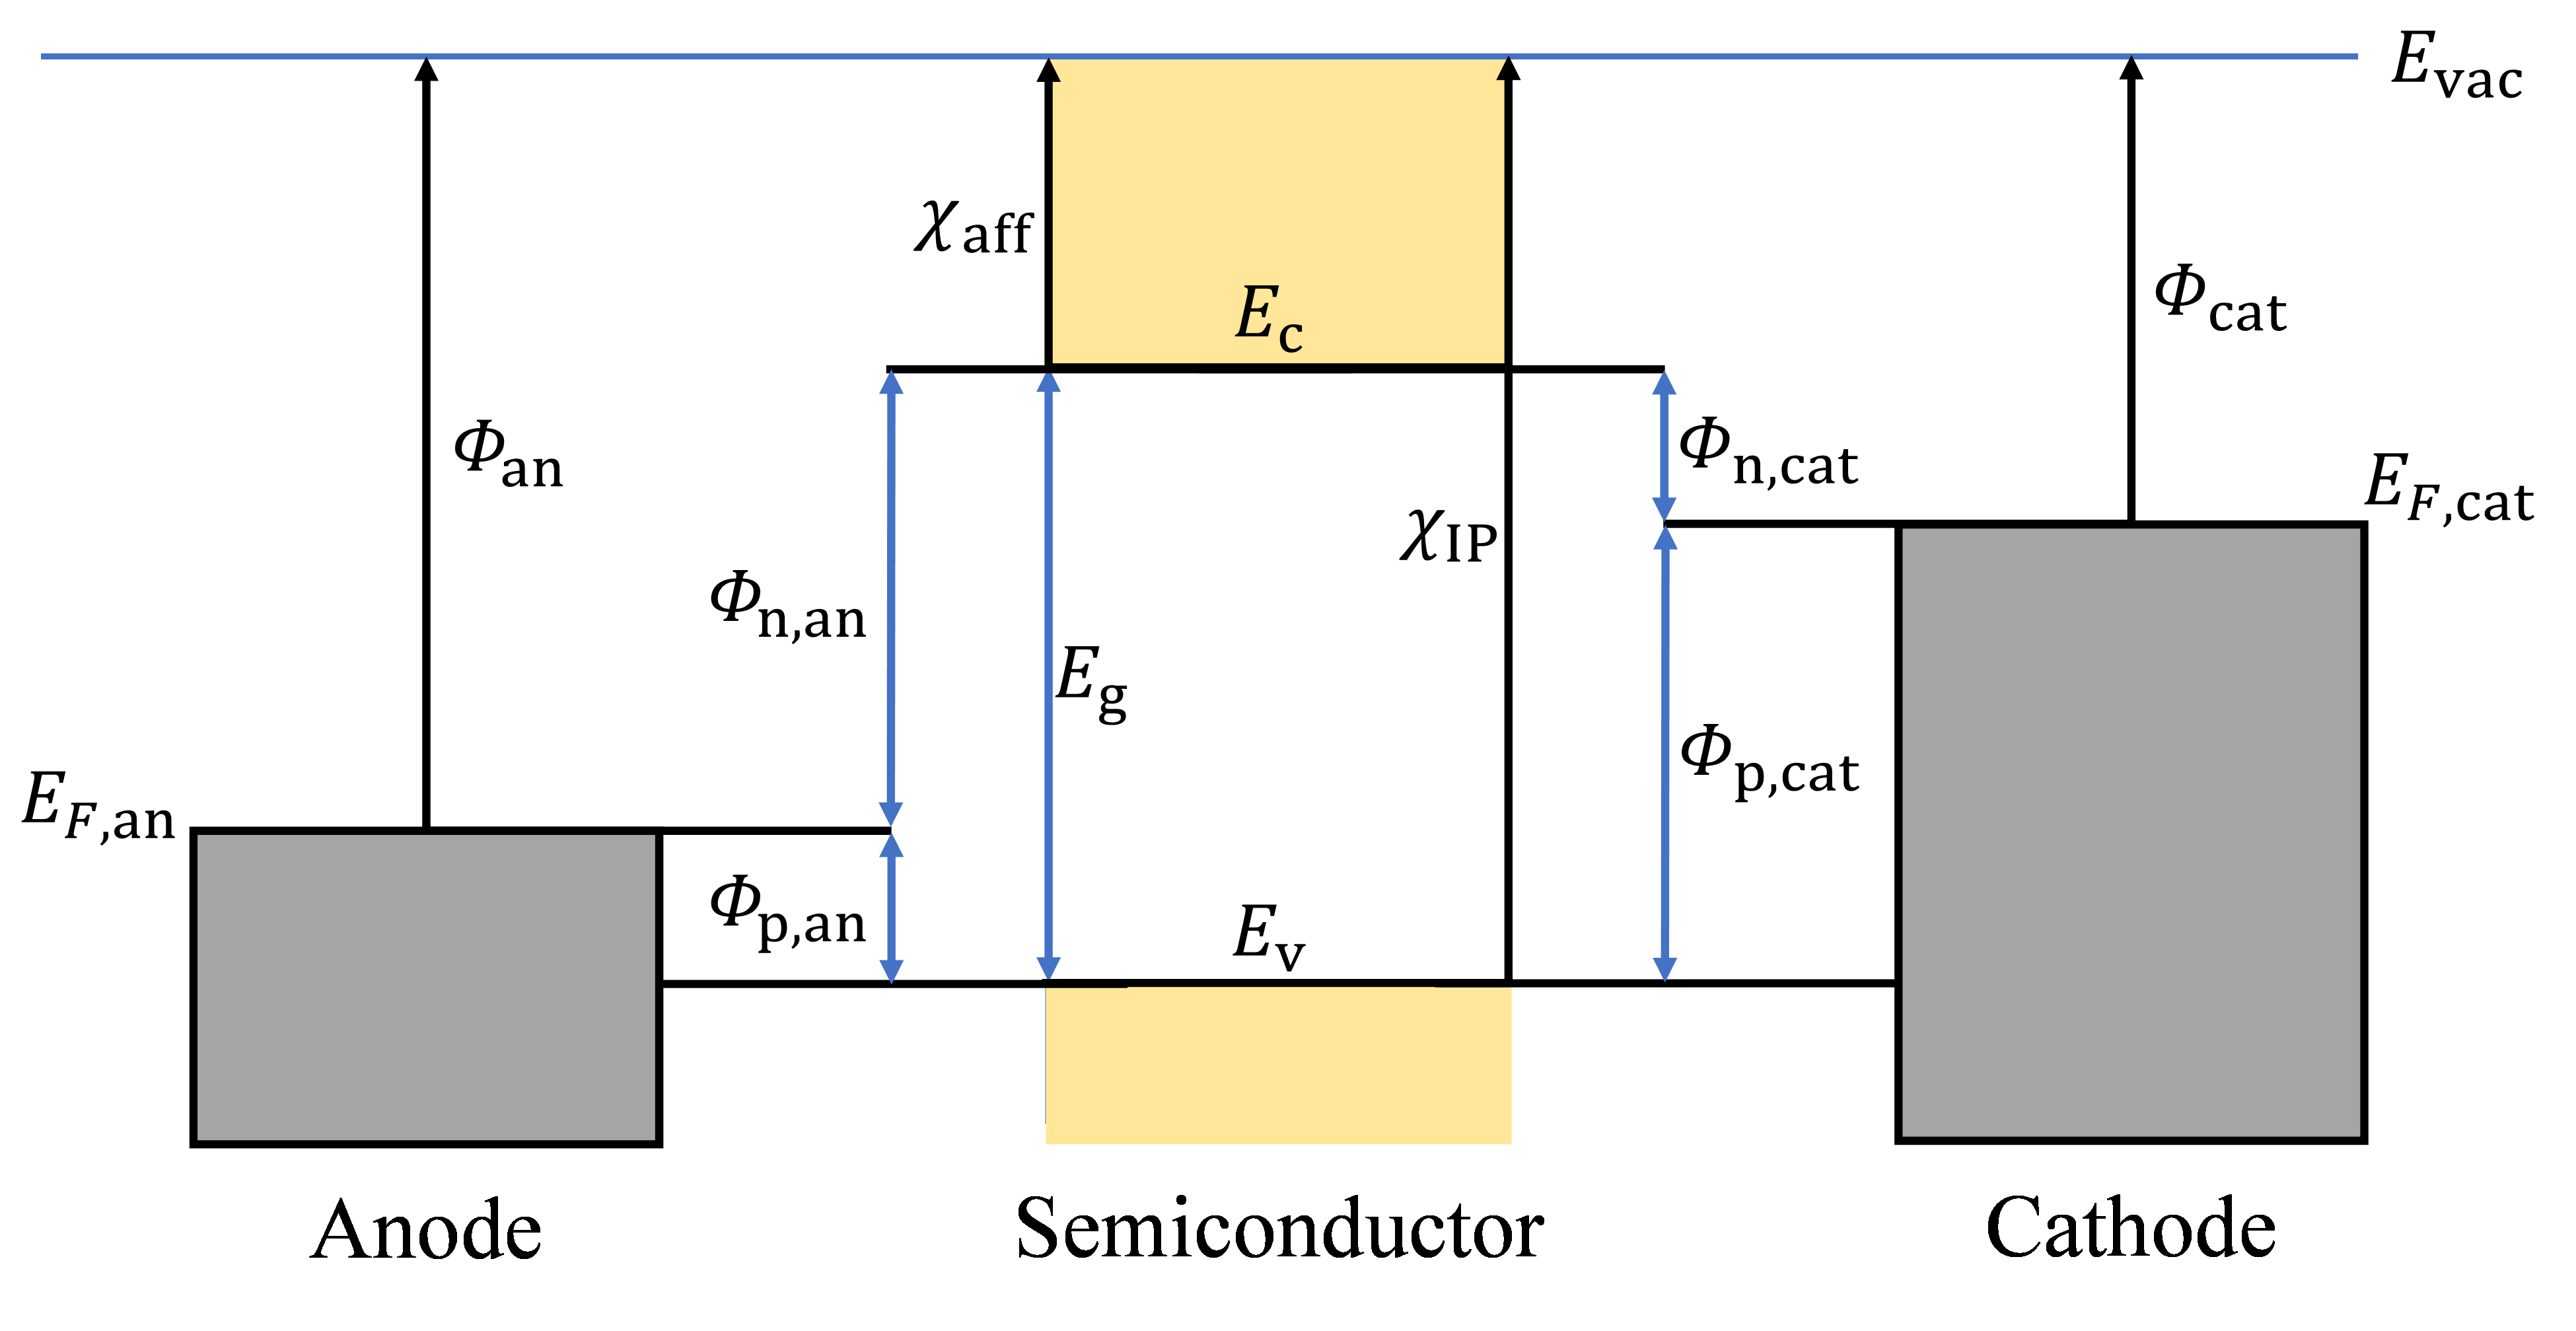

__Figure 1__: The energetic structure of a semiconductor, an anode and a cathode relative to the vacuum energy $E_{\mathrm{vac}}$.

<br/><br/>
&emsp;&emsp;&emsp;&emsp; At the anode-semiconductor contact, electrons are characterised by an injection barrier 
<br/><br/>
<a id = 'e_barrier_an' ></a>
$$
\label{eq:e_barrier_an}\tag{2.1.2}
\Phi_{\mathrm{n,an}}=\Phi_{\mathrm{an}}-\chi_{\mathrm{aff}},
$$
<br/><br/>
and holes are characterised by an injection barrier 
<br/><br/>
<a id = 'h_barrier_an' ></a>
$$
\label{eq:h_barrier_an}\tag{2.1.3}
\Phi_{\mathrm{p,an}}=\chi_{\mathrm{IP}}-\Phi_{\mathrm{an}}.
$$
<br/><br/>
Together, these barriers satisfy $\Phi_{\mathrm{n,an}} + \Phi_{\mathrm{p,an}} = E_{\mathrm{g}}$. On the other hand, at the the semiconductor-cathode contact, electrons are characterised by an injection barrier 
<br/><br/>
<a id = 'e_barrier_cat' ></a>
$$
\label{eq:e_barrier_cat}\tag{2.1.4}
\Phi_{\mathrm{n,cat}}=\Phi_{\mathrm{cat}}-\chi_{\mathrm{aff}},
$$ 
<br/><br/>
and holes are characterised by an injection barrier 
<br/><br/>
<a id = 'h_barrier_cat' ></a>
$$
\label{eq:h_barrier_cat}\tag{2.1.5}
\Phi_{\mathrm{p,cat}}=\chi_{\mathrm{IP}}-\Phi_{\mathrm{cat}}.
$$  
<br/><br/>
These injection barriers satisfy a similar condition $\Phi_{\mathrm{n,cat}} + \Phi_{\mathrm{p,cat}} = E_{\mathrm{g}}$. Using the conditions satisfied by the boundary conditions, the following functions are defined:
<br/><br/>

In [2816]:
def Phi_n_anode( E_gap , Phi_p_anode ):
    
    """Determine the hole injection barrier at the cathode for known electron injection barrier and energy bandgap."""
    
    return E_gap - Phi_p_anode

def Phi_p_cathode( E_gap , Phi_n_cathode ):
    
    """Determine the hole injection barrier at the cathode for known electron injection barrier and energy bandgap."""
    
    return E_gap - Phi_n_cathode

<a id = 'Diode_Potential' ></a>
#### 2.1.1. Origin of the Potential Across the Diode
[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
When the semiconductor and the electrodes are brought into contact, the excess of electrons in the cathode leads to their diffusion across the contact and into the semiconductor. An analogous process happens with holes at the anode-semiconductor interface. These diffusive processes leave charged ions in the vicinity of the contacts that give rise to an electric field across the semiconductor, ultimately resulting in an charge carrier drift. As shown in __Figure 2__, when thermal equilibrium, a balance between the drift and diffusive motions, is eventually reached, the Fermi levels of all the diode's constituents are equal. Instead, the vacuum level varies across the diode via
<br/><br/>
<a id = 'vacuum' ></a>
$$\tag{2.1.6}
E_{\mathrm{vac}}(\vec{r},t)=-q\left(\psi_0+\psi(\vec{r},t)\right),
$$
<br/><br/>
where $q$ if the fundamental electronic charge, $\psi_0$ is a constant potential across the diode, and $\psi(\vec{r},t)$ is the scalar electric potential at position $\vec{r}$ and time $t$ within the diode.
<br/><br/>

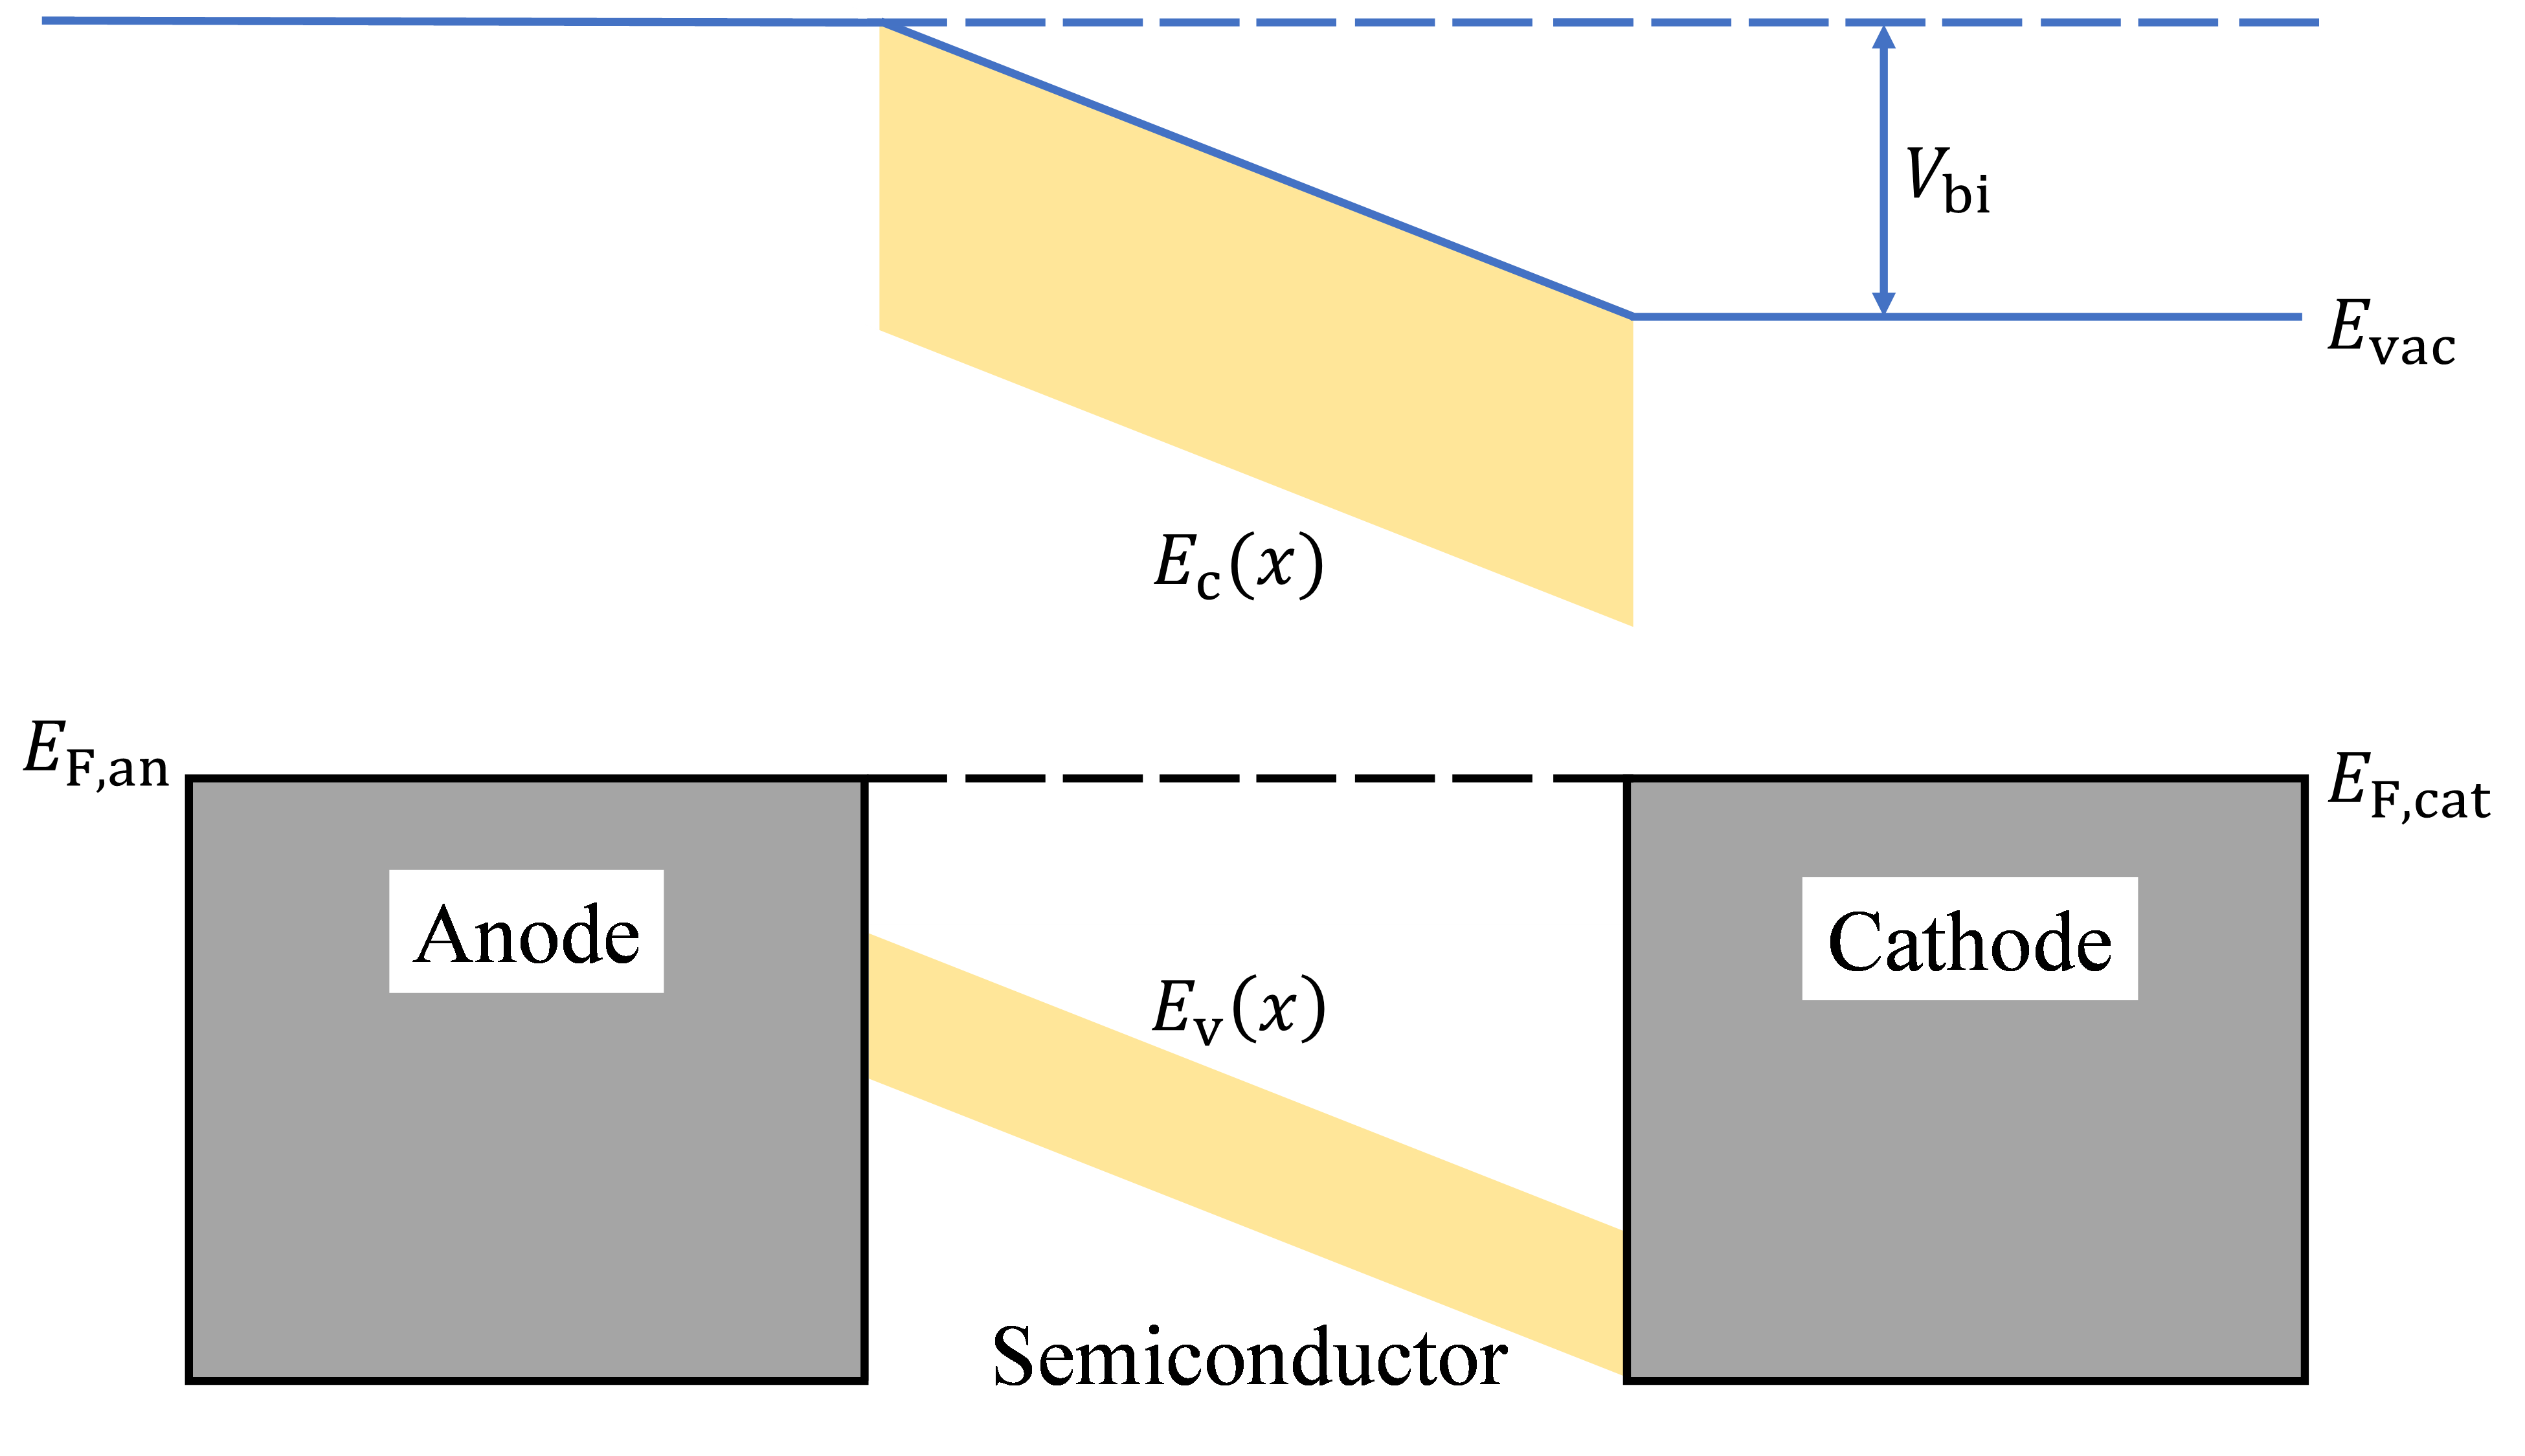

__Figure 2__: The band-structure of the semiconductor-electrode sandwich in the case that the constituent components are brought together and reach thermal equilibrium.
<br/><br/>
&emsp;&emsp;&emsp;&emsp; Considering a single spatial dimension, $x=\vec{r}\cdot\hat{x}$, the built-in voltage $V_{\mathrm{bi}}$ across this dimension is given by the difference in the vacuum level at both contacts; namely,
<br/><br/>
<a id = 'built_in_voltage' ></a>
$$\tag{2.1.7}
qV_{\mathrm{bi}}=E_{\mathrm{vac}}(x=0)-E_{\mathrm{vac}}(x=d_x),
$$
<br/><br/>
where $d_x$ is the thickness of the diode in the $\hat{x}$-direction. The energy of the vacuum level must still satisfy the work function definitions of the anode and cathode. Consequently, the built-in voltage is equal to the difference between the anode's workfunction and the cathode's workfunction,
<br/><br/>
<a id = 'V_bi_wf' ></a>
$$\tag{2.1.8}
qV_{\mathrm{bi}}=\Phi_{\mathrm{an}}-\Phi_{\mathrm{cat}}.
$$
<br/><br/>
In terms of the hole injection barrier at both electrodes, a function for determining the built-in voltage is defined as:
<br/><br/>

In [2817]:
def V_built_in( Phi_p_cat , Phi_p_an ):
    
    """Determine the built-in voltage across the diode using the hole injection barriers at both contacts."""
    
    return Phi_p_cat - Phi_p_an

<br/><br/>
When a voltage drop $V_{\mathrm{drop}}$ exists across the diode, the total effective voltage, $V_{\mathrm{eff}}$, relates to the electric field across it $\vec{\bf{E}}(x,t)$ via
<br/><br/>
<a id = 'eff_V' ></a>
$$\tag{2.1.9}
V_{\mathrm{eff}}=V_{\mathrm{drop}}-V_{\mathrm{bi}}=\int_0^{d_x}\vec{\bf{E}}(x,t)\mathrm{d}x.
$$
<br/><br/>
As the electric field in the device at a given position and time is determined by the graident of the electric potential
<br/><br/>
<a id = 'e_field' ></a>
$$\tag{2.1.10}
\vec{\bf{E}}(\vec{r},t)=-\vec{\nabla}\psi(\vec{r},t),
$$
<br/><br/>
then the effective potential can be written as
<br/><br/>
<a id = 'eff_V_ins' ></a>
$$\tag{2.1.11}
V_{\mathrm{eff}}=V_{\mathrm{drop}}-V_{\mathrm{bi}}=-[\psi(x,t)]_0^{d_x} = \psi(x=0,t)-\psi(x=d_x,t).
$$
<br/><br/>
This can also be written as $qV_{\mathrm{eff}}=q(V_{\mathrm{drop}}-V_{\mathrm{bi}})= E_{\mathrm{vac}}(x=d_x,t)-E_{\mathrm{vac}}(x=0,t)$. Which, upon subsitution of the electron affinity or ionisation potential of the semiconductor, can also be writtn as
<br/><br/>
<a id = 'eff_V_EcEv' ></a>
$$\tag{2.1.12}
qV_{\mathrm{eff}}=q(V_{\mathrm{drop}}-V_{\mathrm{bi}})\\qV_{\mathrm{eff}}=E_{\mathrm{c}}(x=d_x,t)-E_{\mathrm{c}}(x=0,t)\\qV_{\mathrm{eff}}=E_{\mathrm{v}}(x=d_x,t)-E_{\mathrm{v}}(x=0,t).
$$

<a id = 'Potential_Boundary_Conditions' ></a>
#### 2.1.2. Potential Boundary Conditions
[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
To carry out the drift-diffusion simulations, it is necessary to determine the boundary conditions for the potential and for the electron and hole charge carrier densities. At the $x=0$ anode-semiconductor interface, the boundary condition for the potential can simply be defined as
<br/><br/>
<a id = 'psi_bc_0' ></a>
$$\tag{2.1.13}
\psi(x=0,t) = \psi_0,
$$
<br/><br/>
where $\psi_0$ is typically taken to be nought. The boundary condition for the potential at the semiconductor-cathode interface is determined by rearranging equation ([1.11](#eff_V_ins)), giving
<br/><br/>
<a id = 'psi_bc_d' ></a>
$$\tag{2.1.14}
\psi(x=d_x,t) = \psi_0 + V_{\mathrm{bi}} - V_{\mathrm{drop}}
$$
The function used to determine this is:
<br/><br/>

In [2818]:
def psi_d( psi_0 , V_built_in , V_drop ):
    
    """Determine the potential at the semiconductor-cathode boundary using the potential at the anode-semiconductor boundary,
    
    the built-in voltage, and the Voltage Drop."""
    
    return psi_0 + V_built_in - V_drop

#### 2.1.3. Intrinsic Carrier Density

[Return to Table of Contents](#Table_of_Contents)

After evaluating the integral of a parabolic density of states combined with a Fermi-Dirac distribution for electrons in the conduction band, one finds
<br/><br/>
\begin{equation}
\label{eq:nres}\tag{2.1.15}
n(T) =n_{\mathrm{c}}(T)\exp\left(\frac{E_{\mathrm{F,c}}-E_{\mathrm{c}}}{k_{\mathrm{B}}T}\right).
\end{equation}
<br/><br/>
Here, $E_{\mathrm{F,c}}$ is the quasi-Fermi level of electrons in the conduction band, and $n_{\mathrm{c}}(T)$ is the effective electron density. Through a similar derivation, one finds the hole densitiy to be of the form
<br/><br/>
\begin{equation}
\label{eq:pres}\tag{2.1.16}
p(T) = n_{\mathrm{v}}(T)\exp\left(\frac{E_{\mathrm{v}}-E_{\mathrm{F,v}}}{k_{\mathrm{B}}T}\right),
\end{equation}
<br/><br/>
where $n_{\mathrm{v}}(T)$ is the effective hole density, $E_{\mathrm{v}}$ is the maximum energy of the valence band, and $E_{\mathrm{F,v}}$ is the quasi-Fermi level of holes in the valence band.
<br/><br/>
<br/><br/>
If both the valence and conduction band are in equilibrium, the quasi-Fermi levels are equal, giving
<br/><br/>
\begin{equation}\tag{2.1.17}
n(T)p(T)=n_{\mathrm{i}}^2=n_{\mathrm{c}}(T)n_{\mathrm{v}}(T)\exp\left(\frac{E_{\mathrm{v}}-E_{\mathrm{c}}}{k_{\mathrm{B}}T}\right)=n_{\mathrm{c}}(T)n_{\mathrm{v}}(T)\exp\left(-\frac{E_{\mathrm{g}}}{k_{\mathrm{B}}T}\right)
\end{equation}
<br/><br/>
Consequently, the intrinsic carrier density can be written as
<br/><br/>
\begin{equation}
\label{eq:nintrinsic}\tag{2.1.18}
n_{\mathrm{int}}=\sqrt{n_{\mathrm{c}}n_{\mathrm{v}}}\exp\left(-\frac{E_{\mathrm{g}}}{2k_{\mathrm{B}}T}\right),
\end{equation}
<br/><br/>
where the effective electron and hole densities are typically temperature-dependent. The function used to determine the intrinsic carrier density is now defined:
<br/><br/>

In [2819]:
def n_int( n_c , n_v , E_g , kT ):
    
    """Determine the intrinsic carrier density using the effective densities of electrons and holes, the thermal energy (
    
    Boltzmann constant * temperature) in eV, and the energy bandgap in eV."""
    
    return ( n_c * n_v ) ** 0.5 * exp( - E_g / 2 / kT )
    
    
def n_int_squared( n_c , n_v , E_g , psi_norm ):
    
    """Determine the square of the intrinsic carrier density using the effective densities of electrons and holes, 
    
    the temperature in K, and the energy bandgap in eV."""
    
    return n_c * n_v * exp( - E_g / psi_norm )

#### 2.1.4. Charge Carrier Boundary Conditions
[Return to Table of Contents](#Table_of_Contents)


<br/><br/>
Assuming that the charge carrier densities at the contacts are given by the equilibrium distributions (with the contacts being Ohmic), then with $E_{\mathrm{c}}(x)=E_{\mathrm{vac}}(x)-\chi_{\mathrm{aff}}$, $E_{\mathrm{v}}(x) = E_{\mathrm{vac}}(x)-\chi_{\mathrm{IP}}$, $E_{\mathrm{F,an}} = E_{\mathrm{F}} = E_{\mathrm{vac}}(x=0)-\Phi_{\mathrm{an}}$, and $E_{\mathrm{F,cat}} = E_{\mathrm{F}} = E_{\mathrm{vac}}(x=d_x)-\Phi_{\mathrm{cat}}$, the boundary conditions for electrons are
<br/><br/>
\begin{equation}
\label{eq:n0}\tag{2.1.19}
n_0=n(x=0)=n_{\mathrm{c}}\exp\left(-\frac{[\Phi_{\mathrm{an}}-\chi_{\mathrm{aff}}]}{k_{\mathrm{B}}T}\right)=n_{\mathrm{c}}\exp\left(-\frac{\Phi_{\mathrm{n,an}}}{k_{\mathrm{B}}T}\right),
\end{equation}
<br/><br/>
\begin{equation}
\label{eq:nd}\tag{2.1.20}
n_{d_x}=n(x=d_x)=n_{\mathrm{c}}\exp\left(-\frac{[\Phi_{\mathrm{cat}}-\chi_{\mathrm{aff}}]}{k_{\mathrm{B}}T}\right)=n_{\mathrm{c}}\exp\left(-\frac{\Phi_{\mathrm{n,cat}}}{k_{\mathrm{B}}T}\right).
\end{equation}
<br/><br/>
While the boundary conditions for holes are
<br/><br/>
\begin{equation}
\label{eq:p0}\tag{2.1.21}
p_0=p(x=0)=n_{\mathrm{v}}\exp\left(-\frac{[\Phi_{\mathrm{an}}-\chi_{\mathrm{IP}}]}{k_{\mathrm{B}}T}\right)=n_{\mathrm{v}}\exp\left(-\frac{\Phi_{\mathrm{p,an}}}{k_{\mathrm{B}}T}\right),
\end{equation}
<br/><br/>
\begin{equation}
\label{eq:pd}\tag{2.1.22}
p_{d_x}=p(x=d_x)=n_{\mathrm{v}}\exp\left(-\frac{[\Phi_{\mathrm{cat}}-\chi_{\mathrm{IP}}]}{k_{\mathrm{B}}T}\right)=n_{\mathrm{v}}\exp\left(-\frac{\Phi_{\mathrm{p,cat}}}{k_{\mathrm{B}}T}\right).
\end{equation}
<br/><br/>
Note, to reach the right-hand sides of these equations, the definitions of the injection barriers given in equations ([2.2](#e_barrier_an) - [2.5](#h_barrier_cat)) were utilised. The functions used to determine these boundary conditions are:
<br/><br/>

In [2820]:
def n_0( n_c , Phi_n_an , kT ):
    
    """Calculate the electron density at the anode-semiconductor interface using the injection barrier (in eV), the 
    
    effective electron density, and the thermal energy (Boltzmann constant * temperature) in eV."""

    return n_c * exp( - Phi_n_an / kT )

def n_d( n_c , Phi_n_cat , kT ):
    
    """Calculate the electron density at the anode-semiconductor interface using the injection barrier (in eV), the 
    
    effective electron density, and the thermal energy (Boltzmann constant * temperature) in eV."""

    return n_c * exp( - Phi_n_cat / kT )

def p_0( n_v , Phi_p_an , kT ):
    
    """Calculate the electron density at the anode-semiconductor interface using the injection barrier (in eV), the 
    
    effective electron density, and the thermal energy (Boltzmann constant * temperature) in eV."""
    
    return n_v * exp( - Phi_p_an / kT )

def p_d( n_v , Phi_p_cat , kT ):
    
    """Calculate the electron density at the anode-semiconductor interface using the injection barrier (in eV), the 
    
    effective electron density, and the thermal energy (Boltzmann constant * temperature) in eV."""
    
    return n_v * exp( - Phi_p_cat / kT )

<a id = 'DD_Equations' ></a>
### 2.2. Drift-Diffusion Equations
[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
To derive the equations that describe the drift/diffusion of charge carriers in the diode, we first look to Maxwell's equations [__REFRENCE: GRIFFIFTHS ELECTRODYNAMICS__]; the first of these is Gauss' Law,
<br/><br/>
\begin{equation}
\label{eq:gausslaw}\tag{2.2.1}
\vec{\nabla}\cdot\vec{\bf{E}}(\vec{r},t)=\frac{1}{\epsilon_{\mathrm{r}}\epsilon_0}\rho(\vec{r},t),
\end{equation}
<br/><br/>
where $\epsilon_\mathrm{r}$ is the relative permittivity of the semiconductor material, $\epsilon_0$ is the permittivity of free space, and $\rho(\vec{r},t) = q\left[p(\vec{r} , t)-n(\vec{r},t)\right]$ is the space-charge density in the device (the differnce between electron and hole charge densities, both of which are expected to vary with position and time). The second of Maxwell's equations is Gauss' Law for Magnetism,
<br/><br/>
\begin{equation}
\label{eq:gausslawmag}\tag{2.2.2}
\vec{\nabla}\cdot\vec{\bf{B}}(\vec{r},t)=0.
\end{equation}
<br/><br/>
This states that the divergence of the magnetic field $\vec{\bf{B}}(\vec{r},t)$ is nought; there are no magnetic monopoles! Following this, we have Faraday's Law of Induction which relates the curl of the electric field to the rate of change of the magnetic field via
<br/><br/>
\begin{equation}
\label{eq:faradlaw}\tag{2.2.3}
\vec{\nabla}\times\vec{\bf{E}}(\vec{r},t)=-\frac{\partial\vec{\bf{B}}(\vec{r},t)}{\partial t}.
\end{equation}
<br/><br/>
Finally, the last of Maxwell's laws is Ampère's Circuital Law,
<br/><br/>
\begin{equation}
\label{eq:amplaw}\tag{2.2.4}
\vec{\nabla}\times\vec{\bf{B}}(\vec{r},t)=\mu_\mathrm{r}\mu_0\left(\vec{J}(\vec{r},t)+\epsilon_\mathrm{r}\epsilon_0\frac{\partial\vec{\bf{E}}(\vec{r},t)}{\partial t}\right),
\end{equation}
<br/><br/>
where $\mu_\mathrm{r}$ is the relative permeability of the material, $\mu_0$ is the permeability of free space, and $\vec{J}(\vec{r},t)=\vec{J}_n(\vec{r},t)+\vec{J}_p(\vec{r},t)+\vec{J}_{\mathrm{d}}(\vec{r},t)$ is the total current density, a sum of electron, hole, and displacement current densities, $\vec{J}_n$, $\vec{J}_p$, and $\vec{J}_{\mathrm{d}}$ respectively.
<br/><br/>

<a id = 'Continuity_Equations' ></a>
#### 2.2.1. Continuity Equations
[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
By taking the divergence of Ampère's Circuital Law, and making use of $\vec{\nabla}\cdot\vec{\nabla}\times\vec{A}=0$, for any vector $\vec{A}$, one finds that
<br/><br/>
\begin{equation}
\label{eq:conteq_sum}\tag{2.2.5}
\vec{\nabla}\cdot\vec{J}(\vec{r},t)=-\frac{\partial\rho(\vec{r},t)}{\partial t}.
\end{equation}
<br/><br/>
The continuity equations are found by separating this equation in terms of electrons and holes. For electrons, the continuity equation in one spatial dimension is
<br/><br/>
\begin{equation}
\label{eq:conte}\tag{2.2.6}
\frac{\partial n(x,t)}{\partial t} = \frac{1}{q} \frac{\partial J_n(x,t)}{\partial x} + G(x,t) - R(x,t),
\end{equation}
<br/><br/>
where the electron current density $J_n$ has been reduced to one spatial dimension, $G(x,t)$ is the charge generation rate at a given position and time, and $R$ is the recombination rate. The continuity equation for holes reads as
<br/><br/>
\begin{equation}
\label{eq:conth}\tag{2.2.7}
\frac{\partial p(x,t)}{\partial t} = - \frac{1}{q} \frac{\partial J_p(x,t)}{\partial x} + G(x,t) - R(x,t),
\end{equation}
<br/><br/>
In general, the generation rate is given by
<br/><br/>
\begin{equation}
\label{eq:genrate}\tag{2.2.8}
G(x,t) = G_\mathrm{light}(x,t)+\beta n_\mathrm{eq}(x,t)p_\mathrm{eq}(x,t) =  G_\mathrm{light}(x,t)+\beta n_\mathrm{int}^2.
\end{equation}
<br/><br/>
Wherein $G_\mathrm{light}(x,t)$ is the generation rate under illumination at a given position and time, $n_\mathrm{eq}(x,t)$ and $p_\mathrm{eq}(x,t)$ are the electron and hole densities in thermal equilibrium, respectively, and $\beta$ is the recombination rate constant, given by [__REFERENCE: BURKE, BEYOND LANGEVIN RECOMBINATION; KOHLER & BASSLER, ELECTRONIC PROCESSES IN ORGANIC SEMICONDUCTORS__]
<br/><br/>
<a id = 'rate_constant' ></a>
\begin{equation}
\label{eq:rate_constant}\tag{2.2.9}
\beta = \gamma \beta_\mathrm{L} = \frac{q\gamma}{\epsilon_\mathrm{r}\epsilon_0}(\mu_n+\mu_p),
\end{equation}
<br/><br/>
where $\beta_\mathrm{L} = q(\mu_n+\mu_p)/\epsilon_\mathrm{r}\epsilon_0$ is the Langevin encounter rate; the rate at which electrons and holes encounter each other in the diode. Here, $\mu_n$ and $\mu_p$ are the electron and hole mobilities, respectively. The parameter $\gamma$ is the reduction factor, which accounts for not all of the electron-hole encounters resulting in recombined charges. The total recombination rate $R(x,t)$ is given by
<br/><br/>
\begin{equation}
\label{eq:R}\tag{2.2.10}
R(x,t) = \beta n(x,t) p(x,t).
\end{equation}
<br/><br/>
Consequently, the difference between the generation and recombination rates takes the general form
<br/><br/>
<a id = 'rate_diff' ></a>
\begin{equation}
\label{eq:rate_diff}\tag{2.2.11}
G(x,t) - R(x,t) = G_\mathrm{light}(x,t) - \beta \left( n(x,t) p(x,t) - n_\mathrm{int}^2\right).
\end{equation}
<br/><br/>
In thermal equilibrium (in the dark), $G_\mathrm{light}=0$ and $n(x,t)p(x,t) = n_\mathrm{int}^2 \Rightarrow G(x,t) - R(x,t) = 0$. The Langevin encounter rate is calculated using:

In [2821]:
def beta( gamma , epsilon_r , mu_n , mu_p ):
    
    """Compute the Langevin encounter rate using the mobilities in cm2/V/s and the relative permittivity. Then return the 
    
    recombination rate beta using the reduction factor gamma."""
    
    beta_L = e * ( mu_n + mu_p ) / epsilon_0 / epsilon_r * 1E2
    
    return gamma * beta_L # Units are cm3/s

<a id = 'Poisson_Equation' ></a>
#### 2.2.2. Poisson's Equation
[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
As the electric field can be expressed as the gradient of a scalar electric potential, $\psi(\vec{r},t)$, taking the divergence of the electric field and substituting it into Gauss' Law yields Poisson's equation,
<br/><br/>
\begin{equation}
\label{eq:poisson}\tag{2.2.12}
\frac{\partial^2\psi(x,t)}{\partial x^2} = \frac{q}{\epsilon_{\mathrm{r}}\epsilon_0}\left(n(x,t) - p(x,t)\right).
\end{equation}

<a id = 'Current_Equations' ></a>
#### 2.2.3. Current Density Equations
[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
In the presence of a concentration gradient $\partial n(x,t)/\partial x$, electrons will undergo diffusive motion, resulting in a diffusion current of the form $q D_n\partial n(x,t)/\partial x$, where $D_n$ is the Einstein diffusion coefficient for electrons. On the other hand, in the presence of an electric field (given by the gradient of a scalar potential $\partial\psi(x,t)/\partial x$), electrons will undergo drift, generating a current of the form $-q\mu_nn(x,t)\partial\psi(x,t)/\partial x$, where the minus sign indicates that the current flows in the opposite direction to the electric field. Combining these cases together, the total electron current density is
<br/><br/>
\begin{equation}
\label{eq:jn}\tag{2.2.13}
J_n(x,t) = - q\mu_nn(x,t)\frac{\partial\psi(x,t)}{\partial x} + q D_n\frac{\partial n(x,t)}{\partial x}.
\end{equation}
<br/><br/>
On the other hand, the total hole current is
<br/><br/>
\begin{equation}
\label{eq:jp}\tag{2.2.14}
J_p(x,t) = - q\mu_pp(x,t)\frac{\partial\psi(x,t)}{\partial x} - q D_p\frac{\partial p(x,t)}{\partial x},
\end{equation}
<br/><br/>
where $D_p$ is the Einstein diffusion coefficient for holes. The Einstein diffusion coefficients relate to the charge carrier mobilities (classically) via the Einstein relation
<br/><br/>
\begin{equation}
\label{eq:einstein_relation}\tag{2.2.15}
D_{n,p} = \mu_{n,p} \frac{k_\mathrm{B}T}{q}.
\end{equation}
<br/><br/>
&emsp;&emsp;&emsp;&emsp; As a final note, the current densities can be expressed in terms of the quasi-Fermi levels. By making use of the classical Einstein relation and substituting the quasi-Fermi level definition of the electron density into Equation (\ref{eq:jn}), it can be shown that 
<br/><br/>
\begin{equation}
\label{eq:jnFermi}\tag{2.2.16}
J_n(x,t) = \mu_nn(x,t) \frac{\partial}{\partial x}\left( -\frac{\psi(x,t)}{q} + E_\mathrm{F,c}(x,t)-E_\mathrm{c}(x,t)\right)=\mu_nn(x,t) \frac{\partial E_\mathrm{F,c}(x,t)}{\partial x},
\end{equation}
<br/><br/>
where the scalar potential defintion of the vacuum level given was used to reach final result. Through a similar derivation for holes, one finds that the hole current density can be represented as
<br/><br/>
\begin{equation}
\label{eq:jpFermi}\tag{2.2.17}
J_p(x,t) = \mu_pp(x,t)\frac{\partial E_\mathrm{F,v}(x,t)}{\partial x}.
\end{equation}
<br/><br/>

<a id = 'GR_Models' ></a>
### 2.3. Generation Rate Models
[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
In this section, different models for the generation rate under illumination are presented. As the section progresses, the models become increasingly complex, starting with the simple flat generation rate, then ending with the optically-modelled generation rate.
<a id = 'Flat_GR' ></a>
#### 2.3.1. Spectrally-Flat Generation Rate
[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
The most simple model for the generation rate assumes a spectrally-flat, constant generation rate across the active layer. Assuming this takes some fixed value $G_{\mathrm{light}}$, then
<br/><br/>
$$\tag{2.3.1}
G_{\mathrm{light}}(E,x,t)=G_{\mathrm{light}}(t).
$$
<br/><br/>
And so the generation rate in this case is independent of photon energy and position, it is just some fixed value. The following function is defined for calculating a flat generation rate at a set of positions:
<br/><br/>

In [2822]:
def Flat_G_light( G_light_value, xs ):
    
    """Determine the generation rate at a set of points (xs) using the flat generation rate assumption."""
    
    return array( [ G_light_value for x in xs ] ) 

<a id = 'Beer_Lambert_GR' ></a>
#### 2.3.2. Beer-Lambert Generation Rate
[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
The next simplest model for the generation rate (after the constant generation rate) assumes exponentially decaying generation across the active layer. In this case, $G_{\mathrm{light}}(E,x,t)$ may be given by
<br/><br/>
$$\tag{2.3.2}
G_{\mathrm{light}}(E,x,t)\approx G_{\mathrm{light}}(t)e^{-\alpha(E)x},
$$
<br/><br/>
where the absorption coefficient $\alpha(E)$ of the active layer relates to its extinction coefficient $\kappa(E)$ via __[REFERENCE: PETTERSSON ET AL (1999)]__
<br/><br/>
$$\tag{2.3.3}
\alpha(E) = \frac{4\pi}{\lambda}\kappa(E)=\frac{4\pi E}{hc} \kappa(E).
$$
<br/><br/>
For more accurate simulations, experimentally-determined optical constant data can be substituted in to describe the active layer's absorption coefficient. The Beer-Lambert generation rate is shown in the next section to be a special case of the full optical modelling described in the next section. The following function is used for calculating the generation rate using the Beer-Lambert Law:
<br/><br/>

In [2823]:
def Beer_Lambert_G_light( G_light_value, alpha, xs ):
    
    """Determine the generation rate using the Beer-Lambert law, assuming that the positions 'xs' and the absorption 
    
    coefficient 'alpha' have inverse units."""
    
    return array( [ G_light_value * exp( - alpha * x ) for x in xs ] )

<a id = 'Opt_Mod_GR' ></a>
#### 2.3.3. Optically-Modelled Generation Rate
[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
In the most detailed simulations, the generation rate can be determined using an optical transfer matrix model, as described in the work of Pettersson et al., and expanded upon by Burkhard et al. and Peuman et al..__[Ref. Pettersson, Burkard, Peuman]__. In this model, each layer of a stratified, multi-layered device is described with a quantity $q_j$, which describes the propagation of light in layer $j$ with complex refractive index $\tilde{\eta}_j=\eta_j+i\kappa_j$, where $\eta_j$ and $\kappa_j$ are the (real) refractive index and extinction coeffiient of layer $j$, respectively. In general, these are spectral quantities; at a given photon energy, the layer's $q$ value is defined by 
<br/><br/>
$$\tag{2.3.4}
q_j=\tilde{\eta}_j\cos\left(\phi_j\right).
$$
<br/><br/>
Here, $\phi_j$ is the angle the light propagates at in layer $j$ relative to the the plane of the interfaces. Through Snell's law, the angle of propagation in the $j$-th layer relates to the angle of incidence upon the device, $\phi_0$, via:
<br/><br/>
$$\tag{2.3.5}
\eta_0\sin\left(\phi_0\right)=\eta_1\sin\left(\phi_1\right)= ... = \eta_j\sin\left(\phi_j\right).
$$
<br/><br/>
Provided that $\eta_j>\eta_0$, otherwise the light will be totally internally reflected at the interface before passing into layer $j$ (with an evanescent wave propagating into the layer itself __[REF. Griffiths]__. Consequently, the angle of propagation in layer $j$ is given by
<br/><br/>
$$\tag{2.3.6}
\phi_j=\arcsin\left(\frac{\eta_0}{\eta_j}\sin\left(\phi_0\right)\right)
$$
<br/><br/>
A fucntion that determines the angle of propagation in layer $j$ using this expression is defined:
<br/><br/>

In [2824]:
def phi_j( Refractive_Index_0 , Refractive_Index_j , Incident_Angle ):
    
    """Determine the angle of propagation in layer j in radians using the incident angle in layer 0 (also in radians), the 
    
    refractive index in the zeorth layer, and the refractive index in the j-th layer."""
    
    return arcsin( Refractive_Index_0 / Refractive_Index_j * sin( Incident_Angle ) )

<br/><br/>
This layer's $q$ value is determined by the code using the following function:
<br/><br/>

In [2825]:
def q_j_calculator( Complex_Refractive_Index , Angle_of_Propagation ):
    
    """Determine the quantity q_j for the j-th layer, using its complex refractive index and the angle of propagation (in 
    
    radians)."""
    
    return Complex_Refractive_Index * cos( Angle_of_Propagation )

<br/><br/>
Using each layer's $q_j$ values and complex refractive indices, the complex Fresnel reflection and transmission coefficients at each interface can be determined. For $s$-polarised light, the complex Fresnel reflection coefficient at the interface between layers $j$ and $k$ takes the form
<br/><br/>
<a id = 'r_jk_s' ></a>
$$\tag{2.3.7}
r_{jk}^s = \frac{q_j-q_k}{q_j+q_k}.
$$
<br/><br/>
This equation is evaluated through:
<br/><br/>

In [2826]:
def r_jk_s( q_j , q_k ):
    
    """Determine the Fresnel reflection coeffient for s-polarised light."""
    
    return ( q_j - q_k ) / ( q_j + q_k )

<br/><br/>
On the other hand, the complex Fresnel transmission coefficient takes the form
<br/><br/>
<a id = 't_jk_s' ></a>
$$\tag{2.3.8}
t_{jk}^s = \frac{2q_j}{q_j+q_k}.
$$
<br/><br/>
This equation is evaluated using:
<br/><br/>

In [2827]:
def t_jk_s( q_j , q_k ):
    
    """Determine the Fresnel transmission coeffient for s-polarised light."""
    
    return 2 * q_j / ( q_j + q_k )

For $p$-polarised light on the other hand, the complex Fresnel reflection coefficient at the interface between layers $j$ and $k$ takes the form
<br/><br/>
<a id = 'r_jk_p' ></a>
$$\tag{2.3.9}
r_{jk}^p = \frac{\tilde{\eta}_j^2q_k-\tilde{\eta}_k^2 q_j}{\tilde{\eta}_k^2q_j+\tilde{\eta}_j^2q_k}.
$$
<br/><br/>
This function is encoded using:
<br/><br/>

In [2828]:
def r_jk_p( q_j , q_k , Complex_Refractive_Index_j , Complex_Refractive_Index_k ):
    
    """Determine the Fresnel reflection coeffient for p-polarised light."""
    
    Numerator = Complex_Refractive_Index_j ** 2 * q_k - Complex_Refractive_Index_k ** 2 * q_j 
    
    Denominator =  Complex_Refractive_Index_k ** 2 * q_j + Complex_Refractive_Index_j ** 2 * q_k
    
    return Numerator / Denominator

<br/><br/>
Finally, the complex Fresnel transmission coefficient for $p$-polarised light takes the form
<br/><br/>
<a id = 't_jk_p' ></a>
$$\tag{2.3.10}
t_{jk}^p = \frac{2\tilde{\eta}_j\tilde{\eta}_kq_j}{\tilde{\eta}_k^2q_j+\tilde{\eta}_j^2q_k}.
$$
<br/><br/>
Which is encoded using:
<br/><br/>

In [2829]:
def t_jk_p( q_j , q_k , Complex_Refractive_Index_j , Complex_Refractive_Index_k ):
    
    """Determine the Fresnel reflection coeffient for p-polarised light."""
    
    Numerator =  2 * Complex_Refractive_Index_j * Complex_Refractive_Index_k * q_j
    
    Denominator =  Complex_Refractive_Index_k ** 2 * q_j + Complex_Refractive_Index_j ** 2 * q_k
    
    return Numerator / Denominator

<br/><br/>
Following this, an interface matrix is defined by 
<br/><br/>
$$\tag{2.3.11}
I_{jk}=\frac{1}{t_{jk}}\begin{pmatrix}
1&r_{jk}\\
r_{jk}&1
\end{pmatrix},
$$
<br/><br/>
and is enoded into the script using:
<br/><br/>

In [2830]:
def I_jk( r_jk , t_jk ):  
    
    """Returns the interface matrix/matrix of refraction of the interface
    betweeen the j-th and k-th layers."""
    
    return array( [ [ 1 , r_jk ] , [ r_jk , 1 ] ] ) / t_jk

<br/><br/>
In addition, the phase shift associated with a layer of thickness $d_j$ is defined as:
<br/><br/>
$$\tag{2.3.12}
\xi_j = \frac{2\pi}{\lambda}q_j,
$$
<br/><br/>
where $\lambda=\frac{hc}{E}$ is the wavelength of the incident light. This phase shift is implemented into the code using:
<br/><br/>

In [2831]:
def xi_j( q_j , wavelength ):
    
    """Returns the phase change experienced by the light as it propagates across layer j."""
    
    return 2 * pi * q_j / wavelength

<br/><br/>
Using this phase change, a layer matrix is defined to describe the propagation of light across the $j$-th layer of thickness $d_j$,
<br/><br/>
$$\tag{2.3.13}
L_j=\begin{pmatrix}
e^{-i\xi_jd_j}&0\\
0&e^{i\xi_jd_j}
\end{pmatrix}.
$$
<br/><br/>
A function to apply this equation is defined in the script using:
<br/><br/>

In [2832]:
def L_j( xi_j , d_j ):
    
    """Returns the layer matrix (or phase matrix), describing the phase change experienced by a wave as it propagates 
    
    through the j-th layer of thickness d_j."""
        
    exponent = 1j * xi_j * d_j
    
    return array( [ [ exp( - exponent ) , 0 ] , [ 0 , exp( exponent ) ] ] )

<br/><br/>
The following helper function is defined to help conversions between the different units:
<br/><br/>

In [2833]:
def Degree_to_Radian_Converter( Angle ):
    
    return Angle / 180 * pi

<br/><br/>
With the interface and layer matrices now defined, the total reflection, transmission, and absorption (i.e., exciton generation) of the device can be calculated through the optical transfer matrix model. In this model, the incoherence-inducing effects of extremely thick substrates are accounted for using the prescription of Peumans et al., wherein the substrates are seperated from the layers of the thin-film stack as shown below in __Figure 3__. In this case, the intensity of the optical electric field incident on the interface between the substrate (layer $j=1$) and the first layer of the thin-film stack (layer $j=2$), labelled as $I_{\mathrm{trans}}$, relates to the field on the device ($I_0$) via a transmission coefficient $T_{\mathrm{trans}}$:
<br/><br/>
$$\tag{2.3.14}
I_{\mathrm{trans}} = T_{\mathrm{trans}} I_0
$$
<br/><br/>
This coefficient is defined as the infinite sum of a geometric series, where each term incorporates additional reflection, as well as attenuation in the substrate:
<br/><br/>
$$\tag{2.3.15}
T_{\mathrm{trans}} = T_{01}\Delta_1\left[1 + \Delta_1^2R_{10}R_{1,N+1} + \left(\Delta_1^2R_{10}R_{1,N+1}\right)^2 + ... \right] = T_{01}\Delta_1\sum_{l=0}^\infty \left(\Delta_1^2R_{10}R_{1,N+1}\right)^l= \frac{T_{01}\Delta_1}{1-\Delta_1^2R_{10}R_{1,N+1}}.
$$
<br/><br/>
Here, the term $\Delta_1$ denotes the attenuation of the optical electric field as it propagates across the absorbing substrate; it is defined by
<br/><br/>
$$\tag{2.3.16}
\Delta_1 = \exp\left[-\alpha_1 d_1 \cos\left(\phi_1\right)\right]
$$
<br/><br/>
where $d_1\cos\left(\phi_1\right)$ is the path length the light propagates on each pass. In the case that the substrate is weakly absorbing ($\alpha_1\to 0$), $\Delta_1\to1$. The Python function used in this script to calculate $\Delta_1$ is defined as: 
<br/><br/>

In [2834]:
def Attenuation_Delta( alpha, d, phi ):
    
    """Calculate the intensity attenutation during a pass through the substrate with absorption coefficient alpha and 

    thickness d (the units of these parameters must be inverse). The angle of propagation in the substrate is expected to 
    
    be previously calculated, and it should be entered in radians."""
    
    return exp( - alpha * d * cos( phi ) )

<br/><br/>
The other parameters needed to calculate the intensity transmission to the interface between the substrate and the thin-film stack are the intensity reflection and transmission coefficients of the interface between the ambient and the substrate ($R_{01}$ \& $R_{10}$, and $T_{01}$ \& $T_{10}$, respectively) and the substrate and the thin-film stack ($R_{1,N+1}$ and $T_{1,N+1}$, respectively). These intensity reflection and transmission coefficients are determined from the Fresnel coefficients using the following functions:
<br/><br/>

In [2835]:
def R_Intensity( r_Fresnel ):
    
    """Determine the (real) reflection coefficient for the incident light intensity, using the complex Fresnel reflection
    
    coefficient."""
    
    return abs( r_Fresnel ) ** 2

def T_Intensity( t_Fresnel, eta_j, eta_k ):

    """Determine the (real) transmission coefficient for the incident light intensity, using the complex Fresnel 
    
    transmission coefficient and the (real) refractive indices of the two media (with eta_k being the refractive index of 
    
    the final medium)."""
    
    return eta_k / eta_j * abs( t_Fresnel ) ** 2

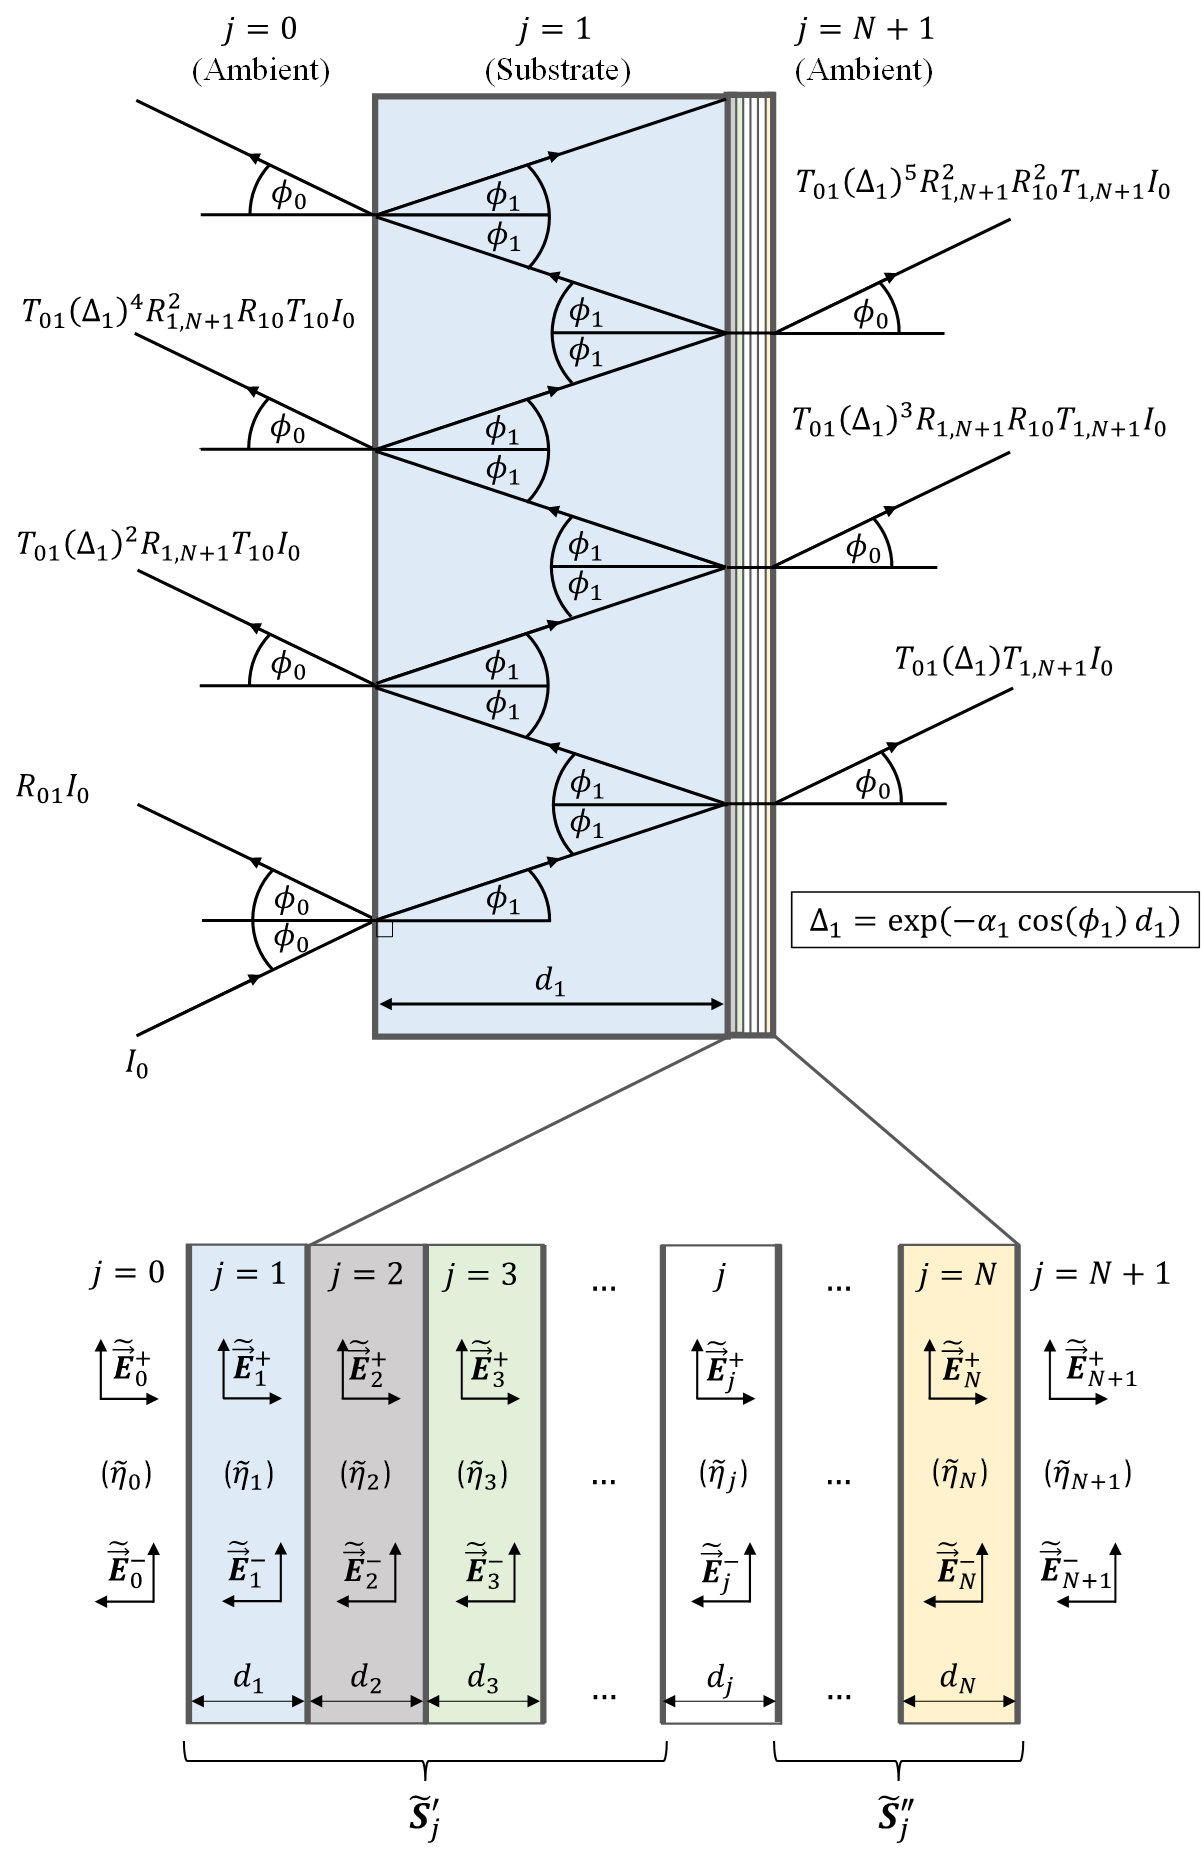

__Figure 3__: The optical transfer matrix model including incoherence-inducing effects of thick substrates. Here, the propagation of an optical electric field is modelled inside a device with $N$ distinct and stratified layers, such that the total reflection, transmission, and absorption may be determined.
<br/><br/>
&emsp;&emsp;&emsp;&emsp; Using the reflectance and transmission of the first interface, and the thin-film stack, the net transmission of light up to the interface between the incoherent substrate and the thin-film stack can be calculated using:
<br/><br/>

In [2836]:
def T_trans( R_01, T_01, R_stack, Delta_1 ):
    
    """Determine the intensity transmission of light up to the interface between the incoherent substrate and the thin-film
    
    stack, using the reflection and transmission coefficients of the first interface (between the surrounding medium and the
    
    substrate), the reflectance of the thin-film stack (determined through optical modelling techniques), and the 
    
    attenuation in the substrate (Delta_1)."""
    
    return T_01 * Delta_1 / ( 1 - Delta_1 ** 2 * R_01 * R_stack )    

<br/><br/>
Through a similar derivation, the total reflectance and transmittance of the device may be written as:
<br/><br/>
$$\tag{2.3.17}
R_{\mathrm{tot}} = R_{01} + \frac{ T_{01}^2 \Delta_1^2 R_{1,N+1}}{1-\Delta_1^2R_{01} R_{1,N+1}}=\frac{R_{01} + \Delta_1^2\left[1-2R_{01}\right] R_{1,N+1}}{1-\Delta_1^2R_{01} R_{1,N+1}},
$$
<br/><br/>
and
$$\tag{2.3.18}
T_{\mathrm{tot}} = \frac{ T_{01} \Delta_1 T_{1,N+1}}{1-\Delta_1^2 R_{01}R_{1,N+1}},
$$
<br/><br/>
respectively. These coefficients are evaluated using the following Python code:
<br/><br/>

In [2837]:
def R_Tot( R_01, R_stack, Delta_1 ):
    
    """Determine the fraction of light reflected from the device using the reflection coefficients of the first interface 
    
    (between the surrounding medium and the substrate), the reflectance of the thin-film stack (determined through optical
    
    modelling techniques), and the attenuation in the substrate (Delta_1)."""
    
    return ( R_01 + Delta_1 ** 2 * ( 1 - 2 * R_01 ) * R_stack ) / ( 1 - Delta_1 ** 2 * R_01 * R_stack )    
            
def T_Tot( R_01, R_stack, Delta_1 ):
    
    """Determine the fraction of light transmitted through the device, using the reflection coefficients of the first
    
    interface (between the surrounding medium and the substrate), the reflectance of the thin-film stack (determined 
    
    through optical modelling techniques), and the attenuation in the substrate (Delta_1)."""
    
    return ( ( 1 - R_01 ) * Delta_1 * ( 1 - R_stack ) ) / ( 1 - Delta_1 ** 2 * R_01 * R_stack )    

<br/><br/>
With the interface and layer matrices defined, the complex Fresnel reflection and transmission coefficients may be determined by writing a full system transfer matrix $\bf{S}$ as the product of all interface and layer matrices in the thin-film stack: 
<br/><br/>
$$\tag{2.3.19}
\mathbf{S}
=\begin{pmatrix}
S_{11}&S_{12}\\
S_{21}&S_{22}
\end{pmatrix}=
\prod_{j=2}^N \left(I_{j-1,\,j}\cdot L_j\right)\cdot I_{N,N+1},
$$
<br/><br/>
where the product taken from $j=2$ ensures the incoherent substrate is separated from the thin-film stack. In the case that the substrate is also coherent, the prodcuct would be taken from $j=1$, such that the first interface matrix is $I_{0,1}$. Using this total system transfer matrix, the optical electric field in the ambient medium (on the anterior side of the device) can be related to the optical electric field on the posterior side of the device via:
<br/><br/>
$$\tag{2.3.20}
\begin{pmatrix}
\mathbf{E}_0^+\\
\mathbf{E}_0^-
\end{pmatrix}
=
\mathbf{S}
\begin{pmatrix}
\mathbf{E}_{N+1}^+\\
\mathbf{E}_{N+1}^-
\end{pmatrix}.
$$
<br/><br/>
Assuming that no light is back-reflected in the final medium, then there will be no optical electric field propagating toward the device in layer $N+1$, implying that $\mathbf{E}_{N+1}^-=0$. Consequently, the complex Fresnel reflection and transmission coefficients of the full thin-film stack can be determined using: 
$$\tag{2.3.21}
\begin{equation}
r=\frac{\mathbf{E}_0^-}{\mathbf{E}_0^+}=\frac{S_{21}}{S_{11}},
\end{equation}
$$
and
$$\tag{2.3.22}
\begin{equation}
t=\frac{\mathbf{E}_{N+1}^+}{\mathbf{E}_0^+}=\frac{1}{S_{11}}.
\end{equation}
$$
<br/><br/>
Using these equations, the reflectance and transmittance of the thin-film stack can be determined using the following functions:
<br/><br/>

In [2838]:
def r_Fresnel( Transfer_Matrix ):
    
    """Using the 2x2 transfer matrix, determine the complex Fresnel reflection coefficient as the ratio of the 21 element
    
    to the 11 element. This can be done for the total transfer matrix and the partial transfer matrices."""
    
    return Transfer_Matrix[ 1, 0 ] / Transfer_Matrix[ 0, 0 ]

def t_Fresnel( Transfer_Matrix ):
    
    """Using the 2x2 transfer matrix, determine the complex Fresnel transmission coefficient as the inverse of 11 element.
    
    This can be done for the total transfer matrix and the partial transfer matrices."""
    
    return 1 / Transfer_Matrix[ 0, 0 ]

<br/><br/>
The following code is defined for computing the optical transfer matrix model at a given wavelength using the above theory. Under the GNU license, it has been adapted from the Python code written by Burkhard et al. (see https://onlinelibrary.wiley.com/doi/10.1002/adma.201000883) and the un-edited code may be downloaded from: https://web.stanford.edu/group/mcgehee/transfermatrix/.
<br/><br/>


In [2839]:
from numpy import cumsum, ones, transpose, where, zeros

import pylab as pl

def I_mat( n_tilde1, n_tilde2 ):
    
    """Compute the interface matrix using the complex refractive indices of the different layers (labelled as n1 and n2)."""
    
    r = ( n_tilde1 - n_tilde2 ) / ( n_tilde1 + n_tilde2 )
    
    t = ( 2 * n_tilde1 ) / ( n_tilde1 + n_tilde2 )
    
    return array( [ [ 1, r ],
                    [ r, 1 ] ] ) / t

def L_mat( n_tilde, d, Wavelength ):
    
    """Determine the propgation matrix for a given layer, using its complex refractive index (n_tilde), thickness (d), and
    
    the wavelength of the light."""
    
    xi = 2 * pi * d * n_tilde / Wavelength
    
    return array( [ [ exp( - 1j * xi ), 0 ], 
                   
                    [ 0, exp( 1j * xi ) ] ] )

def Optical_Modeller( Wavelengths, IQEs, Photon_Fluxes, Surrounding_Medium, Layer_Types, Layer_Thicknesses, Position_Spacing,
                     
                     Active_Layer_Index,
                     
                    Incoherent_Substrate = True,
                    
                    Infinite_Final_Layer = False ):
    

    """Conduct the optical modelling simulations using the wavelengths, the internal quantum efficiencies (IQEs), the
    
    surrounding medium type, the layer types and thicknesses, the separation between points, and the index of the active 
    
    layer. The wavelengths are assumed to be in an list/array in terms of increasing wavelength."""

    Active_Layer_Index = Active_Layer_Index - 1 # Python counts from 0
    
    #-----------------------------------------------------------------------------------------------------------------------
    # If Final Layer is Finite, Add Surrounding Medium to Device
    #----------------------------------------------------------------------------------------------------------------------- 
    
    if not Infinite_Final_Layer:
    
        Layer_Types.append( Surrounding_Medium )
    
        Layer_Thicknesses.append( 0 )
        
    #-----------------------------------------------------------------------------------------------------------------------
    # Determine Optical Constants
    #----------------------------------------------------------------------------------------------------------------------- 
    
    n_tildes = zeros( ( len( Layer_Types ), len( Wavelengths ) ), dtype = complex )

    # load index of refraction for each material in the stack

    for i, Layer_Type in enumerate( Layer_Types ):

        n_is, k_is = Optical_Constant_Interpolator( Wavelengths, Layer_Type )

        n_tildes[ i, : ] = n_is + 1j * k_is

    #----------------------------------------------------------------------------------------------------------------------
    # Determine Incoherent Intensity Transmission Through Substrate
    #----------------------------------------------------------------------------------------------------------------------

    n_0s, k_0s = Optical_Constant_Interpolator( Wavelengths, Surrounding_Medium ) 

    n_0_tildes = n_0s + 1j * k_0s  

    n_1_tildes = n_tildes[ 0, : ]

    r_01s = ( n_0_tildes - n_1_tildes ) / ( n_0_tildes + n_1_tildes )
    
    t_01s = 2 * n_0_tildes / ( n_0_tildes + n_1_tildes )

    R_01s = abs( r_01s ) ** 2

    T_01s = abs( n_1_tildes / n_0_tildes ) * abs( t_01s ) ** 2
    
    #----------------------------------------------------------------------------------------------------------------------
    # Simulate Positions
    #----------------------------------------------------------------------------------------------------------------------

    if Incoherent_Substrate:
        
        Substrate_Thickness = Layer_Thicknesses[ 0 ]
    
        Layer_Thicknesses[ 0 ] = 0
    
    Positions = []

    for j, Type in enumerate( Layer_Types ):
    
        Positions_j = arange( 0, Layer_Thicknesses[ j ], Position_Spacing )[ 1: ]
    
        if len( Positions_j ) > 0:
        
            Positions.append( Positions_j )

        else:
        
            Positions.append( array( [ 0 ] ) )
                
    #----------------------------------------------------------------------------------------------------------------------
    # Calculate Transfer Matrices, and Normalised Optical Electric Field at Each Wavelength and Position
    #----------------------------------------------------------------------------------------------------------------------

    # Intialise Rs and Ts, and Absorptances
    
    global R_tots, T_tots

    R_stacks = zeros( len( Wavelengths ) )  # Reflectance of Thin-Film Stack

    T_stacks = zeros( len( Wavelengths ) )  # Transmittance of Thin-Film Stack

    R_tots = zeros( len( Wavelengths ) )  # Total Reflectance of Device
    
    T_tots = zeros( len( Wavelengths ) )  # Total Transmittance of Device
    
    T_subs = zeros( len( Wavelengths ) )
    
    if Incoherent_Substrate:
                
        Deltas = zeros( len( Wavelengths ) )
        
    E2s = [ zeros( ( len( Positions_j ), len( Wavelengths ) ) ) for Positions_j in Positions ]
                    
    # Iterate Over All Wavelengths
    
    Lower_Index = 1
    
    if not Incoherent_Substrate:
        
        Lower_Index = 0        

    for j, Wavelength in enumerate( Wavelengths ):
    
        #------------------------------------------------------------------------------------------------------------------
        # Calculate the Transfer Matrices for Reflection/Transmission of Stack
        #------------------------------------------------------------------------------------------------------------------

        Ordered_Matrices = [ I_mat( n_tildes[ Layer_Index, j ], n_tildes[ Layer_Index + 1, j ] ) 
                          
                          for Layer_Index in range( len( Layer_Thicknesses )  - 1 ) ]

        Shift = 0
    
        for Layer_Index in range( 1, len( Layer_Thicknesses ) ):
        
            Layer_Thickness = Layer_Thicknesses[ Layer_Index ]
        
            n_tilde_j = n_tildes[ Layer_Index, j ]
                
            Ordered_Matrices.insert( Layer_Index + Shift, L_mat( n_tilde_j, Layer_Thickness, Wavelength ) )
    
            Shift += 1
    
        # If the first layer is NOT incoherent, add the Interface matrix and layer matrix for the surrounding_medium
    
        Layer_1_Thickness = Substrate_Thickness
    
        if not Incoherent_Substrate:
                
            n_0_tilde = n_0_tildes[ j ]  

            n_1_tilde = n_tildes[ 0, j ]
        
            I = I_mat( n_0_tilde, n_1_tilde )
                
            L = L_mat( n_1_tilde, Layer_1_Thickness, Wavelength )
    
            Ordered_Matrices = [ I, L ] + Ordered_Matrices
    
        # Determine TOTAL System Transfer Matrix
        
        S = linalg.multi_dot( Ordered_Matrices )
    
        # Determine Reflection and Transmission of Thin-Film Stack

        R_stack = abs( S[ 1, 0 ] / S[ 0, 0 ] ) ** 2
        
        R_stacks[ j ] = R_stack
        
        if Incoherent_Substrate:
            
            T_stack = abs( n_0_tildes[ j ] / n_tildes[ 0, j ] ) * abs( 1 / S[ 0, 0 ] ) ** 2
            
            T_stacks[ j ] = T_stack 
            
            Delta = exp( - 4 * pi * n_tildes[ 0, j ].imag / Wavelength * Layer_1_Thickness )
            
            Deltas[ j ] = Delta
            
            T_subs[ j ] = T_01s[ j ] * Delta / ( 1 - Delta ** 2 * R_01s[ j ] * R_stacks[ j ] )      
            
            R_tots[ j ] = R_01s[ j ] + T_01s[ j ] ** 2 * Delta ** 2 * R_stacks[ j ] / ( 1 - Delta ** 2 * R_01s[ j ] * R_stacks[ j ] )
    
            T_tots[ j ] = T_subs[ j ] * T_stack
        
        else:
            
            T_stack = abs( 1 / S[ 0, 0 ] ) ** 2
            
            T_stacks[ j ] = T_stack
            
            R_tots[ j ] = R_stack
            
            T_tots[ j ] = T_stack
        
            T_subs[ j ] = 1
        
        #------------------------------------------------------------------------------------------------------------------
        # Calculate Anterior and Posterior Partial System Transfer Matrices 
        #------------------------------------------------------------------------------------------------------------------

        for Layer_Index in range( Lower_Index, len( Layer_Thicknesses ) - 1 ):

            xi = 2 * pi * n_tildes[ Layer_Index, j ] / Wavelength

            Layer_Thickness = Layer_Thicknesses[ Layer_Index ]

            x = Positions[ Layer_Index ]      
        
            #--------------------------------------------------------------------------------------------------------------
            # Calculate S_Prime
            #--------------------------------------------------------------------------------------------------------------        
        
            if Incoherent_Substrate:
        
                Anterior_Matrices = Ordered_Matrices[ : 2 * Layer_Index - 1 ]
            
            else:
            
                Anterior_Matrices = Ordered_Matrices[ : 2 * Layer_Index + 1 ]
            
            if len( Anterior_Matrices ) > 1:

                S_prime = linalg.multi_dot( Anterior_Matrices )
                        
            else:
            
                S_prime = Anterior_Matrices[ 0 ]

            #--------------------------------------------------------------------------------------------------------------
            # Calculate S_pprime (double prime)
            #--------------------------------------------------------------------------------------------------------------                            
        
            if Incoherent_Substrate:
            
                Posterior_Matrices = Ordered_Matrices[ 2 * Layer_Index : ]
            
            else:
            
                Posterior_Matrices = Ordered_Matrices[ 2 * Layer_Index + 2 : ]
            
            if len( Posterior_Matrices ) > 1:
            
                S_pprime = linalg.multi_dot( Posterior_Matrices )
            
            else:
            
                S_pprime = Posterior_Matrices[ 0 ]
                
            num = sqrt( T_subs[ j ] ) * ( S_pprime[ 0, 0 ] * exp( -1j * xi *( Layer_Thickness - x ) ) + 
                          
                          S_pprime[ 1, 0 ] * exp( 1j * xi * ( Layer_Thickness - x ) ) )

            den = S_prime[ 0, 0 ] * S_pprime[ 0, 0 ] * exp( -1j * xi * Layer_Thickness ) + S_prime[ 0, 1 ] * S_pprime[ 1, 0 ] * exp( 1j * xi * Layer_Thickness )
            
            E2s[ Layer_Index ][ :, j ] = abs( n_0_tildes[ j ] / n_1_tildes[ j ] ) * abs( num / den ) ** 2
            
    #----------------------------------------------------------------------------------------------------------------------
    # Determine Absorption
    #----------------------------------------------------------------------------------------------------------------------
            
    Abs = {}
    
    for Layer_Index in arange( Lower_Index, len( Layer_Thicknesses ) ):
    
        alphas = 4 * pi * n_tildes[ Layer_Index, : ].imag / Wavelengths
        
        xs = Positions[ Layer_Index ]
        
        Norm_E_sqrs = E2s[ Layer_Index ]
        
        Abs_j = []
                            
        for j, Wavelength in enumerate( Wavelengths ):
            
            Es = Norm_E_sqrs[ :, j ]
            
            AbsRate =  alphas[ j ] * n_tildes[ Layer_Index, j ].real * Es
            
            Abs_j.append( sum( AbsRate ) * Position_Spacing )

        Abs[ str( Layer_Index ) + '_' + Layer_Types[ Layer_Index ] ] = Abs_j

    # Determine total absorption
    
    Abs_tot = 1 - R_tots - T_tots
    
    #----------------------------------------------------------------------------------------------------------------------
    # Determine EQE
    #----------------------------------------------------------------------------------------------------------------------
    
    EQEs = array( Abs[ str( Active_Layer_Index ) + '_' + Layer_Types[ Active_Layer_Index ] ] ) * array( IQEs )
    
    #----------------------------------------------------------------------------------------------------------------------
    # Determine Generation Rate
    #----------------------------------------------------------------------------------------------------------------------
        
    # First, determine irradiances:
    
    Irradiances = Photon_Fluxes * Energy_Wavelength_Converter( Wavelengths ) * e    
        
    # Next, determine energy dissipation
    
    alpha_ALs = 4 * pi * n_tildes[ Active_Layer_Index, : ].imag / Wavelengths
    
    Q_js_init = alpha_ALs * n_tildes[ Active_Layer_Index, : ].real / n_0_tildes.real * Irradiances   # Need to multiply by |E|^2

    # Calculate G_light
        
    G_lights = []
    
    E2s_Al = E2s[ Active_Layer_Index ]
    
    # Determine Wavelength Separation and Positions
    
    Delta_Wavelength = Wavelengths[ 1 ] - Wavelengths[ 0 ] 
        
    Active_Layer_Positions = Positions[ Active_Layer_Index ]

    for k, Position in enumerate( Active_Layer_Positions ):
                           
        Q_js = E2s_Al[ k, : ] * Q_js_init
                                
        G_lights_j = IQEs * Q_js / h / c * ( Wavelengths * 1e-9 ) 
            
        G_light = sum( G_lights_j ) * Delta_Wavelength # Units are excitons/s/cm2/nm
        
        G_light *= 1e7 # Units are excitons/s/cm3
                
        G_lights.append( G_light )
        
    #----------------------------------------------------------------------------------------------------------------------
    # Output Dictionaries
    #---------------------------------------------------------------------------------------------------------------------
    
    # Optical Electric Field:
    
    Electric_Field_Output = { 'Positions' : Positions, 'E2s' : E2s }
    
    # Spectral Parameters:
    
    Optical_Modelling_Output = { 'Wavelength' : Wavelengths,
                                
                                 'Energy' : Energy_Wavelength_Converter( Wavelengths ),
                                
                                 'EQE' : EQEs,
                                
                                 'R' : R_tots,
                                
                                 'T' : T_tots,
                               
                                 'Total Abs' : Abs_tot }
    
    Optical_Modelling_Output = Optical_Modelling_Output | Abs
    
    # Generation Rate:
        
    Generation_Rate_Output = { 'x' : Active_Layer_Positions,
                             
                               'G_light' : G_lights }        

    return Electric_Field_Output, Optical_Modelling_Output, Generation_Rate_Output

<br/><br/>
As the above function computes the generation rate one wavelength at a time, the following function must be defined for computing the _integrated_ generation rate:
<br/><br/>

In [2840]:
def Integrated_Optically_Modelled_Generation_Rate_Calculator( Wavelengths, IQEs, Layer_Types, Layer_Thicknesses, 
                                                             
                         Surrounding_Medium, Active_Layer_Index, Light_Spectrum, Integrated_Light_Power,
                         
                         Incident_Angle = 0,
                        
                         Incoherent_Substrate = True,
                        
                         Infinite_Final_Layer = False,
                        
                         Model_Optical_Electric_Field = True,
                        
                         Optical_Modelling_Spacing = 1 / 255 ):
    
    """Call the optical modelling function for an array of wavelengths and IQEs (both should be the same length). Then 
    
    integrate the resultant generation rate, as well as store the EQE spectrum. The integrated light power must 
    
    have units of mW/cm2."""
    
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Interpolate the Irradiance
    #-----------------------------------------------------------------------------------------------------------------------
 
    # Determine the photon flux in units of photons / cm2 / s / nm
    
    Interpolated_Photon_Flux = 1e-3 * Photon_Flux_Interpolator( Light_Spectrum, Wavelengths,
                                                               
                                                               Integrated_Light_Power ) # Photons / cm2 / s / nm
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Model Active Layer Positions
    #-----------------------------------------------------------------------------------------------------------------------
                            
    Electric_Field_Output, Optical_Modelling_Output, Generation_Rate_Output = Optical_Modeller( Wavelengths, IQEs, 
                                                                                               
                    Interpolated_Photon_Flux, Surrounding_Medium, Layer_Types, Layer_Thicknesses, 
                                                                                               
                    Optical_Modelling_Spacing, Active_Layer_Index,
                     
                    Incoherent_Substrate = True,
                    
                    Infinite_Final_Layer = False )
      
    return Electric_Field_Output, Optical_Modelling_Output, Generation_Rate_Output

<a id = 'N' ></a>
### 2.4. Normalisation
[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
To make the simulations more computationally-manageable, it helps to normalise the parameters beforehand. By firstly considering Poisson's equation, the potential can be normalised as $\psi'=\psi/\psi_\mathrm{norm}$, where the normalisation factor is
<br/><br/>
\begin{equation}
\label{eq:psinorm}\tag{2.4.1}
\psi_\mathrm{norm}=\frac{k_\mathrm{B}T}{q}.
\end{equation}
<br/><br/>
This potential normalisation is implemented into the code using the following function:
<br/><br/>

In [2841]:
def psi_norm_factor( T ):
    
    """Calculate the normalisation factor to normalise the potential, using the temperature in K."""
    
    return k * T / e

<br/><br/>
With the position normalised to the diode's full thickness, $x'=x/d_x$, the normalised Poisson equation is
<br/><br/>
<a id = 'poisson_norm' ></a>
\begin{equation}
\label{eq:poisson_norm}\tag{2.4.2}
\frac{\partial^2\psi'}{\partial x'^2} = n'-p',
\end{equation}
<br/><br/>
where $n' = n/n_\mathrm{norm}$, $p'=p/p_\mathrm{norm}$, and the charge carrier normalisation factor $n_\mathrm{norm}$ is given by
<br/><br/>
\begin{equation}
\label{eq:n_norm}\tag{2.4.3}
n_\mathrm{norm}=\frac{\epsilon_{\mathrm{r}}\epsilon_0k_\mathrm{B}T}{q^2d_x^2}.
\end{equation}
<br/><br/>
This charge carrier normalisation is implemented into the code using the following function:
<br/><br/>

In [2842]:
def n_norm_factor( epsilon_r , T , d ):
    
    """Calculate the normalisation factor to normalise the charge carrier density, using the temperature in K and the 
    
    diode thickness in nm. Note that a normalisation factor of 1E14 * 1E-2 has been included to convert from 1/nm2/m to 
    
    1/cm3."""
    
    return epsilon_r * epsilon_0 * k * T / e ** 2 / d ** 2 * 1E12

<br/><br/>
Looking now to the current density equations, substituting the normalised parameters into the expression for the electron current density gives 
<br/><br/>
\begin{equation}
J'_n = \frac{J_n}{J_\mathrm{norm}}= \mu'_n\left(-n'\frac{\partial\psi'}{\partial x'} + \frac{\partial n'}{\partial x'}\right),
\label{eq:jnnorm} \tag{2.4.4}
\end{equation}
<br/><br/>
where the current density normalisation factor is given by
<br/><br/>
\begin{equation}
J_\mathrm{norm} = \frac{k_\mathrm{B}Tn_\mathrm{norm}\mu_\mathrm{norm}}{d_x},
\label{eq:jnormfactor} \tag{2.4.5}
\end{equation}
<br/><br/>
where $\mu_\mathrm{norm}=10^{-7}$ is a normalisation factor for the charge carrier mobility. Combining these gives the following function for normalising the charge carrier current densities:
<br/><br/>

In [2843]:
def J_norm_factor( epsilon_r , mu_norm , T , d ):
    
    """Calculate the normalisation factor to normalise the charge carrier current density, using the temperature in K, the 
    
    diode thickness in nm, and the normalisation factors for the charge carrier density and mobility. Note that an additional
    
    normalisation factor of 1E7 has been included to convert from A/cm/nm to A/cm2."""
    
    return epsilon_r * epsilon_0 * 1e-2 * ( k * T ) ** 2 * mu_norm / e ** 2 / d ** 3 * 1E21

<br/><br/>
The corresponding equation for the normalised hole current density is
<br/><br/>
\begin{equation}
J'_p = \frac{J_p}{J_\mathrm{norm}}= - \mu_p'\left(p'\frac{\partial\psi'}{\partial x'} + \frac{\partial p'}{\partial x'}\right),
\label{eq:jpnorm} \tag{2.4.6}
\end{equation}
<br/><br/>
Substituting the normalised parameters into the continuity equation for electrons gives 
<br/><br/>
\begin{equation}
\frac{\partial n'}{\partial t'} = \frac{\partial J_n'}{\partial x'} + \left(G' - R'\right).
\label{eq:conte_norm} \tag{2.4.7}
\end{equation}
<br/><br/>
Here, $(G'-R')=(G-R)/G_\mathrm{norm}$, where the generation rate normalisation factor is $G_\mathrm{norm}=J_\mathrm{norm}/qd_x$, and the normalised time is $t' = t/t_\mathrm{norm}$, where the time normalisation factor is $t_\mathrm{norm}=qd_x^2/k_\mathrm{B}T\mu_\mathrm{norm}$. These normalisation factors are determined using the following functions:
<br/><br/>

In [2844]:
def GR_norm_factor( mu_norm , epsilon_r , T , d ):
    
    """Calculate the normalisation factor to normalise the generation and recombination rates, using the temperature in K, the 
    
    diode thickness in nm, and the normalisation factors for the charge carrier current density. Note that an additional
    
    normalisation factor of 1E7 has been included to convert from 1/cm2/nm/s to 1/cm3/s."""
    
    return mu_norm * epsilon_r * epsilon_0 * 1e-2 * k ** 2 * T ** 2 / e ** 3 / d ** 4 * 1E28

def t_norm_factor( T , d , mu_norm ):
    
    """Calculate the normalisation factor to normalise the time, using the temperature in K, the diode thickness in nm, and the
    
    normalisation factor for the charge carrier mobility. Note that an additionalnormalisation factor of 1E7 has been included 
    
    to convert from s*cm2/nm2 to s."""
    
    return  e / d ** 2 / k / T / mu_norm * 1E14

<br/><br/>
Lastly, the corresponding normalised continuity equation for holes  reads as 
<br/><br/>
\begin{equation}
\label{eq:conth_norm} \tag{2.4.8}
\frac{\partial p'}{\partial t'} = - \frac{\partial J_p'}{\partial x'} + (G' - R').
\end{equation}

<br/><br/>
To speed up the simulations by reducing the number of calculations being made, the following fucntions are defined for computing the normalisation factors using previously-calculated quantities:
<br/><br/>

In [2845]:
def New_n_norm_factor( epsilon_r , psi_norm , d ):
    
    """Calculate the normalisation factor to normalise the charge carrier density, using the temperature in K and the 
    
    diode thickness in nm. Note that a normalisation factor of 1E14 * 1E-2 has been included to convert from 1/nm2/m to 
    
    1/cm3."""
    
    return epsilon_r * epsilon_0 * psi_norm / e / d ** 2 * 1E12

def New_J_norm_factor( n_norm , mu_norm , T , d ):
    
    """Calculate the normalisation factor to normalise the charge carrier current density, using the temperature in K, the 
    
    diode thickness in nm, and the normalisation factors for the charge carrier density and mobility. Note that an additional
    
    normalisation factor of 1E-7 has been included to convert from A/cm/nm to A/cm2."""
    
    return k * T * mu_norm * n_norm / d * 1E7

def New_GR_norm_factor( J_norm , d ):
    
    """Calculate the normalisation factor to normalise the generation and recombination rates, using the temperature in K, the 
    
    diode thickness in nm, and the normalisation factors for the charge carrier current density. Note that an additional
    
    normalisation factor of 1E7 has been included to convert from 1/cm2/nm/s to 1/cm3/s."""
    
    return J_norm / e / d * 1E7

def New_t_norm_factor( psi_norm , d , mu_norm ):
    
    """Calculate the normalisation factor to normalise the time, using the temperature in K, the diode thickness in nm, and the
    
    normalisation factor for the charge carrier mobility. Note that an additionalnormalisation factor of 1E7 has been included 
    
    to convert from s*cm2/nm2 to s."""
    
    return d ** 2 * 1E-14 / psi_norm / mu_norm  

<a id = 'D' ></a>
### 2.5. Discretisation
[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
In order to simulate the potential and the charge carrier densities across the diode, it is necessary to discretise. By breaking the one-dimensional diode of normalised thickness $1$ into $N+1$ equal pieces of normalised width 
<br/><br/>
$$\tag{2.5.1}
\delta'=\frac{1}{N+1},
$$
<br/><br/>
as shown in __Figure 4__, then at each of the points $x_j$ within the diode, where $j\in[0,1,...,N,N+1]$, the normalised potential $\psi_{jk}'$, the normalised electron density $n_{jk}'$, and the normalised hole density $p_{jk}$ can be evaluated. Here, $j$ is an index for the position in the active layer, and $k$ is an index for the time. 
<br/><br/>

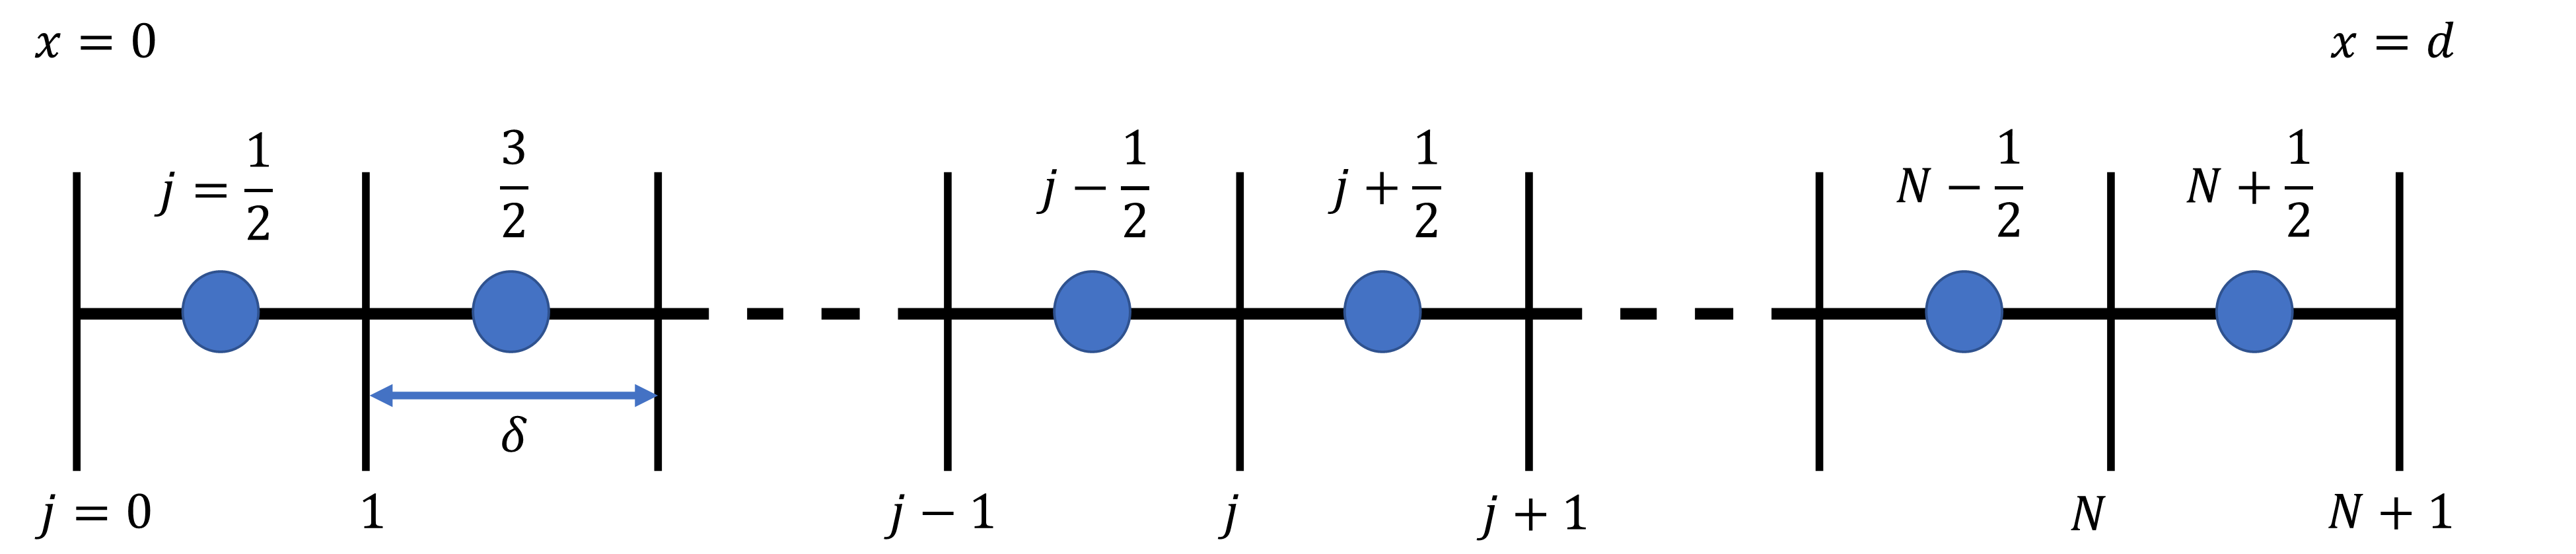

__Figure 4__: Discretisation of the active semiconductor layer into $N+1$ pieces of equal width The layer is broken into N+1 chunks of width $\delta=d_x/(N+1)$, or normalised width $\delta'=1/(N+1)$. The index $j$ refers to the position within the device, with $j=0$ and $j=N+1$ corresponding to the anode-semiconductor and semiconductor-cathode boundaries, respectively. 
<br/><br/>
&emsp;&emsp;&emsp;&emsp; By taking the respective derivates of the discretised, normalised quantities $\psi_{jk}'$, $n_{jk}'$, and $p_{jk}'$ about the integer values of j, the current densities and electric field can be determined at the points where $j\in[1/2,3/2,...,N-1/2,N+1/2]$. These parameters must be calculated in the centre of the equal-width pieces because they depend on derivates of the other parameters. For example, the current density equations depend on the first derivative of the potential and the charge carrier density with respect to position.
<br/><br/>
The function used by the script to determine the normalised chunk-width $\delta'$ is:
<br/><br/>

In [2846]:
def norm_delta( N ):
    
    """Determine the normalised width of each of the N+1 chunks of the active layer."""
    
    return 1 / ( N + 1 ) # Unitless

<a id = 'D_Poisson' ></a> 
#### 2.5.1. Discretising Poisson’s Equation
[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
To compute the current density at the point $x_j$ and to solve Poisson’s equation, the first and second derivative of the normalised electric potential $\psi_{jk}'$ with respect to the normalised position $x'$ must be computed. This is achieved by taking the Taylor expansion of the potential at various points. In general, the Taylor expansion of a function $f(x)$ about a point $a$ is [__RILEY/HOBSON ESSENTIAL MATHEMATICAL METHODS__]
<br/><br/>
\begin{equation}
\label{eq:taylor}\tag{2.5.2}
f(x)=\sum_{n=0}^\infty \frac{(x-a)^n}{n!}f^{(n)}(a),
\end{equation}
<br/><br/>
where $f^{(n)}(a)$ signifies the $n$-th derivative of the function $f(x)$ evaluated at $x=a$. For the electric potential $\psi_{jk}'=\psi'(x=x_j, t=t_k)$, the Taylor expansion about $x=x_{j-\frac{1}{2}}$ is (with $x_j - x_{j-\frac{1}{2}}=\frac{\delta'}{2}$)
<br/><br/>
\begin{equation}
\label{eq:psi_jminhalf}\tag{2.5.3}
\psi_{jk}'=\psi_{j-\frac{1}{2},\,k}'+\left(\frac{\delta'}{2}\right)\left.\frac{\partial \psi'}{\partial x'}\right|_{j-\frac{1}{2},\,k}+\left(\frac{\delta'^2}{8}\right)\left.\frac{\partial^2\psi'}{\partial x'^2}\right|_{j-\frac{1}{2},\,k}+\left(\frac{\tilde{\delta}^3}{48}\right)\left.\frac{\partial^3 \psi'}{\partial x'^3}\right|_{j-\frac{1}{2},\,k}+...
\end{equation}
<br/><br/>
By instead expanding about $x=x_{j+\frac{1}{2}}$ (with $x_j - x_{j+\frac{1}{2}}=-\frac{\delta'}{2}$), one finds that
<br/><br/>
\begin{equation}
\label{eq:psi_jplushalf}\tag{2.5.4}
\psi_{jk}'=\psi_{j+\frac{1}{2},\,k}'-\left(\frac{\delta'}{2}\right)\left.\frac{\partial \psi'}{\partial x'}\right|_{j+\frac{1}{2},\,k}+\left(\frac{\delta'^2}{8}\right)\left.\frac{\partial^2\psi'}{\partial x'^2}\right|_{j+\frac{1}{2},\,k}-\left(\frac{\tilde{\delta}^3}{48}\right)\left.\frac{\partial^3 \psi'}{\partial x'^3}\right|_{j+\frac{1}{2},\,k}+...
\end{equation}
<br/><br/>
Using these series, it can be shown that
<br/><br/>
\begin{equation}
\label{eq:psi_j_min_psi_j_min_one}\tag{2.5.4}
\psi_{jk}'-\psi_{j-1,k}'=\delta'\left.\frac{\partial \psi'}{\partial x'}\right|_{j-\frac{1}{2},\, k} + \left(\frac{\delta'^3}{24}\right)\left.\frac{\partial^3 \psi'}{\partial x'^3}\right|_{j-\frac{1}{2},\, k} + ...
\end{equation}
<br/><br/>
Making the approximation that the spacing between the points $\delta'$ is sufficiently small (or, equivalently, that the number of points in the active layer $N$ is sufficiently large), then the discretised form of the first derivative of the potential may be written as
<br/><br/>
<a id = 'dpsidx' ></a> 
\begin{equation}
\label{eq:dpsidx}\tag{2.5.6}
\left.\frac{\partial \psi'}{\partial x'}\right|_{j-\frac{1}{2},\, k}\approx\frac{\psi_{jk}'-\psi_{j-1, k}}{\delta'}.
\end{equation}
<br/><br/>
Using this discretised form of the first derivative of the potential, the discretised electric field at a point with index $j+\frac{1}{2}$ can be computed via
<br/><br/>
<a id = 'e_field_discrete' ></a> 
\begin{equation}
\label{eq:e_field_discrete}\tag{2.5.7}
\tilde{\bf{E}}_{j+\frac{1}{2}} = \frac{\psi_{jk}'-\psi_{j+1,k}'}{\delta'}.
\end{equation}
<br/><br/>
This is encoded into the drift-diffusion simulations via the following function
<br/><br/>

In [2847]:
def norm_E_field( norm_psi_vector , norm_delta ):
    
    """Determine the normalised elecric field at position j+1/2 using the electric potential vector (containing the 
    
    potential at positions j = [0,1,...,N+1]) and the normalised width delta."""
    
    return [ ( norm_psi_vector[ j ] - norm_psi_vector[ j + 1 ] ) / norm_delta for j in range( len( norm_psi_vector ) - 1 ) ]

<br/><br/>
&emsp;&emsp;&emsp;&emsp; Following an anolgous process, where Equation ([2.5.6](#dpsidx)) is shifted upwards or downwards in $j$, one can write the second derivative of the potential with respect to the normalised position $x'$ at a point $j$ as
<br/><br/>
\begin{equation}
\label{eq:d2psidx2}\tag{2.5.8}
\left.\frac{\partial^2 \psi'}{\partial {x}'^2}\right|_{j,k}\approx\frac{1}{\delta'}\left(\left.\frac{\partial \psi'}{\partial x'}\right|_{j+\frac{1}{2},\,k}-\left.\frac{\partial \psi'}{\partial x'}\right|_{j-\frac{1}{2},\,k}
\right)\approx\frac{\psi_{j-1,k}'-2\psi_{j,k}'+\psi_{j+1,k}'}{\delta'^2}.
\end{equation}
<br/><br/>
Using this discretised form of the second derivative of the potential, the discretised for of Poisson's equation is:
<br/><br/>
<a id = 'dis_poisson' ></a> 
\begin{equation}
\label{eq:dis_poisson}\tag{2.5.9}
\psi_{j-1,k}'-2\psi_{j,k}'+\psi_{j+1,k}'\approx{\delta}'^2\left(n_{jk}'-p_{jk}'\right).
\end{equation}

<a id = 'D_Currents' ></a> 
#### 2.5.2. Discretising the Current Density Equations
[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
The discretised form of the current density equation for electrons is
<br/><br/>
\begin{equation}
\label{eq:dis_jn}\tag{2.5.10}
\left.J_n'\right|_{j-\frac{1}{2},\,k}= \left.\mu_n'\right|_{j-\frac{1}{2},\,k}
\left(-n_{j-\frac{1}{2},\,k}'
\left.\frac{\partial\psi'}{\partial {x}'}\right|_{j-\frac{1}{2},\,k} + \left.\frac{\partial n'}{\partial {x}'}\right|_{j-\frac{1}{2},\,k}\right),
\end{equation}
<br/><br/>
Where $\left.\mu_n'\right|_{j-\frac{1}{2},\,k}$ is the electron mobility at point $j-\frac{1}{2}$. By multiplying both sides by $e^{-\psi'}$ and integrating, Scharfetter and Gummel derived an alternate form of this expresion for the electron current density [__SELBERHERR ANALYSIS AND SIMULATION__],
<br/><br/>
<a id = 'jn_final' ></a> 
\begin{equation}
\label{eq:dis_jn_final}\tag{2.5.11}
\left.J_n'\right|_{j-\frac{1}{2},\,k}= \frac{\left.\mu_n'\right|_{j-\frac{1}{2},\,k}}{\delta'}
\left(n_{j,k}' {\mathbb{b}} \left[\psi_{jk}'-\psi_{j-1,k}'\right]-n_{j-1,k}' {\mathbb{b}} \left[\psi_{j-1,k}'-\psi_{j,k}'\right]\right),
\end{equation}
<br/><br/>
where ${\mathbb{b}}[x]$ denotes the Bernoulli function, defined as
<br/><br/>
<a id = 'Bernoulli' ></a> 
\begin{equation}
\label{eq:Bernoulli}\tag{2.5.12}
{\mathbb{b}}[x]=\frac{x}{e^x-1}.
\end{equation}
<br/><br/>
The corresponding equation for the discretised hole current density is
<br/><br/>
<a id = 'jp_final' ></a> 
\begin{equation}
\label{eq:dis_jp_final}\tag{2.5.13}
\left.J_p'\right|_{j-\frac{1}{2},\,k}= \frac{\left.\mu_n'\right|_{j-\frac{1}{2},\,k}}{\delta'}
\left(p_{j-1,k}' {\mathbb{b}} \left[\psi_{jk}'-\psi_{j-1,k}'\right]-p_{jk}' {\mathbb{b}} \left[\psi_{j-1,k}'-\psi_{jk}'\right]\right).
\end{equation}

<a id = 'Bernoulli_Limits' ></a> 
#### 2.5.3.  Aside: Approximating the Bernoulli function
[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
To write functions for determining the discretised electron and hole current densities, it is necessary to first wrote a function to evaluate $\mathbb{b}[x]$. However, as shown below in __Figure 5__, Python struggles to precisely compute $\mathbb{b}(x)=x/(e^x-1)$ for $x<10^{-12}$. 
<br/><br/>

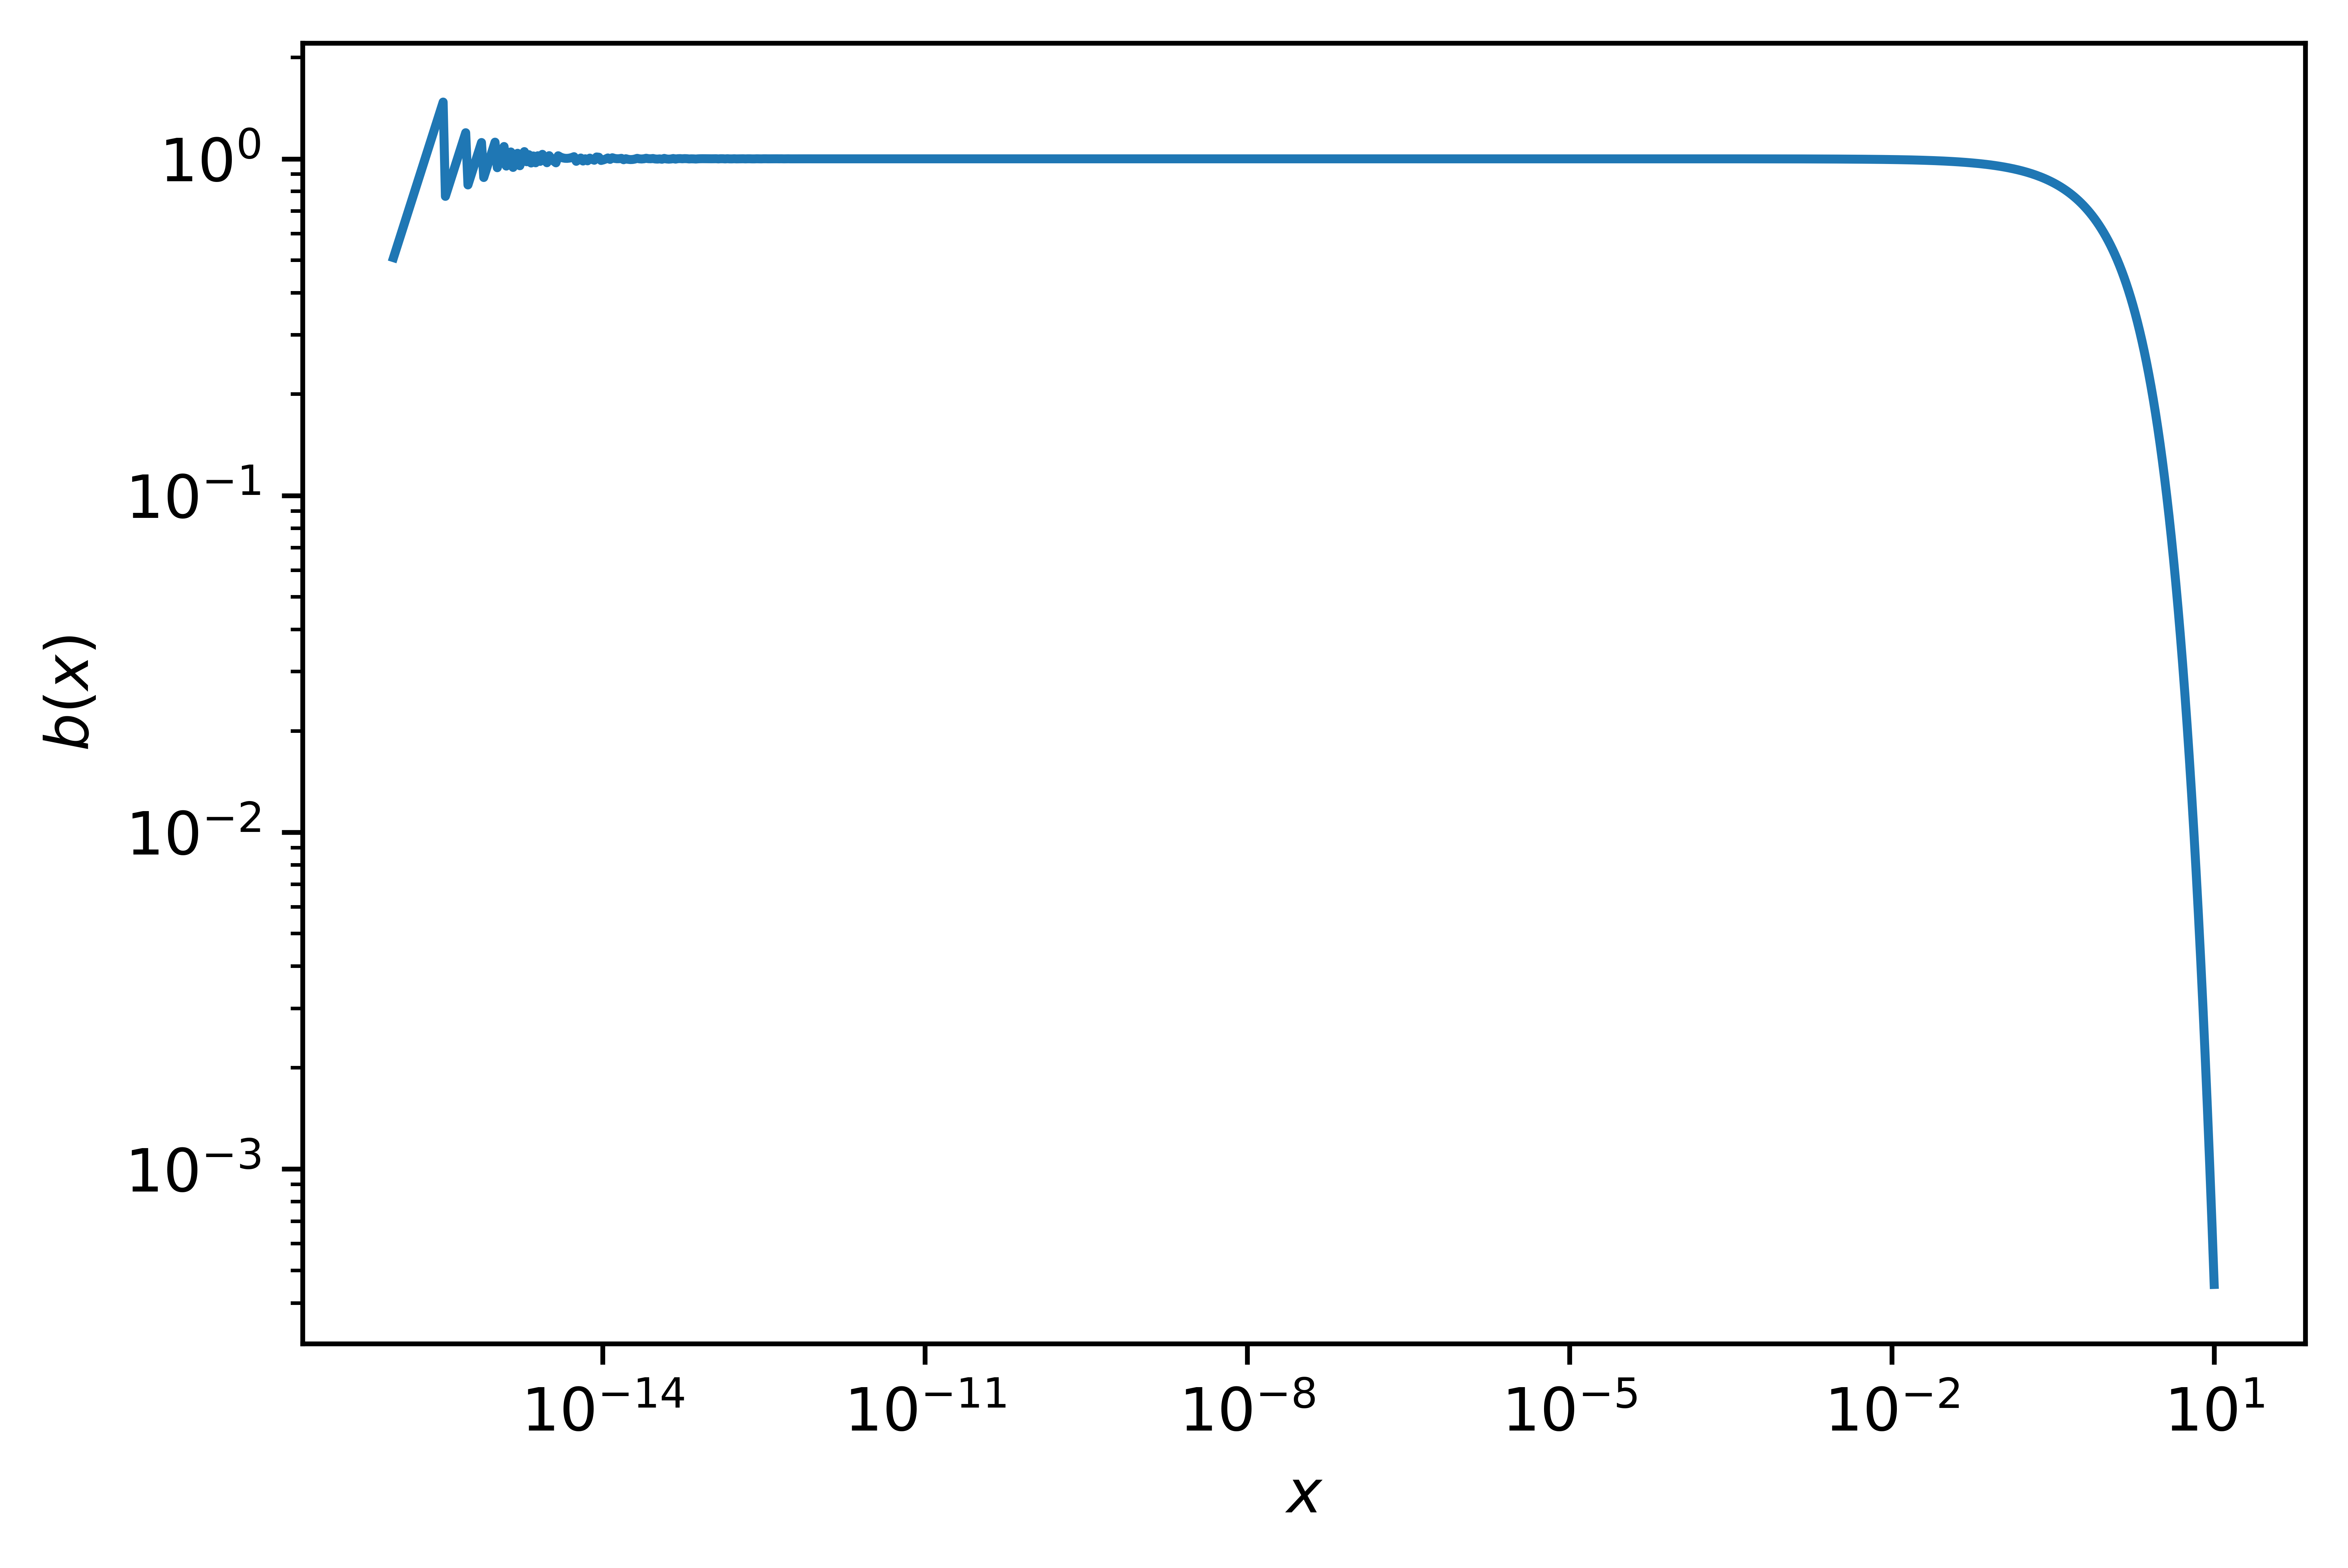

__Figure 5__: Calculating the Bernoulli function, $\mathbb{b}[x]=x/(e^x-1)$ for small arguments of $x$ using Python. Note that the function tends towards $1$ as $x\to0$, before becoming noisy for particularly small arguments.
<br/><br/>
There are two issues with calculating the Bernoulli function of small arguments of $x$; firstly, at $x=0$, $\mathbb{b}(x)$ is undetermined, and secondly, as $\mathbb{b}(x)$ has a hole at $x=0$, its Maclaurin expansion cannot be evaluated directly. The first issue is resolved by applying L'Hôpital's rule to find that the Bernoulli function tends to $1$ as $x\to0$. 
<br/><br/>
\begin{equation}
\label{eq:lhop}\tag{2.5.14}
\lim_{x\to 0}\mathbb{b}[x]=\lim_{x\to 0}\frac{x}{e^x-1}=\lim_{x\to 0}\frac{1}{e^x}=1.
\end{equation}
<br/><br/>
The Maclaurin expansion of $\mathbb{b}(x)$ can be determined by first considering the Maclaurin expansion of $e^x$,
<br/><br/>
\begin{equation}
\label{eq:e}\tag{2.5.15}
e^x=\sum_{n=0}^\infty \frac{x^n}{n!}=1+x+\frac{x^2}{2!}+\frac{x^3}{3!}+...
\end{equation}
<br/><br/>
By manipulating this series, it can be found that
<br/><br/>
\begin{equation}
\label{eq:emin1_x}\tag{2.5.16}
\frac{e^x-1}{x}=\sum_{n=0}^\infty \frac{x^n}{(n+1)!}=1+\frac{x}{2!}+\frac{x^2}{3!}+\frac{x^3}{4!}+...
\end{equation}
<br/><br/>
As the Bernoulli function is the inverse of the function on the left-hand side of the above expression, then, assuming a series expansion of $\mathbb{b}(x)$ of the form $\mathbb{b}(x)=\sum_{m=0}^\infty a_m x^m$ exists, Cauchy's product rule requires that
<br/><br/>
<a id = 'cauchy' ></a> 
\begin{equation}
\label{eq:cauchy}\tag{2.5.17}
\mathbb{b}[x]\cdot\frac{e^x-1}{x}=\sum_{m=0}^\infty a_m x^m\cdot\sum_{n=0}^\infty \frac{x^n}{(n+1)!}=\sum_{n=0}^\infty c_n x^n = 1,
\end{equation}
<br/><br/>
where the coefficients $c_n$ are given by
<br/><br/>
\begin{equation}
\label{eq:c_n}\tag{2.5.18}
c_n=\sum_{k=0}^n \frac{a_{n-k}}{(k+1)!} = 1.
\end{equation}
<br/><br/>
As the right-hand side of equation ([2.5.17](#cauchy)) is independent of $x$, it must be the case that $c_0=1$ and $c_n=0$ for $n\geq1$. Consequently, the coefficients of the power series form of the Bernoulli function must be given by
<br/><br/>
\begin{equation}
\label{eq:bernoulli_coeffs}\tag{2.5.19}
a_n=-\sum_{k=1}^n \frac{a_{n-k}}{(k+1)!}.
\end{equation}
<br/><br/>
After computing the first few terms, the Bernoulli function in the small argument limit can be expressed as
<br/><br/>
\begin{equation}
\label{eq:bernoulli_approx}\tag{2.5.20}
\mathbb{b}[x]\approx 1 - \frac{x}{2}+\frac{x^2}{12}-\frac{x^4}{720}.
\end{equation}
<br/><br/>
This approximated form of the Bernoulli function is implemented into the Python code (for small values of $x$) using the following function:
<br/><br/>

In [2848]:
def Bernoulli( x ):
    
    """Compute the Bernoulli function of the input value x, given by the ratio of x to e^x - 1."""
        
    if x == 0:
    
        return 1
    
    # Need to be able to calculate for small arguments too
    
    if -5E-2 < x < 5E-2:
        
        return 1 - x / 2 + x ** 2 / 12 - x ** 4 / 720 + x ** 6 / 30240
    
    else:
            
        return x / ( exp( x ) - 1 )

<br/><br/>
With the Bernoulli function defined, the functions for determining the electron and hole current densities at $j+\frac{1}{2}$ can now be defined as:
<br/><br/>

In [2849]:
def norm_J_n( mu_n_prime_j_plus_half, delta_prime, n_prime_j, n_prime_j_plus_1, psi_prime_j, psi_prime_j_plus_1 ):
    
    """Calculate the electron current at half-integer point x(j+1/2) in the device, using the electron densties 
    
    and electric potentials."""
    
    B_term_1 = n_prime_j_plus_1 * Bernoulli( psi_prime_j_plus_1 - psi_prime_j ) 
    
    B_term_2 = n_prime_j * Bernoulli( psi_prime_j - psi_prime_j_plus_1 ) 
    
    return mu_n_prime_j_plus_half / delta_prime * ( B_term_1 - B_term_2 )
    
def norm_J_p( mu_p_prime_j_plus_half, delta_prime, p_prime_j, p_prime_j_plus_1, psi_prime_j, psi_prime_j_plus_1 ):
    
    """Calculate the electron current at the half-integer points x(j+1/2) in the device, using the electron densties
    
    and electric potentials."""
    
    B_term_1 = p_prime_j * Bernoulli( psi_prime_j_plus_1 - psi_prime_j ) 
                     
    B_term_2 = p_prime_j_plus_1 * Bernoulli( psi_prime_j - psi_prime_j_plus_1 ) 
                     
    return mu_p_prime_j_plus_half / delta_prime * ( B_term_1 - B_term_2 )

<a id = 'D_Cont_equations' ></a> 
#### 2.5.4. Discretising the Continuity Equations
[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
Using the discretised forms of the current densities given in Equation ([2.5.11](#jn_final)) and Equation ([2.5.13](#jp_final)), the first derivatives of the electron and hole current densities with respect to the normalised position $x'$ are
<br/><br/>
\begin{equation}
\label{eq:djndx}\tag{2.5.21}
\left.\frac{\partial J_n'}{\partial x'}\right|_{j,k}\approx\frac{\left.J_n'\right|_{j+\frac{1}{2},\,k}-\left.J_n'\right|_{j-\frac{1}{2},\,k}}{\delta'}
=a_{n,jk}n_{j-1,k}'+b_{n,jk}n_{jk}'+c_{n,jk}n_{j+1,k}',
\end{equation}
<br/><br/>
and
<br/><br/>
\begin{equation}
\label{eq:djpdx}\tag{2.5.22}
\left.\frac{\partial \tilde{J}_p}{\partial\tilde{x}}\right|_{jk}\approx\frac{\left.J_p'\right|_{j+\frac{1}{2},\,k}-\left.J_p'\right|_{j-\frac{1}{2},\,k}}{\delta'}
=a_{p,jk}p_{j-1,k}'+b_{p,jk}p_{jk}'+c_{p,jk}p_{j+1,k}'.
\end{equation}
<br/><br/>
The coefficients of these discretised equations, $a_{n,jk}$, $b_{n,jk}$, $c_{n,jk}$, $a_{p,jk}$, $b_{p,jk}$, and $c_{p,jk}$, contain the information from the first derivatives of the current densities; they are defined by
<br/><br/>
\begin{equation}
\label{eq:coefficients}\tag{2.5.23}
a_{n,jk}=\frac{\left.\mu_n'\right|_{j-\frac{1}{2},\,k}}{\delta'^2}\mathbb{b}\left[\psi_{j-1,k}'-\psi_{jk}'\right],\\
b_{n,jk}=-\frac{1}{\delta'^2}\left(\left.\mu_n'\right|_{j+\frac{1}{2},\,k}
\mathbb{b}\left[\psi_{jk}'-\psi_{j+1,k}'\right]+\left.\mu_n'\right|_{j-\frac{1}{2},\,k}\mathbb{b}\left[\psi_{jk}'-\psi_{j-1,k}'\right]\right),\\
c_{n,jk}=\frac{\left.\mu_n'\right|_{j+\frac{1}{2},\,k}}{\delta'^2}\mathbb{b}\left[\psi_{j+1,k}'-\psi_{jk}'
\right],\\
a_{p,jk}=-\frac{\left.\mu_p'\right|_{j-\frac{1}{2},\,k}}{\delta'^2}\mathbb{b}\left[\psi_{jk}'-\psi_{j-1,k}'\right],\\
b_{p,jk}=\frac{1}{\delta'^2}\left(\left.\mu_p'\right|_{j+\frac{1}{2},\,k}\mathbb{b}\left[\psi_{j+1,k}'-\psi_{jk}'\right]+\left.\mu_p'\right|_{j-\frac{1}{2},\,k}\mathbb{b}\left[\psi_{j-1,k}'-\psi_{jk}'\right]\right),\\
c_{p,jk}=-\frac{\left.\mu_p'\right|_{j+\frac{1}{2},\,k}}{\delta'^2}\mathbb{b}\left[\psi_{jk}'-\psi_{j+1,k}'\right].
\end{equation}
<br/><br/>
The functions that calculate these coefficients in the drift-diffusion simulations are defined below:
<br/><br/>

In [2850]:
def Continuity_a_n( norm_mu_n_j_minus_half , norm_delta , norm_psi_j_minus_1 , norm_psi_j ):
    
    """Compute the coefficient a_n for the continuity equation for electrons."""
    
    return norm_mu_n_j_minus_half / norm_delta ** 2 * Bernoulli( norm_psi_j_minus_1  - norm_psi_j )

def Continuity_b_n( norm_mu_n_j_minus_half , norm_mu_n_j_plus_half , norm_delta , norm_psi_j_minus_1 , 
                   
                   norm_psi_j , norm_psi_j_plus_1 ):
    
    """Compute the coefficient b_n for the continuity equation for electrons."""
    
    return - ( norm_mu_n_j_minus_half * Bernoulli( norm_psi_j - norm_psi_j_minus_1 ) 
              
              + norm_mu_n_j_plus_half * Bernoulli( norm_psi_j - norm_psi_j_plus_1 ) ) / norm_delta ** 2

def Continuity_c_n( norm_mu_n_j_plus_half , norm_delta , norm_psi_j , norm_psi_j_plus_1 ):
    
    """Compute the coefficient c_n for the continuity equation for electrons."""
    
    return norm_mu_n_j_plus_half / norm_delta ** 2 * Bernoulli( norm_psi_j_plus_1  - norm_psi_j )

def Continuity_a_p( norm_mu_p_j_minus_half , norm_delta , norm_psi_j_minus_1 , norm_psi_j ):
    
    """Compute the coefficient a_p for the continuity equation for electrons."""
    
    return - norm_mu_p_j_minus_half / norm_delta ** 2 * Bernoulli( norm_psi_j - norm_psi_j_minus_1 )

def Continuity_b_p( norm_mu_p_j_minus_half , norm_mu_p_j_plus_half , norm_delta , norm_psi_j_minus_1 , 
                   
                   norm_psi_j , norm_psi_j_plus_1 ):
    
    """Compute the coefficient b_p for the continuity equation for electrons."""
    
    return ( norm_mu_p_j_minus_half * Bernoulli( norm_psi_j_minus_1 - norm_psi_j )  + 
            
            norm_mu_p_j_plus_half * Bernoulli( norm_psi_j_plus_1 - norm_psi_j ) ) / norm_delta ** 2

def Continuity_c_p( norm_mu_p_j_plus_half , norm_delta , norm_psi_j , norm_psi_j_plus_1 ):
    
    """Compute the coefficient c_p for the continuity equation for electrons."""
    
    return - norm_mu_p_j_plus_half / norm_delta ** 2 * Bernoulli( norm_psi_j - norm_psi_j_plus_1 )

<br/><br/>
An alternative form to these coefficients is herein employed is; it is less computationally expensive to evaluate (as it avoids multiple uses of the Bernoulli function) is
\begin{equation}
\label{eq:coefficients}\tag{2.5.24}
a_{n,jk}=\left.\mu_n'\right|_{j-\frac{1}{2},\,k}\mathbb{b}_1^\prime,\\
b_{n,jk}=-\left.\mu_n'\right|_{j-\frac{1}{2},\,k}\mathbb{b}_3^\prime-\left.\mu_n'\right|_{j+\frac{1}{2},\,k}\mathbb{b}_4^\prime,\\
c_{n,jk}=\left.\mu_n'\right|_{j+\frac{1}{2},\,k}\mathbb{b}_2^\prime,
\end{equation}

\begin{equation}
a_{p,jk}=-\left.\mu_p'\right|_{j-\frac{1}{2},\,k}\mathbb{b}_3^\prime,\\
b_{p,jk}=\left.\mu_p'\right|_{j-\frac{1}{2},\,k}\mathbb{b}_1^\prime+\left.\mu_p'\right|_{j+\frac{1}{2},\,k}\mathbb{b}_2^\prime,\\
c_{p,jk}=-\left.\mu_p'\right|_{j+\frac{1}{2},\,k}\mathbb{b}_4^\prime.
\end{equation}

<br/><br/>
where the alternate, normalised forms for the Bernoulli coefficeints are 
$$\tag{2.5.25}
\mathbb{b}_1^\prime = \frac{1}{\delta'^2}\mathbb{b}\left[\psi_{j-1,k}'-\psi_{jk}'\right],\\
\mathbb{b}_2^\prime = \frac{1}{\delta'^2}\mathbb{b}\left[\psi_{j+1,k}'-\psi_{jk}'\right],\\
\mathbb{b}_3^\prime = \frac{1}{\delta'^2}\mathbb{b}\left[\psi_{jk}'-\psi_{j-1,k}'\right]=\exp\left(\psi_{j-1,k}'-\psi_{jk}'\right)\mathbb{b}_1^\prime,\\
\mathbb{b}_4^\prime = \frac{1}{\delta'^2}\mathbb{b}\left[\psi_{jk}'-\psi_{j+1,k}'\right]=\exp\left(\psi_{j+1,k}'-\psi_{jk}'\right)\mathbb{b}_2^\prime.
$$
<br/><br/>

In the latter two coefficeints, $e^x\mathbb{b}[x]=\mathbb{b}[-x]$ has been used. These coefficients are evaluated using the following functions:
<br/><br/>


In [2851]:
def Bernoulli_prime_1( psi_j_minus_1 , psi_j , delta_prime ):
    
    """Determine the term Bernoulli_prime_1."""
    
    return Bernoulli( psi_j_minus_1 - psi_j ) / delta_prime ** 2

def Bernoulli_prime_2( psi_j_plus_1 , psi_j , delta_prime ):
    
    """Determine the term Bernoulli_prime_2."""
    
    return Bernoulli( psi_j_plus_1 - psi_j ) / delta_prime ** 2

def Bernoulli_prime_3( psi_j_minus_1 , psi_j , Bernoulli_prime_1_value ):
    
    """Determine the term Bernoulli_prime_3 using Bernoulli_prime_1."""

    return exp( psi_j_minus_1 - psi_j ) * Bernoulli_prime_1_value

def Bernoulli_prime_4( psi_j_plus_1 , psi_j , Bernoulli_prime_2_value ):
    
    """Determine the term Bernoulli_prime_4 using Bernoulli_prime_2."""
    
    return exp( psi_j_plus_1 - psi_j ) * Bernoulli_prime_2_value    

<br/><br/>
Using these functions, the normalised Bernoulli terms can be evaluated. The coefficients of the continuity equations can then, in this alternative approach, be determined using the following functions:
<br/><br/>

In [2852]:
def Alt_Continuity_a_n( mu_n_j_min_half , Bernoulli_prime_1_value ):
    
    """Determine the a_n coefficient of the electron continuity equation using the alternative approach."""
    
    return mu_n_j_min_half * Bernoulli_prime_1_value

def Alt_Continuity_b_n( mu_n_j_min_half , mu_n_j_plus_half , Bernoulli_prime_3_value , Bernoulli_prime_4_value ):
    
    """Determine the b_n coefficient of the electron continuity equation using the alternative approach."""
    
    return - mu_n_j_min_half * Bernoulli_prime_3_value - mu_n_j_plus_half * Bernoulli_prime_4_value

def Alt_Continuity_c_n( mu_n_j_plus_half , Bernoulli_prime_2_value ):
    
    """Determine the c_n coefficient of the electron continuity equation using the alternative approach."""
    
    return mu_n_j_plus_half * Bernoulli_prime_2_value

def Alt_Continuity_a_p( mu_p_j_min_half , Bernoulli_prime_3_value ):
    
    """Determine the a_p coefficient of the hole continuity equation using the alternative approach."""
    
    return - mu_p_j_min_half * Bernoulli_prime_3_value

def Alt_Continuity_b_p( mu_p_j_min_half , mu_p_j_plus_half , Bernoulli_prime_1_value , Bernoulli_prime_2_value ):
    
    """Determine the b_p coefficient of the hole continuity equation using the alternative approach."""
    
    return mu_p_j_min_half * Bernoulli_prime_1_value + mu_p_j_plus_half * Bernoulli_prime_2_value

def Alt_Continuity_c_p( mu_p_j_plus_half , Bernoulli_prime_4_value ):
    
    """Determine the c_p coefficient of the hole continuity equation using the alternative approach."""
    
    return - mu_p_j_plus_half * Bernoulli_prime_4_value

<br/><br/>
The time-derivative of the normalised electron density across a suitably small (normalised) time jump $\Delta t'=\Delta t/t_{\mathrm{norm}}$ being
<br/><br/>
$$\tag{2.5.26}
\left.\frac{\partial n'}{\partial t'}\right|_{jk}\approx \frac{n_{jk}'-n_{j,k-1}'}{\Delta t'},
$$
<br/><br/>
where $n_{jk}'$ indicates the current density at the position with index $j$ at time $k$, the current time, and $n_{j,k-1}'$ is the current density determined at the last time, $k-1$. This is essentially the same approach as used in the discretisation of the first derivative of the potential with respect to the normalised position $x'$. Combining all these ingredients gives the discretised continuity equation for electrons
<br/><br/>
\begin{equation}
\frac{n_{jk}'-n_{j,k-1}'}{\Delta t'} =a_{n,jk}n_{j-1,k}'+b_{n,jk}n_{jk}'+c_{n,jk}n_{j+1,k}'
 + \left(G_{jk}' - R_{jk}'\right).
\tag{2.5.27}
\end{equation}
<br/><br/>
Similarly, the discretised continuity equation for holes reads as
<br/><br/>
$$\tag{2.5.28}
\frac{p_{jk}'-p_{j,k-1}'}{\Delta t'} =-a_{p,jk}p_{j-1,k}'-b_{p,jk}p_{jk}'-c_{p,jk}p_{j+1,k}'
 +\left(G_{jk}' - R_{jk}'\right).
$$
<br/><br/>
The quantities with time index $k-1$ are fixed from the previous iteration. In the steady state, the carrier densities do not change in time; these equations may be rearranged as
<br/><br/>
\begin{equation}
0=a_{n,jk}n_{j-1,k}'+b_{n,jk}n_{jk}'+c_{n,jk}n_{j+1,k}'+ \left(G_{jk}' - R_{jk}'\right).
\tag{2.5.29}
\end{equation}
<br/><br/>
$$\tag{2.5.30}
0 = - a_{p,jk}p_{j-1,k}'-b_{p,jk}p_{jk}'-c_{p,jk}p_{j+1,k}'
 +\left(G_{jk}' - R_{jk}'\right).
$$
<br/><br/>
While in the case of a transient simulation, the continuity equations can be solved in the following forms 
<br/><br/>
\begin{equation}
 0 =a_{n,jk}n_{j-1,k}'+\left(b_{n,jk} -\frac{1}{\Delta t'}\right)n_{jk}'+c_{n,jk}n_{j+1,k}'
 + \left(G_{jk}' - R_{jk}'+ \frac{n_{j,k-1}'}{\Delta t'}\right).
\tag{2.5.31}
\end{equation}
<br/><br/>
Similarly, the discretised (transient) continuity equation for holes is
<br/><br/>
$$\tag{2.5.32}
0 =-a_{p,jk}p_{j-1,k}'-\left(b_{p,jk}+\frac{1}{\Delta t'}\right)p_{jk}'-c_{p,jk}p_{j+1,k}'
 +\left(G_{jk}' - R_{jk}'+\frac{p_{j,k-1}'}{\Delta t'}\right).
$$
<br/><br/>
In the case of a transient simulation, the following corrections to the $b$ and the solution vector:
<br/><br/>

In [2853]:
def Transient_Continuity_b_n_Corrected( b_n , Delta_t_prime ):
    
    """Compute the coefficient b_n for the continuity equation for electrons."""
    
    return b_n - 1 / Delta_t_prime

def Transient_Continuity_b_p_Corrected( b_p , Delta_t_prime ):
    
    """Compute the coefficient b_p for the continuity equation for electrons."""
    
    return b_p + 1 / Delta_t_prime

<a id = 'I' ></a> 
### 2.6. Iteration and Convergence
[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
The drift-diffusion simulations determine the normalised time- and position-dependent electric potential, $\psi_{j,k}'$, electron density $n_{j,k}'$, and hole density $p_{j,k}'$ using an iterative process. From these parameters, the electric field and the electron and hole current densities can be determined.
<br/><br/>
&emsp;&emsp;&emsp;&emsp; The iterative process works by starting with some intial estimates for the normalised electric potential and the normalised electron and hole densities; let these be $\psi_{j,k,l=0}'$, $n_{j,k,l=0}'$, and $p_{j,k,l=0}'$, respectively, where $l$ indicates the iteration number. Assuming linearly-varying behaviour in the potential across the diode, these estimates are made using the following functions:
<br/><br/>

In [2854]:
def psi_estimate( norm_psi_0 , norm_psi_d , N_points ):
    
    """Estimate the potential at each of the N+2 points in the diode, with the zeroth point being the anode-semiconductor
    
    boundary, and the final point being thmiconductor-cathode boundary."""
    
    return linspace( float( norm_psi_0 ) , float( norm_psi_d ) , int( N_points ) + 2 )

def n_estimate( norm_n_0 , norm_n_d , N_points):
    
    """Estimate the electron density at each of the N+2 points in the diode, with the zeroth point being the anode-
    
    semiconductor boundary, and the final point being the semiconductor-cathode boundary. Assume exponentially-increasing 
    
    behaviour."""
    
    return logspace( log10( float( norm_n_0 ) ) , log10( float( norm_n_d ) ) , int( N_points ) + 2 )

def p_estimate( norm_p_0 , norm_p_d , N_points ):
    
    """Estimate the hole density at each of the N+2 points in the diode, with the zeroth point being the anode-
    
    semiconductor boundary, and the final point being the semiconductor-cathode boundary. Assume exponentially-increasing 
    
    behaviour."""
    
    return logspace( log10( float( norm_p_0 ) ) , log10( float( norm_p_d ) ) , int( N_points ) + 2 )

<br/><br/>
The iterative process operates as follows: With a current value for the $l$-th iteration of the normalised electric potential, $\psi_{j,k,l}'$, in-hand, then, assuming that after plugging this into Poisson's equation and solving we find a new, more-accurate solution $\psi_{j,k,l+1'}$, the next iteration will differ from the current by 
<br/><br/>
\begin{equation}
\label{eq:deltapsi}\tag{2.6.1}
\psi_{j,k,l+1}' = \psi_{j,k,l}' + (\Delta \psi')_{j,k,l},
\end{equation}
<br/><br/>
where $(\Delta\psi')_{j,k,l}$ is a small correction to the current value of the electric potential. Assuming a roughly exponential dependence between the charge carrier densities and the potential (as seen in thermal equilibrium), the corresponding changes to $n'$ and $p'$ are assumed to be of the form
<br/><br/>
\begin{equation}
\label{eq:delta_np}\tag{2.6.2}
n_{j,k,l+1}' = n_{j,k,l}'e^{(\Delta\psi')_{j,k,l}}\approx n_{j,k,l}'\left(1+\psi_{j,k,l+1}' - \psi_{j,k,l}'\right),\\
p_{j,k,l+1}' = p_{j,k,l}'e^{-(\Delta\psi')_{j,k,l}}\approx p_{j,k,l}'\left(1-\psi_{j,k,l+1}' + \psi_{j,k,l}'\right).
\end{equation}
<br/><br/>
Substituting these approximations into the discretised form of Poisson's equation,
<br/><br/>
\begin{equation}
\label{eq:solving_dis_poisson}\tag{2.6.3}
\psi_{j-1,k,l+1}'-2\psi_{j,k,l+1}'+\psi_{j+1, k, l+1}'\approx\delta'^2\left(\tilde{n}_{j,k,l+1}-\tilde{p}_{j,k,l+1}\right)
\\=\delta'^2\left(n_{j,k,l}'\left(1+\psi_{j,k,l+1}' - \psi_{j,k,l}'\right)-p_{j,k,l}'\left(1-\psi_{j,k,l+1}' + \psi_{j,k,l}' \right)\right).
\end{equation}
<br/><br/>
Collecting the terms corresponding to the $(l+1)$-th iteration on the left-hand side and the terms correpsonding to the (current) $l$-th iteration on the right-hand side,
<br/><br/>
<a id = 'solving_dis_poisson2' ></a> 
\begin{equation}
\label{eq:solving_dis_poisson2}\tag{2.6.4}
\psi_{j-1,k,l+1}'+\theta_{j,k,l}\psi_{j,k,l+1}'+\psi_{j+1, k, l+1}'\approx\phi_{j,k,l}.
\end{equation}
<br/><br/>
Here, the coefficients $\theta_{j,k,l}=-\left(2+\delta'^2\left[n_{j,k,l}'+p_{j,k,l}'\right]\right)$ and $\phi_{j,k,l}=\delta'^2\left(n_{j,k,l}'-p_{j,k,l}'-\left[ n_{j,k,l}'+ p_{j,k,l}'\right]\psi_{j,k,l}'\right)$ depend on known quantities from the current ($l$-th) iteration. These coefficients are implemented into the Python code using the following functions:

In [2855]:
def Poisson_theta( delta_prime , n_prime , p_prime ):
    
    """Compute the parameter theta_jkl using the electron ( n ) and hole ( p ) densities of the current iteration l, where 
    
    j indicates the current position and k indicates the current time. The parameter delta indicates the separation between 
    
    points in the active layer."""
    
    return - ( 2 + delta_prime ** 2 * ( n_prime + p_prime ) )

def Poisson_phi( delta_prime , n_prime , p_prime , psi_prime ):
    
    """Compute the parameter phi_jkl using the electron and hole densities of the current iteration l, where j indicates 
    
    the current position and k indicates the current time. The parameter delta indicates the separation between points in 
    
    the active layer."""
    
    return delta_prime ** 2 * ( n_prime - p_prime - ( n_prime + p_prime ) * psi_prime )

## <a id = 'tridiag' ></a> 
#### 2.6.1. Solving Tridiagonal Matrices - The Thomas Algorithm
[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
In the remainder of this Section, it will be shown that solving the discretised Poisson equation, as well as solving the continuity equations to determine the next iteration of $\psi'$, $n$, and $p$, essentially boils down to solving $N$ coupled equations of the form $a_ix_{i-1}+b_ix_i+c_ix_{i+1}=d_i$, which can be expressed as an $N\times N$-dimensional tridiagonal matrix multiplying a vector:
<br/><br/>
\begin{equation}
\label{eq:tridiag}\tag{2.6.5}
\begin{pmatrix}
b_1 & c_1 & 0 & ... & ... & ... & 0 \\
a_2 & b_2 & c_2 & 0 & ... & ... &  0 \\
0 & a_3 & b_3 & c_3 & 0 & ... & 0 \\
\vdots & \ddots & \ddots & \ddots & \ddots & \ddots & \vdots \\
0 & ... & 0 & a_{N-2} & b_{N-2} & c_{N-2} & 0 \\
0 & ... & ... & 0 & a_{N-1} & b_{N-1} & c_{N-1} \\
0 & ... & ... & ... & 0 & a_{N-1} & b_{N-1} \\
\end{pmatrix}
\begin{pmatrix}
x_1\\
x_2\\
x_3\\
\vdots\\
x_{N-2}\\
x_{N-1}\\
x_{N}\\
\end{pmatrix}
=\begin{pmatrix}
d_1\\
d_2\\
d_3\\
\vdots\\
d_{N-2}\\
d_{N-1}\\
d_{N}\\
\end{pmatrix},
\end{equation}
<br/><br/>
where the terms $d_1$ and $d_N$ have "absorbed" what are taken to be boundary conditions, $a_1x_0$ and $c_Nx_{N+1}$. Such matrices are solved by first solving the first row, and then the second, and so on.... In other words, the final row is solved using the solution of all prior rows.
<br/><br/>
&emsp;&emsp;&emsp;&emsp; In general, after solving the $(i-1)$-th row, the $i$-th row of the matrix is solved by substituting in $x_{i-1}$ and rearranging for $x_i$ in terms of $x_{i+1}$, which would be substituted into the $(i+1)$-th row and so on until the final row is reached. It is therefore intuitive to define a new set of parameters, $b_i^\prime$, $c_i^\prime$, and $d_i^\prime$, such that each row is of the general form
<br/><br/>
<a id = 'generaltridiag' ></a> 
\begin{equation}
\label{eq:new_coefs}\tag{2.6.6}
b_i^\prime x_i +c_i^\prime x_{i+1} = d_i^\prime.
\end{equation}
<br/><br/>
For $i=1$, this is simply $b_1^\prime = b_1$, $c_1^\prime = c_1$, and $d_1^\prime = d_1$, giving $b_1 x_1 +c_1 x_{2} = d_1$. Upon substitution into the second row, one finds that
<br/><br/>
\begin{equation}
\label{eq:new_coefs2}\tag{2.6.7}
(b_1b_2-a_2c_1) x_2+ (b_1c_2) x_{3} = b_1d_2 - a_2d_1.
\end{equation}
<br/><br/>
Consequently, $b_2^\prime = b_1b_2-a_2c_1$, $c_2^\prime = b_1c_2$, and $d_1^\prime = b_1d_2-a_2d_1$. In general, it is therefore the case that (for $i>1$)
<br/><br/>
\begin{equation}
\label{eq:generaltridia}\tag{2.6.8}
b_i^\prime = b_{i-1}^\prime b_i - a_i c_{i-1}^\prime,\\
c_i^\prime = b_{i-1}^\prime c_i,\\
d_i^\prime = b_{i-1}^\prime d_i - a_i d_{i-1}^\prime.\\
\end{equation}
<br/><br/>
These expressions can be further simplified in the case that $b_i^\prime\neq0$ by dividing equation ([2.34](#generaltridiag)) throughout by $b_i^\prime$, giving
<br/><br/>
\begin{equation}
\label{eq:simplified_tridiag}\tag{2.6.9}
x_i +c_i^{\prime\prime} x_{i+1} = d_i^{\prime\prime},
\end{equation}
<br/><br/>
where
<br/><br/>
\begin{equation}
\label{eq:cpprime}\tag{2.6.10}
c_i^{\prime\prime} = \frac{c_i^{\prime}}{b_i^{\prime}}=\begin{cases}
\frac{c_i}{b_i}, & \mathrm{ if } & i = 1,\\
\frac{c_i}{b_i-c_{i-1}^{\prime\prime}a_i}, & \mathrm{ if } & i = 2,3,...,N,\\
\end{cases},
\end{equation}
<br/><br/>
and
<br/><br/>
\begin{equation}
\label{eq:dpprime}\tag{2.6.11}
d_i^{\prime\prime} = \frac{d_i^{\prime}}{b_i^{\prime}}=\begin{cases}
\frac{d_i}{b_i}, & \mathrm{ if } & i = 1,\\
\frac{d_i-d_{i-1}^{\prime\prime}}{b_i-c_{i-1}^{\prime\prime}a_i}, & \mathrm{ if } & i = 2,3,...,N,\\
\end{cases}.
\end{equation}
<br/><br/>
By computing $c_i^{\prime\prime}$ and $d_i^{\prime\prime}$ from $i=1$ up to $i=N$, $x_N=d_N^{\prime\prime}$ can be determined. Then, by back-substitution, one can determine the other solutions using (for $i = N-1, N-2, ..., 1$).
<br/><br/>
\begin{equation}
\label{eq:triadiag_final}\tag{2.6.12}
x_i= d_i^{\prime\prime} - c_i^{\prime\prime}x_{i+1}.
\end{equation}
<br/><br/>
The triadiagonal matrix-solving algorithm is now implemented into the drift-diffusion code using the following function:
<br/><br/>

In [2856]:
def TriDiSolver( Lower_Diagonals , Middle_Diagonals , Upper_Diagonals , Solution_Vector ):
    
    """Algorithm for solving the N coupled equations of an N-sized system. Here, 'solution_vector' is the N-dimensional 
    
    vector of known "solutions" and the diagonal vectors describe the matrix."""
    
    N_rows = len( Solution_Vector )
    
    c_primes = []
    d_primes = []
    
    for i in range( N_rows ):
        
        if i == 0:
            
            c_primes.append( Upper_Diagonals[ i ] / Middle_Diagonals[ i ] )
            d_primes.append( Solution_Vector[ i ] / Middle_Diagonals[ i ] )
            
        else:
            
            if i < N_rows - 1:
            
                Denominator = Middle_Diagonals[ i ] - Lower_Diagonals[ i - 1 ] * c_primes[ -1 ]
                
                c_primes.append( Upper_Diagonals[ i ] / Denominator )
                d_primes.append( ( Solution_Vector[ i ] - Lower_Diagonals[ i - 1 ] * d_primes[ -1 ] ) / Denominator )
            
            else:
                
                Denominator = Middle_Diagonals[ i ] - Lower_Diagonals[ i - 1 ] * c_primes[ -1 ]    
            
                d_primes.append( ( Solution_Vector[ i ] - Lower_Diagonals[ i - 1 ] * d_primes[ -1 ] ) / Denominator )
                
    Output_xs = [ 1 for i in range( N_rows ) ]
    
    Output_xs[ -1 ] = d_primes[ - 1 ] 
    
    for i in range( 1 , N_rows ):

        Output_xs[ -1 - i ] = d_primes[ -1 - i ] - c_primes[ - i ] * Output_xs[ - i ]   

    return Output_xs

<a id = 'iterating_poisson' ></a> 
#### 2.6.2. Iterating Poisson's Equation
[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
Using the values of the current iteration for the normalised electric potential $\psi_{j,k,l}'$, the normalised electron density $n_{j,k,l}'$ and the normalised hole density $p_{j,k,l}'$, the next iteration of the electric potential $\psi_{j,k,l+1}'$ can be calculated using the tridiagonal matrix-solving algorithm above. For all points across the diode, this is done using the following function: 
<br/><br/>

In [2857]:
def Poisson_Equation_Solver( N, delta_prime, psis, ns, ps ):
    
    """Use the tridiagonal matrix-solving algorithm to solve the Poisson equation for all points in the active layer. Do 
    
    this using the normalised electron densities (ns), hole densities (ps), and potentials (psis) of the current iteration
    
    to determine the potentials of the next iteration and the differences."""
        
    #-----------------------------------------------------------------------------------------------------------------------
    # Determine Diagonal Components of Tri-Diagonal Matrix
    #-----------------------------------------------------------------------------------------------------------------------
    
    # The diagonal components run from j = 1 to j = N, hence the j + 1 in the following 
    
    Thetas = [ Poisson_theta( delta_prime , ns[ j + 1 ] , ps[ j + 1 ] ) for j in range( N ) ]
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Determine Solution Vector
    #-----------------------------------------------------------------------------------------------------------------------
     
    Phis = [ Poisson_phi( delta_prime , ns[ j + 1 ] , ps[ j + 1 ] , psis[ j + 1 ] ) for j in range( N ) ]   
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Correct Solution Vector to Include Boundary Conditions
    #-----------------------------------------------------------------------------------------------------------------------
        
    Phis[ 0 ] -= psis[ 0 ] 
    
    Phis[ -1] -= psis[ -1 ]

    #-----------------------------------------------------------------------------------------------------------------------
    # Determine Off-Diagonal Components Vector
    #-----------------------------------------------------------------------------------------------------------------------
    
    Ones = [ 1 for i in range( N - 1 ) ] 
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Solve and Return
    #-----------------------------------------------------------------------------------------------------------------------
    
    return array( [ psis[ 0 ] ] + TriDiSolver( Ones, Thetas, Ones, Phis ) + [ psis[ -1 ] ] )

<br/><br/>
<a id = 'iterating_continuity' ></a> 
#### 2.6.3. Iterating the Continuity Equations
[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
With Poisson's equation solved and a new iteration of the normalised electric potential $\psi_{j,k,l+1}'$ determined, the continuity equations can now be solved to determine the next iteration of the charge carrier densities $n_{j,k,l+1}'$ and $p_{j,k,l}'$; these are determined by calcuating the coefficients $a_{n,j,k,l+1}, a_{p,j,k,l+1},$ etc, using $\psi_{j,k,l+1}'$. Assuming (for now) a transient simulation with finite normalised time step $\Delta t'$, then the continuity equations may be rewritten as 

\begin{equation}
a_{n,j,k,l}n_{j-1,k,l}'+\left(b_{n,j,k,l} -\frac{1}{\Delta t'}\right)n_{j,k,l}'+c_{n,j,k,l}n_{j+1,k,l}'
=- \left(G_{j,k,l}' - R_{j,k,l}'+ \frac{n_{j,k-1}'}{\Delta t'}\right).
\tag{2.6.13}
\end{equation}
<br/><br/>
Similarly, the discretised (transient) continuity equation for holes is
<br/><br/>
$$\tag{2.6.14}
a_{p,j,k,l}p_{j-1,k,l}'+\left(b_{p,j,k,l}+\frac{1}{\Delta t'}\right)p_{j,k,l}'+c_{p,j,k,l}p_{j+1,k,l}'
=\left(G_{j,k,l}' - R_{j,k,l}'+\frac{p_{j,k-1}'}{\Delta t'}\right).
$$
<br/><br/>
Note that the carrier densities from the previous time step ($k-1$) are fixed for this iteration; they do not depend on the iteration index $l$.
<br/><br/>
<br/><br/>
As the normalised net generation rate is 
<br/><br/>
$$\tag{2.6.15}
G_{j,k,l}'-R_{j,k,l}' = G_{\mathrm{light},j,k}' - \gamma\left(\mu_{n,j,k}'+\mu_{p,j,k}'\right)\left[n_{j,k,l}'p_{j,k,l}'-n_\mathrm{int}'^2\right],
$$
<br/><br/>
where $l$ is the iteration number, then the numerically-stability of the simulations is improved upon by solving the continuity equations one at a time. Specifically, the continuity equations for electrons is solved first using the hole density from the previous iteration
<br/><br/>
$$\tag{2.6.16}
G_{j,k,l}'-R_{j,k,l}' = G_{\mathrm{light},j,k}' -\gamma\left(\mu_{n,j,k}'+\mu_{p,j,k}'\right)\left[n_{j,k,l}'p_{j,k,l-1}'-n_\mathrm{int}'^2\right],
$$
<br/><br/>
which allows the continuity equation to be rewritten as 
<br/><br/>
\begin{equation}
a_{n,j,k,l}n_{j-1,k,l}'+b_{n,j,k,l}'n_{j,k,l}'+c_{n,j,k,l}n_{j+1,k,l}'
=d_{n,j,k,l}'
\tag{2.6.17}
\end{equation}
<br/><br/>
where the new 
<br/><br/>
$$\tag{2.6.18}
b_{n,j,k,l}' = b_{n,j,k,l} -\frac{1}{\Delta t'}-\gamma\left(\mu_{n,j,k}'+\mu_{p,j,k}'\right)p_{j,k,l-1}' 
$$
<br/><br/>
and 
<br/><br/>
$$\tag{2.6.19}
d_{n,j,k,l}'=- \left(
G_{\mathrm{light},j,k}' +\gamma\left(\mu_{n,j,k}'+\mu_{p,j,k}'\right)n_\mathrm{int}'^2+ \frac{n_{j,k-1}'}{\Delta t'}\right).
$$
<br/><br/>
These parameters are determined using the following functions: 
<br/><br/>

In [2858]:
def Continuity_b_n_prime( b_n , mu_n_prime_j , mu_p_prime_j , gamma , p_j_prior, Transient, Delta_t_prime ):
    
    """Compute the coefficient b_n' for the continuity equation for electrons. The expected inputs are the coefficient
    
    b_n, the mobilities at position j, the reduction factor (gamma), the hole density at point j from the prior iteration,
    
    whether or not the simulation is transient (a Boolean), and the time step if it is transient. If the simulation is not
    
    transient, input any random number for Delta_t_prime to allow the function to operate."""
    
    if Transient == True:
        
        return b_n - gamma * ( mu_n_prime_j + mu_p_prime_j ) * p_j_prior - 1 / Delta_t_prime
    
    else:
    
        return b_n - gamma * ( mu_n_prime_j + mu_p_prime_j ) * p_j_prior

def Continuity_d_n_prime( G_light_prime , gamma , mu_n_prime_j , mu_p_prime_j , n_int_prime_squared, Transient, 
                         
                         n_j_prime_k_min_1, Delta_t_prime ):
    
    """Compute the coefficient d_n' for the continuity equation for electrons. The expected inputs are the normalised
    
    generation rate under illumination, the mobilities at position j, the reduction factor (gamma), the square of the 
    
    normalised, intrinsic carrier density, whether or not the simulation is transient (a Boolean), and the electron density
    
    and time step if it is. If the simulation is not transient, input any random number for Delta_t_prime and the carrier 
    
    density from the previous time to allow the function to operate."""
        
    if Transient == True:
        
        return - G_light_prime - gamma * ( mu_n_prime_j + mu_p_prime_j ) * n_int_prime_squared - n_j_prime_k_min_1 / Delta_t_prime
        
    else:
        
        return - G_light_prime - gamma * ( mu_n_prime_j + mu_p_prime_j ) * n_int_prime_squared

<br/><br/>
After solving the continuity equation for the electron current density, $n_{j,k,l}$ becomes a known parameter. By now writing the net generation rate as
<br/><br/>
$$\tag{2.6.20}
G_{j,k,l}'-R_{j,k,l}' = G_{\mathrm{light},j,k}' -\gamma\left(\mu_{n,j,k}'+\mu_{p,j,k}'\right)\left[n_{j,k,l}'p_{j,k,l}'-n_\mathrm{int}'^2\right],
$$
<br/><br/>
Then the discretised (transient) continuity equation for holes can be written in its final form:
<br/><br/>
$$\tag{2.6.21}
a_{p,j,k,l}p_{j-1,k,l}'+
b_{p,j,k,l}'p_{j,k,l}'+c_{p,j,k,l}p_{j+1,k,l}'
=d_{p,j,k,l}',
$$
<br/><br/>
where
<br/><br/>
$$\tag{2.6.22}
b_{p,j,k,l}'=b_{p,j,k,l}+\frac{1}{\Delta t'}+\gamma\left(\mu_{n,j,k}'+\mu_{p,j,k}'\right)n_{j,k,l}',
$$
<br/><br/>
and
<br/><br/>
$$\tag{2.6.23}
d_{p,j,k,l}'=G_{\mathrm{light},j,k}'+\gamma\left(\mu_{n,j,k}'+\mu_{p,j,k}'\right)n_\mathrm{int}'^2+\frac{p_{j,k-1}'}{\Delta t'}.
$$
<br/><br/>
These coefficients are calculated using the following functions:
<br/><br/>

In [2859]:
def Continuity_b_p_prime( b_p , mu_n_prime_j, mu_p_prime_j, gamma, n_j_prime, Transient, Delta_t_prime):
  
    """Compute the coefficient b_p' for the continuity equation for holes. The expected inputs are the coefficient
    
    b_p, the mobilities at position j, the reduction factor (gamma), the electron density at point j from the current 
    
    iteration, whether or not the simulation is transient (a Boolean), and the time step if it is transient. If the 
    
    simulation is not transient, input any random number for Delta_t_prime to allow the function to operate."""
    
    if Transient == True:
        
        return b_p + gamma * ( mu_n_prime_j + mu_p_prime_j ) * n_j_prime + 1 / Delta_t_prime

    else:
        
        return b_p + gamma * ( mu_n_prime_j + mu_p_prime_j ) * n_j_prime
    
    
def Continuity_d_p_prime( G_light_prime , gamma , mu_n_prime_j , mu_p_prime_j , n_int_prime_squared, Transient, 
                         
                         p_j_prime_k_min_1, Delta_t_prime ):
    
    """Compute the coefficient d_p' for the continuity equation for holes. The expected inputs are the normalised
    
    generation rate under illumination, the mobilities at position j, the reduction factor (gamma), the square of the 
    
    normalised, intrinsic carrier density, whether or not the simulation is transient (a Boolean), and the hole density
    
    and time step if it is. If the simulation is not transient, input any random number for Delta_t_prime and the carrier 
    
    density from the previous time to allow the function to operate."""
        
    if Transient == True:
        
        return G_light_prime + gamma * ( mu_n_prime_j + mu_p_prime_j ) * n_int_prime_squared + p_j_prime_k_min_1 / Delta_t_prime
        
    else:
        
        return G_light_prime + gamma * ( mu_n_prime_j + mu_p_prime_j ) * n_int_prime_squared

<br/><br/>
The following function is now defined for solving the continuity equations (whether a transient simulation is occuring, or not):
<br/><br/>

In [2860]:
def Continuity_Equations_Solver( N, mu_ns_j, mu_ns_j_plus_half, mu_ps_j, mu_ps_j_plus_half, G_light_primes, gamma, 
                                
                                delta_prime, norm_ns, norm_ps, n_int_prime_squared, norm_psis, Transient, prior_ns,
                                
                                prior_ps, Delta_t_prime ):

    """Solve the both electrons and holes using the  normalised electron densities (ns), hole densities (ps), and potentials
    
    (psis) across the whole active layer; i.e., these input vectors should contain N + 2 elements where the first and last 
    
    entries describe the boundaries. If the simulation is transient, input the ns and ps from the previous time step. If
    
    the simulation is not transient, just repeat the norm_ns and norm_ps array - the values """
        
    #-----------------------------------------------------------------------------------------------------------------------
    # Generate the Normalised Forms of the Bernoulli Coefficients
    #-----------------------------------------------------------------------------------------------------------------------

    Bernoulli_prime_1s = tuple( Bernoulli_prime_1( norm_psis[ j - 1 ] , norm_psis[ j ] , delta_prime ) 
                               
                               for j in range( 1 , N + 1 ) )
    
    Bernoulli_prime_2s = tuple( Bernoulli_prime_2( norm_psis[ j + 1 ] , norm_psis[ j ] , delta_prime ) 
                      
                      for j in range( 1 , N + 1 ) )
    
    Bernoulli_prime_3s = tuple( Bernoulli_prime_3( norm_psis[ j - 1 ] , norm_psis[ j ] , Bernoulli_prime_1s[ j - 1 ] ) 
                      
                      for j in range( 1 , N + 1 ) )
    
    Bernoulli_prime_4s = tuple( Bernoulli_prime_4( norm_psis[ j + 1 ] , norm_psis[ j ] , Bernoulli_prime_2s[ j - 1 ] ) 
                              
                              for j in range( 1 , N + 1 ) )
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Using these Bernoulli Coefficients, Determine the Coefficeints of the Continuity Equations
    #-----------------------------------------------------------------------------------------------------------------------

    # Electrons


    a_ns = [ Alt_Continuity_a_n( mu_ns_j_plus_half[ j ], Bernoulli_prime_1s[ j ] ) for j in range( N ) ]
    
    b_ns = [ Alt_Continuity_b_n( mu_ns_j_plus_half[ j ], mu_ns_j_plus_half[ j + 1 ], Bernoulli_prime_3s[ j ],
                                
                                Bernoulli_prime_4s[ j ] ) for j in range( N ) ]
    
    c_ns = [ Alt_Continuity_c_n( mu_ns_j_plus_half[ j + 1 ], Bernoulli_prime_2s[ j ] ) for j in range( N ) ]
    
    
    # Holes
    
      
    a_ps = [ Alt_Continuity_a_p( mu_ps_j_plus_half[ j ], Bernoulli_prime_3s[ j ] ) for j in range( N ) ]
    
    b_ps = [ Alt_Continuity_b_p( mu_ps_j_plus_half[ j ], mu_ps_j_plus_half[ j + 1 ], Bernoulli_prime_1s[ j ], 
                                
                                Bernoulli_prime_2s[ j ] ) for j in range( N ) ]
    
    c_ps = [ Alt_Continuity_c_p( mu_ps_j_plus_half[ j ], Bernoulli_prime_4s[ j ] ) for j in range( N ) ]
       
    #-----------------------------------------------------------------------------------------------------------------------
    # Now, Determine the Adjusted Coefficients for the Electron Continuity Equation
    #-----------------------------------------------------------------------------------------------------------------------
    
    b_n_primes = [ Continuity_b_n_prime( b_ns[ j ], mu_ns_j[ j + 1 ], mu_ps_j[ j + 1 ], gamma, norm_ps[ j + 1 ], Transient,
                                        
        Delta_t_prime ) for j in range( N ) ]
    
    d_n_primes = [ Continuity_d_n_prime( G_light_primes[ j ], gamma, mu_ns_j[ j + 1 ], mu_ps_j[ j + 1 ], 
                                        
        n_int_prime_squared, Transient, prior_ns[ j + 1 ], Delta_t_prime ) for j in range( N ) ]

    #-----------------------------------------------------------------------------------------------------------------------
    # Correct the Boundary Conditions, Then Solve the Tri-Diagonal Matrix
    #-----------------------------------------------------------------------------------------------------------------------
    
    d_n_primes[ 0 ] -= a_ns[ 0 ] * norm_ns[ 0 ]
    
    d_n_primes[ -1 ] -= c_ns[ -1 ] * norm_ns[ -1 ]
    
    a_ns = a_ns[ 1: ]
    
    c_ns = c_ns[ :-1 ]
    
    new_ns = TriDiSolver( a_ns , b_n_primes , c_ns , d_n_primes ) 
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Re-Introduce Boundary Densities to Give Next Iteration of Electron Densities
    #-----------------------------------------------------------------------------------------------------------------------
    
    new_ns = array( [ norm_ns[ 0 ] ] + new_ns + [ norm_ns[ -1 ] ] )
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Now Determine the Adjusted Coefficients for the Hole Continuity Equation
    #-----------------------------------------------------------------------------------------------------------------------
    
    b_p_primes = [ Continuity_b_p_prime( b_ps[ j ], mu_ns_j[ j + 1 ], mu_ps_j[ j + 1 ], gamma, new_ns[ j + 1 ], Transient,
                                        
        Delta_t_prime) for j in range( N ) ]    

    d_p_primes = [ Continuity_d_p_prime( G_light_primes[ j ], gamma , mu_ns_j[ j + 1 ], mu_ps_j[ j + 1 ], 
                                        
        n_int_prime_squared, Transient, prior_ps[ j + 1 ], Delta_t_prime ) for j in range( N ) ]
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Correct the Boundary Conditions, Then Solve the Tri-Diagonal Matrix
    #-----------------------------------------------------------------------------------------------------------------------
    
    d_p_primes[ 0 ] -= a_ps[ 0 ] * norm_ps[ 0 ]
    
    d_p_primes[ -1 ] -= c_ps[ -1 ] * norm_ps[ -1 ]
    
    a_ps = a_ps[ 1: ]
    
    c_ps = c_ps[ :-1 ]
    
    new_ps = TriDiSolver( a_ps , b_p_primes , c_ps , d_p_primes ) 
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Re-Introduce Boundary Densities, Then Return New Densities
    #-----------------------------------------------------------------------------------------------------------------------
    
    new_ps = array( [ norm_ps[ 0 ] ] + new_ps + [ norm_ps[ -1 ] ] )
    
    return new_ns , new_ps

<a id = 'RC_Theory' ></a> 
### 2.7. Incorporating Resistance-Capacitance Effects
[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
All the theory presented thus far has discussed a diode in isolation - no external effects are present; the voltage drop across the diode _is_ the voltage applied to it. In reality, however, a voltage is applied to the diode using an external circuit __[INCLUDE GRAPH EVENTUALLY]__, which may include some series resistance ($R_{\mathrm{S}}$) and some load resistance ($R_{\mathrm{L}}$) that comes naturally with the voltmeter. These resistances act in series, giving a total resistance ($R$)
<br/><br/>
$$\tag{2.7.1}
R=R_{\mathrm{S}}+R_{\mathrm{L}}.
$$
In this case, the voltage applied to the circuit ($V_{\mathrm{app}}$) relates to the actual voltage drop across the diode at a particular time ($t$) via
<br/><br/>
$$\tag{2.7.2}
V_{\mathrm{drop}}(t)=V_{\mathrm{app}}(t)-J(t)R.
$$
<br/><br/>
Here, $J(t)$ is the total current (density) generated by the diode under a particular voltage drop; it is a sum of a conduction current ($\Delta J$) and a displacement current ($J_{\mathrm{D}}$). In the case that the resistance of the external circuit is nought, the voltage drop across the diode is exactly the applied voltage. The conduction current is defined by 
<br/><br/>
$$\tag{2.7.3}
\Delta J(t) = \frac{1}{d}\int_0^d \left(J_n(x,t)+J_p(x,t)\right)\,\mathrm{d}x\approx \frac{1}{N+1}\sum_{j=0}^{N}\left(\left.J_n\right|_{j,k}+\left.J_p\right|_{j,k}\right),
$$
<br/><br/>
with the right-hand side being the discretised form (equal to $\Delta J_k$) with respect to space and time. The displacement current, on the other hand, is defined by
<br/><br/>
$$\tag{2.7.4}
J_{\mathrm{D}}(t) = C\frac{\mathrm{d}V_{\mathrm{drop}}}{\mathrm{d}t}\approx \frac{C}{\Delta t}\left(\left.V_{\mathrm{drop}}\right|_{k}-\left.V_{\mathrm{drop}}\right|_{k-1}\right).
$$
<br/><br/>
Here, $C$ is the geometric capacitance $C=\frac{\epsilon_r\epsilon_0}{d}$, and the right-hand expression is the discretised form for $\left.J_{\mathrm{D}}\right|_k$.
<br/><br/>
<br/><br/>
In the non-discretised form, the voltage drop across the diode satisfies:
<br/><br/>
$$\tag{2.7.5}
V_{\mathrm{drop}}(t)+RC\frac{\mathrm{d}V_{\mathrm{drop}}}{\mathrm{d}t}=V_{\mathrm{app}}(t)-\Delta J(t)R.
$$
<br/><br/>
After substituting in the discretised forms, the voltage drop across the device at time index $k$ relates to the voltage applied to the circuit at that time ($\left.V_\mathrm{app}\right|_k$) and the voltage drop and conduction current density at the previous time (index $k-1$) via
<br/><br/>
$$\tag{2.7.6}
\left.V_{\mathrm{drop}}\right|_k
=\frac{\frac{RC}{\Delta t}\left.V_{\mathrm{drop}}\right|_{k-1}+\left.V_{\mathrm{app}}\right|_k-\left.\Delta J\right|_{k-1}R}{1+\frac{RC}{\Delta t}}.
$$
<br/><br/>
To write this discretised expression, it has been assumed that the timestep $\Delta t$ is sufficiently small enough ($<<RC$) that the conduction current density is nearly the same as it was in the previous timestep.
<br/><br/>

In [2861]:
def Transient_V_drop_k( V_app_k, V_drop_k_min_1, Delta_j_k_min_1, R, C, Delta_t ):
    
    """Determine the voltage drop across the device at time index k, using the applied voltage at that time, the voltage 
    
    drop and displacement current at the previous time, the resistance of the external circuit, the geometric capacitance,
    
    and the timestep, Delta_t."""
    
    RCt = R * C / Delta_t
    
    return ( RCt * V_drop_k_min_1 + V_app_k - Delta_j_k_min_1 * R ) / ( 1 + RCt )

<br/><br/>
In the steady state, the voltage drop across the device does not change with time, implying that
<br/><br/>
$$\tag{2.7.7}
V_{\mathrm{drop}}=V_{\mathrm{app}}-\Delta J\,R.
$$
<br/><br/>
As the transient simualtions begin in the steady state, the voltage drop across the device in this case is determined using the following function:
<br/><br/>

In [2862]:
def Steady_State_V_drop( V_app, Delta_J, R ):
    
    """Determine the voltage drop across the device in the steady state, using the applied voltage at that time, the  
    
    displacement current, and the resistance of the external circuit."""
        
    return V_app - Delta_J * R

<a id = 'Comp' ></a>
## 3. Computational Support

[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
In this section, the functions needed to generate and support the user interface are defined and compiled. Moreover, additional operations are carried out, like, e.g., loading the photon flux spectra, to further support the drift-diffusion simulations.


<a id = 'Spectra' ></a>
### 3.1. Loading Spectra

[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
In this section, the light source spectra (including AM1.5G etc) are loaded from an Excel file.
<br/><br/>

Select a spectrum using:

In [2863]:
Spectrum_Selector = RadioButtons(

    options = [ 'AM1.5 G' ], # Update this to file names loaded above eventually

    value = 'AM1.5 G',

    description = 'Spectrum',

    style = { 'description_width' : 'initial' },

    disabled = False )

<a id = 'AL' ></a>
### 3.2. Active Layer Parameters

[Return to Table of Contents](#Table_of_Contents)


In [2864]:
Active_Layer_Thickness_Input = FloatText(

    value = 100,

    min = 0,

    max = 1E40,

    description = 'Active Layer Thickness, d_AL (nm): ',

    style = { 'description_width' : 'initial' },
    
    layout = Layout( width = 'auto' ),    

    disabled = False )

Mobility

In [2865]:
Electron_Mobility_Input = FloatText(

    value = 0.01,

    min = 0,

    max = 1E40,

    description = 'Electron Mobility, mu_n (cm2/V/s): ',

    style = { 'description_width' : 'initial' },
    
    layout = Layout( width = 'auto' ),    

    disabled = False )

Hole_Mobility_Input = FloatText(

    value = 0.01,

    min = 0,

    max = 1E40,

    description = 'Hole Mobility, mu_p (cm2/V/s): ',

    style = { 'description_width' : 'initial' },

    layout = Layout( width = 'auto' ),    

    disabled = False )

Relative Permittivity:

In [2866]:
Relative_Permittivity_Input = FloatText(

    value = 3,

    min = 0,

    max = 1E40,

    description = 'Relative Permittivity, epsilon_r: ',

    style = { 'description_width' : 'initial' },

    layout = Layout( width = 'auto' ),
    
    disabled = False )

Effective Electron and Hole Densities

In [2867]:
Electron_Density_Input = FloatText(

    value = 1E20,

    min = 0,

    max = 1E40,

    description = 'Effective Electron Density, n_c (1/cm3): ',
    
    layout = Layout( width = 'auto' ),

    style = { 'description_width' : 'initial' },
    
    disabled = False )

Hole_Density_Input = FloatText(

    value = 1E20,

    min = 0,

    max = 1E40,

    description = 'Effective Hole Density, n_v (1/cm3): ',
    
    layout = Layout( width = 'auto' ),    

    style = { 'description_width' : 'initial' },

    disabled = False )

Recombination parameters - Langevin recombination reduction rate

In [2868]:
Langevin_Recombination_Reduction_Input = FloatText(

    value = 1E-4,

    min = 0,

    max = 1E40,

    description = 'Recombination Reduction Factor, gamma: ',

    style = { 'description_width' : 'initial' },
    
    layout = Layout( width = 'auto' ),    

    disabled = False )

Compile into one interface for controlling the parameters of the active layer:

In [2869]:
Active_Layer_Parameter_Interface = VBox( [
    
    Active_Layer_Thickness_Input,
    
    Electron_Mobility_Input,
    
    Hole_Mobility_Input,
    
    Electron_Density_Input,
    
    Hole_Density_Input,
    
    Langevin_Recombination_Reduction_Input,
    
    Relative_Permittivity_Input

    ] )

<a id = 'Gen_Rate' ></a>
### 3.3. Generation Rate

[Return to Table of Contents](#Table_of_Contents)

To begin, the framework is established for each optical modelling case, with the ultimate goal being the determination of the charge generation rate at each point in the active layer of a photovoltaic device. Following this, in __SECTION ###__, the different options are compiled into a single interface. 

#### 3.3.1. Uniform
[Return to Table of Contents](#Table_of_Contents)

In the case of a uniform generation rate, the rate of exciton generation across the active layer ($G_{\mathrm{light}}$) is assumed to be independent of the position in the layer. Such a model is valid in the limit that the active layer is weakly-absorbing, and that optical cavity effects are very weak. The following widget is defined for specifying the generation rate across the device:

In [2870]:
G_Light_Input = FloatText(

    value = 0,

    min = 0,

    max = 1E40,

    description = 'G_light (1/cm3/s):',

    style = { 'description_width' : 'initial' },
    
    layout = Layout( width = 'auto' ),    

    disabled = False )

This widget is then compiled into a box:

In [2871]:
Uniform_Generation_Rate_Compiled_Box = VBox( [ G_Light_Input ] )

#### 3.3.2. Beer-Lambert
[Return to Table of Contents](#Table_of_Contents)

The following widget is created for specifying the absorption coefficient:

In [2872]:
Beer_Lambert_Absorption_Coefficient = FloatText(

    value = 0.1,

    min = 0,

    max = 1E40,

    description = 'alpha (1/nm):',

    style = { 'description_width' : 'initial' },
    
    layout = Layout( width = 'auto' ),    

    disabled = False )

These widgets are then compiled into a single box:

In [2873]:
Beer_Lambert_Generation_Rate_Compiled_Box = VBox( [ G_Light_Input,
                                                  
                                                   Beer_Lambert_Absorption_Coefficient ] )

This box is initially set to be hidden:

In [2874]:
Beer_Lambert_Generation_Rate_Compiled_Box.layout.display = 'none'

<a id = 'Optical_Modelling' ></a>
#### 3.3.3. Full Optical Modelling
[Return to Table of Contents](#Table_of_Contents)

<a id = 'Optical_Modelling' ></a>
##### 3.3.3.1 Spectral Tailoring
[Return to Table of Contents](#Table_of_Contents)
In this section, the widgets needed to customise irradiance values, irradiance units, superimpose spectra, and more of the like are defined. Firstly, the available spectra are compiled into a series of radio buttons, such that the user can readily switch between them:

In [2875]:
AM_Spectrum_Selector = RadioButtons( 
    
    description = 'Spectrum:',
    
    options = AM_Sheet_Names,

    layout={'width': 'max-content'} )

LED_Spectrum_Selector = RadioButtons( 
    
    description = 'Spectrum:',
    
    options = LED_Sheet_Names,

    layout={'width': 'max-content'} )

FL_Spectrum_Selector = RadioButtons( 
    
    description = 'Spectrum:',
    
    options = FL_Sheet_Names,

    layout={'width': 'max-content'} )

Position_Dep_Spectrum_Selector = RadioButtons( 
    
    description = 'Spectrum:',
    
    options = Position_Dep_Sheet_Names,

    layout={'width': 'max-content'} )

Time_Dep_Spectrum_Selector = RadioButtons( 
    
    description = 'Spectrum:',
    
    options = Time_Dep_Sheet_Names,

    layout={'width': 'max-content'} )

Customised_Spectrum_Selector = RadioButtons( 
    
    description = 'Spectrum:',
    
    options = [],

    layout={'width': 'max-content'} )

<br/><br/>
All of these spectrum-selecting widgets are initially hidden (bar the standard air-mass spectra): 
<br/><br/>

In [2876]:
LED_Spectrum_Selector.layout.display = 'none'

FL_Spectrum_Selector.layout.display = 'none'

Position_Dep_Spectrum_Selector.layout.display = 'none'

Time_Dep_Spectrum_Selector.layout.display = 'none'

Customised_Spectrum_Selector.layout.display = 'none'

<br/><br/>
The following widget is then defined to switch between the different spectrum suites with ease:
<br/><br/>

In [2877]:
Spectrum_Library_Selector = RadioButtons( 

    value = 'Standard Air Mass Spectra',
    
    options = [
        
        'Standard Air Mass Spectra',
        
        'LED Spectra',
        
        'Fluorescent Source Spectra',
        
        'Seunarine et al. Position-Dependent Daytime Spectra',
        
        'Seunarine et al. Time-Dependent Daytime Spectra',
        
        'Customised'
                
    ],
    
    description = 'Spectrum Suite:',
    
    style = { 'description_width' : 'initial' },
    
    layout = { 'width': 'max-content' } )

<br/><br/>
The above widget is instructed to obey the following function to allow the User to change between light sources:
<br/><br/>

In [2878]:
def Spectrum_Suite_Changer( Change ):
    
    """On Change, update the spectrum-selecting widget available to the User."""
    
    Chosen_Suite = Change[ 'new' ]
    
    # Hide all:
    
    AM_Spectrum_Selector.layout.display = 'none'

    LED_Spectrum_Selector.layout.display = 'none'

    FL_Spectrum_Selector.layout.display = 'none'

    Position_Dep_Spectrum_Selector.layout.display = 'none'

    Time_Dep_Spectrum_Selector.layout.display = 'none'
    
    Customised_Spectrum_Selector.layout.display = 'none'    
    
    # Reveal desired spectrum
    
    if Chosen_Suite == 'Standard Air Mass Spectra':
        
        AM_Spectrum_Selector.layout.display = None
        
    if Chosen_Suite == 'LED Spectra':
        
        LED_Spectrum_Selector.layout.display = None
        
    if Chosen_Suite == 'Fluorescent Source Spectra':
        
        FL_Spectrum_Selector.layout.display = None
        
    if Chosen_Suite == 'Seunarine et al. Position-Dependent Daytime Spectra':
        
        Position_Dep_Spectrum_Selector.layout.display = None
        
    if Chosen_Suite == 'Seunarine et al. Time-Dependent Daytime Spectra':
        
        Time_Dep_Spectrum_Selector.layout.display = None
        
    if Chosen_Suite == 'Customised':
        
        Customised_Spectrum_Selector.layout.display = None
        
Spectrum_Library_Selector.observe( Spectrum_Suite_Changer, names = 'value' )        

<br/><br/>
To allieviate the identifcation of the selected spectrum, the following widget is defined to hold all spectrum types:
<br/><br/>

In [2879]:
Spectrum_Selector = RadioButtons( 
    
    description = 'Spectrum:',
    
    options = AM_LED_Sheet_Names,

    layout={'width': 'max-content'} )

<br/><br/>
When the user changes the spectrum suite and/or type, the following function is called to update the spectrum selected by the above widget:
<br/><br/>

In [2880]:
def Spectrum_Selector_Updater( Change ):
    
    """Update the spectrum selector to hold the value of the selected spectrum."""
    
    Chosen_Suite = Spectrum_Library_Selector.value
        
    if Chosen_Suite == 'Standard Air Mass Spectra':
        
        Spectrum_Selector.value = AM_Spectrum_Selector.value 
        
    if Chosen_Suite == 'LED Spectra':
        
        Spectrum_Selector.value = LED_Spectrum_Selector.value
        
    if Chosen_Suite == 'Fluorescent Source Spectra':
        
        Spectrum_Selector.value = FL_Spectrum_Selector.value
        
    if Chosen_Suite == 'Seunarine et al. Position-Dependent Daytime Spectra':
        
        Spectrum_Selector.value = Position_Dep_Spectrum_Selector.value
        
    if Chosen_Suite == 'Seunarine et al. Time-Dependent Daytime Spectra':
        
        Spectrum_Selector.value = Time_Dep_Spectrum_Selector.value
        
    if Chosen_Suite == 'Customised':
        
        Spectrum_Selector.value = Customised_Spectrum_Selector.value

<br/><br/>
The above function is invoked when needed using:
<br/><br/>

In [2881]:
Spectrum_Library_Selector.observe( Spectrum_Selector_Updater, names = 'value' )

AM_Spectrum_Selector.observe( Spectrum_Selector_Updater, names = 'value' )

LED_Spectrum_Selector.observe( Spectrum_Selector_Updater, names = 'value' )

FL_Spectrum_Selector.observe( Spectrum_Selector_Updater, names = 'value' )

Position_Dep_Spectrum_Selector.observe( Spectrum_Selector_Updater, names = 'value' )

Time_Dep_Spectrum_Selector.observe( Spectrum_Selector_Updater, names = 'value' )

Customised_Spectrum_Selector.observe( Spectrum_Selector_Updater, names = 'value' )

<br/><br/>
All of these widgets for selecting a spectrum are then compiled into one box:
<br/><br/>

In [2882]:
Compiled_Spectrum_Selector_Box = VBox( [
    
    Spectrum_Library_Selector,
    
    AM_Spectrum_Selector,
    
    LED_Spectrum_Selector,
    
    FL_Spectrum_Selector,
    
    Position_Dep_Spectrum_Selector,
    
    Time_Dep_Spectrum_Selector,

    Customised_Spectrum_Selector ] )

<a id="Superimposing_Spectra"></a>
##### 3.3.3.2. Widgets for Superimposing Spectra 
[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
Following this, widgets are defined for superimposing any number of spectra, starting with checkboxes that "activate" each of the spectra - these are defined and stored in dictionaries using:
<br/><br/>

In [2883]:
Spectrum_Enabled_Boxes = { Spectrum_Type : 
                          
    Checkbox( 
    
        value = False,
    
        description = "Enable '" + Spectrum_Type + "'",
    
        style = { 'description_width' : 'initial' } )
                         
    for Spectrum_Type in AM_LED_Sheet_Names }

<br/><br/>
In addition, input boxes are created for defining the contribution of a given spectrum to the total using:
<br/><br/>

In [2884]:
Spectrum_Ratios_Inputs = { Spectrum_Type : 
                          
    FloatText( 
    
        value = 0,
    
        description = Spectrum_Type + ' Contribution',
        
        style = { 'description_width' : 'initial' },
        
        layout = Layout( width = 'auto' ),        
    
        disabled = True )
                         
    for Spectrum_Type in AM_LED_Sheet_Names }

<br/><br/>
Following this, a function is defined for disabling and enabling a given spectrum's ratio input (depending on whether or not the user activates it).
<br/><br/>

In [2885]:
def Spectrum_Input_Disabler( Change ):
    
    """A function for activating/disabling a spectrum's ratio input, depending on whether on what the user chooses. The 
    
    default state is deactivated."""
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Determine the spectrum type using the changing widget's description
    #-----------------------------------------------------------------------------------------------------------------------
    
    Spectrum_Type = Change[ 'owner' ].description[ 8:-1 ]
    
    #-----------------------------------------------------------------------------------------------------------------------
    # If the widget is activated, enable the input box and give it a value of 1 
    #-----------------------------------------------------------------------------------------------------------------------

    if Change[ 'new' ] == True:
        
        Spectrum_Ratios_Inputs[ Spectrum_Type ].disabled = False
        
        Spectrum_Ratios_Inputs[ Spectrum_Type ].value = 1
        
    #-----------------------------------------------------------------------------------------------------------------------
    # If the widget is deactivated, disable the input box and give it a value of 0
    #-----------------------------------------------------------------------------------------------------------------------
    
    if Change[ 'new' ] == False:
        
        Spectrum_Ratios_Inputs[ Spectrum_Type ].disabled = True
        
        Spectrum_Ratios_Inputs[ Spectrum_Type ].value = 0

<br/><br/>
The checkbox widgets are instructed to obey the above function using the following code:
<br/><br/>

In [2886]:
for Spectrum_Type in AM_LED_Sheet_Names:
    
    Spectrum_Enabled_Boxes[ Spectrum_Type ].observe( Spectrum_Input_Disabler , names = 'value' )

<br/><br/>
Once the user is happy for their spectra to be superimposed at their desired ratios, they must approve for it to be created using the button defined below.
<br/><br/>

In [2887]:
Approve_Add_Customised_Spectrum_Button = Button(
    
    description = '✓',
    
    button_style = 'success' )

<br/><br/>
Alternatively, the user can cancel the creation of their customised spectrum by using the following button:
<br/><br/> 

In [2888]:
Cancel_Add_Customised_Spectrum_Button = Button(
    
    description = '🗙',
    
    button_style = 'danger' )

<br/><br/>
However, if the use has not provided ample detail (e.g., only one spectrum that cannot be superimposed with itself), an error message must be revealed. This is done using the following widget:
<br/><br/>

In [2889]:
Spectrum_Customising_Box_Error_Message = Valid(

    value = False,

    readout = 'Invalid',

    style = { 'readout_width' : 'initial' } )

Spectrum_Customising_Box_Error_Message.layout.display = 'None'

<br/><br/>
All these widgets for superimposing spectra to create a customised spectrum are compiled into the following widget box:
<br/><br/>

In [2890]:
Spectrum_Customising_Box = VBox( 
    
    [ HBox( [ 
        
        Spectrum_Enabled_Boxes[ Spectrum_Type ] , 
        
        Spectrum_Ratios_Inputs[ Spectrum_Type ] ] )
     
     for Spectrum_Type in AM_LED_Sheet_Names ] +
 
    [ HBox( [ 
        
        Approve_Add_Customised_Spectrum_Button , 
        
        Cancel_Add_Customised_Spectrum_Button ] ),
     
     Spectrum_Customising_Box_Error_Message ] )

<br/><br/>
In turn, this box is hidden (until the add customised spectrum process is begun) using
<br/><br/>

In [2891]:
Spectrum_Customising_Box.layout.display = 'None'

<br/><br/>
The box should be revealed by pressing the following button:
<br/><br/>

In [2892]:
Add_Customised_Spectrum_Button = Button(

    description = 'Add Customised' )

<br/><br/>
The button will do its job using the following function:
<br/><br/>

In [2893]:
def On_Click_Open_Customise_Spectrum_Box( Button ):
    
    """On click, reveral the box containing the widgets for creating customised spectrum."""
    
    Spectrum_Customising_Box.layout.display = None

Add_Customised_Spectrum_Button.on_click( On_Click_Open_Customise_Spectrum_Box )

<br/><br/>
The widgets for approving or cancelling the creation of a superimposed spectrum need to be instructed to follow functions to perform their jobs; the latter's function is:
<br/><br/>

In [2894]:
def On_Click_Cancel_Add_Customised_Spectrum( Button ):
    
    """This function cancels the creation of a superimposed spectrum by hiding the customised spectrum creation box, and 
    
    setting all the 'spectrum-enabled' checkboxes to false (which, in turn, sends their values to nought)."""
    
    Spectrum_Customising_Box.layout.display = 'None'
    
    Spectrum_Customising_Box_Error_Message.layout.display = 'None'
    
    for Spectrum_Type in AM_LED_Sheet_Names:
        
        Spectrum_Enabled_Boxes[ Spectrum_Type ].value = False

<br/><br/>
The button is now instructed to perform its function using:
<br/><br/>

In [2895]:
Cancel_Add_Customised_Spectrum_Button.on_click( On_Click_Cancel_Add_Customised_Spectrum )

<br/><br/>
On the other hand, a function for adding the customised spectrum is defined as follows:
<br/><br/>

In [2896]:
def On_Click_Approve_Add_Customise_Spectrum( Button ):
    
    """On click, add a customised spectrum at the desired ratio, provided that the required criteria are met (i.e., two or
    
    more spectra have been specififed)."""
    
    #----------------------------------------------------------------------------------------------------------------------
    # The enabled spectra are first identified from the user's inputs 
    #---------------------------------------------------------------------------------------------------------------------- 
    
    Desired_Spectra = [ Spectrum_Type for Spectrum_Type in AM_LED_Sheet_Names 
                        
        if Spectrum_Enabled_Boxes[ Spectrum_Type ].value == True ]
    
    #----------------------------------------------------------------------------------------------------------------------
    # If no spectrum has been selected, reveal error message, do nothing
    #----------------------------------------------------------------------------------------------------------------------
    
    if len( Desired_Spectra ) == 0:
        
        Spectrum_Customising_Box_Error_Message.layout.display = None
        
        Spectrum_Customising_Box_Error_Message.readout = 'No spectrum selected'
    
    #----------------------------------------------------------------------------------------------------------------------
    # If only one spectrum has been selected, reveal error message, do nothing
    #----------------------------------------------------------------------------------------------------------------------
        
    if len( Desired_Spectra ) == 1:
        
        Spectrum_Customising_Box_Error_Message.layout.display = None
        
        Spectrum_Customising_Box_Error_Message.readout = 'Select one more'
        
    #----------------------------------------------------------------------------------------------------------------------
    # If two or more spectra have been selected, hide error message (will stay hidden if not revealed), create the spectrum
    #----------------------------------------------------------------------------------------------------------------------
            
    if len( Desired_Spectra ) > 1:
        
        #------------------------------------------------------------------------------------------------------------------
        # Hide error message
        #------------------------------------------------------------------------------------------------------------------
        
        Spectrum_Customising_Box_Error_Message.layout.display = 'None'        
        
        #------------------------------------------------------------------------------------------------------------------        
        # Determine the desired ratios 
        #------------------------------------------------------------------------------------------------------------------
        
        Desired_Ratios = { Spectrum_Type : 
                          
                          Spectrum_Ratios_Inputs[ Spectrum_Type ].value for Spectrum_Type in Desired_Spectra }
        
        #------------------------------------------------------------------------------------------------------------------     
        # Run the external function for superimposing spectra at desired ratios
        #------------------------------------------------------------------------------------------------------------------
        
        Customised_Spectrum_Creator( Desired_Spectra , Desired_Ratios )
        
        #------------------------------------------------------------------------------------------------------------------
        # Hide the box for creating a customised spectrum
        #------------------------------------------------------------------------------------------------------------------
        
        Spectrum_Customising_Box.layout.display = 'None'    

<br/><br/>
The button for approving the creation of the superimposed spectra is instructed to obey the above function using the following line of code:
<br/><br/>

In [2897]:
Approve_Add_Customised_Spectrum_Button.on_click( On_Click_Approve_Add_Customise_Spectrum )

<br/><br/>
The function relies on another function to superimpose the spectra; namely, the function below:
<br/><br/>

In [2898]:
Additional_Spectra = {}

def Customised_Spectrum_Creator( Desired_Spectra , Desired_Ratios ):
    
    """Create a customised spectrum from a user's specifications."""
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Determine the total of the ratios and normalise
    #-----------------------------------------------------------------------------------------------------------------------
        
    Total = sum( list( Desired_Ratios.values() ) )
    
    Normalised_Ratios = { Spectrum_Type : 
                        
                        Desired_Ratios[ Spectrum_Type ] / Total for Spectrum_Type in Desired_Ratios }
        
    #-----------------------------------------------------------------------------------------------------------------------
    # Create a "Combination String" to save the new spectrum with
    #-----------------------------------------------------------------------------------------------------------------------

    Combination_String = ''

    for Key in Desired_Spectra:
    
        Combination_String += Key + ' : '
        
    Combination_String = Combination_String[ :-3 ] 
    
    Combination_String += ' (' 
        
    for Key in Desired_Spectra:
            
        Combination_String += str( Desired_Ratios[ Key ] ) + ' : '

    Combination_String = Combination_String[ :-3 ]
    
    Combination_String += ')'
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Combine the Spectra
    #-----------------------------------------------------------------------------------------------------------------------

    Wavelengths , Combined_Spectrum = Normalised_Photon_Flux_Spectra[ Desired_Spectra[ 0 ] ] 
    
    Combined_Spectrum = Combined_Spectrum * Normalised_Ratios[ Desired_Spectra[ 0 ] ]
    
    for Remaining_Spectrum in Desired_Spectra[ 1: ]:
        
        New_Wavelengths , Normalised_Spectrum = Normalised_Photon_Flux_Spectra[ Remaining_Spectrum ]
        
        Interpolated_Spectrum = Interpolator( New_Wavelengths , Normalised_Spectrum , Wavelengths )
        
        Combined_Spectrum += Interpolated_Spectrum * Normalised_Ratios[ Remaining_Spectrum ]
        
    #-----------------------------------------------------------------------------------------------------------------------
    # Add spectrum to dictionaries
    #-----------------------------------------------------------------------------------------------------------------------
        
    Normalised_Photon_Flux_Spectra[ Combination_String ] = array( [ Wavelengths , Combined_Spectrum ] ) #Spectrum normalised
    
    Photon_Flux_Spectra[ Combination_String ] = array( [ Wavelengths , Combined_Spectrum ] )    
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Determine P_light and Irradiance Spectra, Then Add Them
    #-----------------------------------------------------------------------------------------------------------------------
    
    Photon_Irradiance_Spectra[ Combination_String ] = array( [ 
        
        Wavelengths , 
        
        10 * Combined_Spectrum * Energy_Wavelength_Converter( Wavelengths ) * e ] )  # Irradiance in units of W/m2/nm
    
    P_lights[ Combination_String ] = simps( 
        
        y = Photon_Irradiance_Spectra[ Combination_String ][ 1 ] , 
                                           
        x = Photon_Irradiance_Spectra[ Combination_String ][ 0 ] ) / 10  # convert to mW/cm2
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Determine Lux Values and Constants of Proportionality, Then Add Them
    #-----------------------------------------------------------------------------------------------------------------------
        
    Arbitrary_Combination_Lux_Values_Calculator( Combination_String )
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Add spectrum as an option
    #-----------------------------------------------------------------------------------------------------------------------
        
    Spectrum_Selector.options = Spectrum_Selector.options + ( Combination_String , )
    
    Customised_Spectrum_Selector.options = Customised_Spectrum_Selector.options + ( Combination_String , )

<br/><br/>
The above function creates the superimposed spectrum, adds it as an option to the list of available spectra, stores its photon irradiance spectrum and total spectrum. However, it relies on the following functions to interpolate the data and to determine the lux values and constants of proportionality to the for the already available spectrum. This is done using the function below (which the above function calls):
<br/><br/>

In [2899]:
def Interpolator( x_data , y_data , Desired_x_data ):
    
    """Using a set of x-data and y-data, interpolate to determine what the values would be at the desired x data points.
    
    Do this using NumPy's 'interp' function."""
    
    return interp( Desired_x_data , x_data , y_data )

def Arbitrary_Combination_Lux_Values_Calculator( Spectrum_Label ):
    
    """This function calculates the lux value of the customised spectrum (should be one), before determining the constants
    
    of proportionality that are needed to convert irradiance to lux."""
    
    #----------------------------------------------------------------------------------------------------------------------
    # Load in the spectrum and the wavelengths
    #----------------------------------------------------------------------------------------------------------------------    
    
    Wavelengths , Spectrum = Normalised_Photon_Flux_Spectra[ Spectrum_Label ]
    
    Constants_of_Proportionality_i = {}
    
    Lux_Values_i = {}
    
    #----------------------------------------------------------------------------------------------------------------------
    # Determine the constants of proportionality and the lux values, then append them to their respective dictionaries
    #----------------------------------------------------------------------------------------------------------------------
    
    for Luminous_Efficiency_Type in list( Luminous_Efficiency_Dictionary.keys() ):
    
        Constants_of_Proportionality_i[ Luminous_Efficiency_Type ] = Lux_Constant(
            
            Wavelengths, 
                     
            Photon_Irradiance_Spectra[ Spectrum_Label ][ 1 ] / ( P_lights[ Spectrum_Label ] * 10 ), 
                     
            [ Extrapolated_Luminous_Efficiency( 
                         
                Luminous_Efficiency_Type, 
                         
                Wavelength ) for Wavelength in Wavelengths ] )     
             
        Lux_Values_i[ Luminous_Efficiency_Type ] = Lux_Value( 
            
            Constants_of_Proportionality_i[ Luminous_Efficiency_Type ], 
            
            P_lights[ Spectrum_Label ] * 10  ) # Multiplied by 10 to get W/m2
        
    #----------------------------------------------------------------------------------------------------------------------
    # Output the calculated values
    #----------------------------------------------------------------------------------------------------------------------
    
    Constants_of_Proportionality[ Spectrum_Label ] = Constants_of_Proportionality_i
    
    Lux_Values[ Spectrum_Label ] = Lux_Values_i

<br/><br/>
All these widgets for creating a customised spectrum are now compiled into one widget box (alongside a graph), which can be called into the user interface shortly.
<br/><br/>

In [2900]:
Spectrum_Graph = Output()

Spectrum = Spectrum_Selector.value 

with Spectrum_Graph:
    
    try:
    
        plt.plot( *Normalised_Photon_Flux_Spectra[ Spectrum ] )
        
    except:
        
        plt.plot( [], [] )
    
    plt.ylabel( 'Norm. Photon Flux' )
    
    plt.xlabel( 'Wavelength, $\lambda$ (nm)' )
    
    plt.show()
    
Spectrum_Selector_Box = VBox( [
    
    Compiled_Spectrum_Selector_Box,
    
    Add_Customised_Spectrum_Button,
    
    Spectrum_Customising_Box,

    Spectrum_Graph ] )

<br/><br/>
The graph illustrated in this box is updated using:
<br/><br/>

In [2901]:
def On_Change_Spectrum_Illustration_Updater( Change ):
    
    """On change, update the spectrum illustrated in the box."""
    
    Spectrum_Graph = Output()

    Spectrum = Spectrum_Selector.value 

    with Spectrum_Graph:
    
        try:
    
            plt.plot( *Normalised_Photon_Flux_Spectra[ Spectrum ] )
        
        except:
        
            plt.plot( [], [] )
    
        plt.ylabel( 'Norm. Photon Flux' )
    
        plt.xlabel( 'Wavelength, $\lambda$ (nm)' )
    
        plt.show()
    
    global Spectrum_Selector_Box
    
    Spectrum_Selector_Box.children = Spectrum_Selector_Box.children[ :-1 ] + ( Spectrum_Graph, )
    
Spectrum_Selector.observe( On_Change_Spectrum_Illustration_Updater, names = 'value' )    

##### 3.3.3.3. Widgets for Specifying Light Intensity
[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
To specify whether the intensity of the light is given in terms of irradiance or illuminance, the following widget is defined:
<br/><br/>

In [2902]:
Intensity_Type = RadioButtons(
    
    description = 'Intensity Unit',

    options = [ 'Irradiance (W/m2)' , 'Irradiance (mW/cm2)' , 'Illuminance (lx)' ],

    value = 'Irradiance (W/m2)' )

<br/><br/>
Similarly, a widget is defined for specifying the type of luminous efficiency spectrum from a few choices, the default it the 2-degree spectrum.
<br/><br/>

In [2903]:
Luminous_Efficiency_Types = list( V_Names.values() )

Luminous_Efficiency_Type_Selector = RadioButtons(
    
    options = Luminous_Efficiency_Types,

    description = 'Luminous Efficiency Type:',

    style = { 'description_width' :'initial' } )

Luminous_Efficiency_Type_Selector.value = 'V 2-deg' 

Luminous_Efficiency_Type_Selector.layout.display = 'none'

<br/><br/>
Widgets must now be created such that the user can specify the intensity of light used in their simulations. Firstly, a widget is defined for specifying one customised value:
<br/><br/>

In [2904]:
Intensity_Value = FloatText(
    
    value = 100,
    
    min = 0,

    description = 'Intensity (W/m2)',
    
    layout = Layout( width = 'auto' ),    

    style = { 'description_width' : 'initial' } )

<br/><br/>
Upon changing the unit of intensity, the following function ensures that the units displayed in the widget labels are correctly updated:
<br/><br/>

In [2905]:
def On_Change_Unit_Changer( Change ):
    
    """If the User changes the unit of the light intensity from irradiance to illuminance, correct the labels of the input 
    
    boxes."""
    
    #---------------------------------------------------------------------------------------------------------------------
    # If the user chooses to use units of W/m2
    #---------------------------------------------------------------------------------------------------------------------    

    if Change[ 'new' ] == 'Irradiance (W/m2)':
        
        Luminous_Efficiency_Type_Selector.layout.display = 'none'
        
        Intensity_Value.description = 'Irradiance (W/m2)'

    #---------------------------------------------------------------------------------------------------------------------
    # If the user chooses to use units of mW/cm2
    #---------------------------------------------------------------------------------------------------------------------
    
    if Change[ 'new' ] == 'Irradiance (mW/cm2)':
        
        Luminous_Efficiency_Type_Selector.layout.display = 'none'

        Intensity_Value.description = 'Irradiance (mW/cm2)'
        
    #-----------------------------------------------------------------------------------------------------------------------
    # If the user chooses to use units of lux
    #-----------------------------------------------------------------------------------------------------------------------
    
    if Change[ 'new' ] == 'Illuminance (lx)':
        
        Luminous_Efficiency_Type_Selector.layout.display = None
        
        Intensity_Value.description = 'Illuminance (lx)'               

<br/><br/>
The above function is invoked using:
<br/><br/>

In [2906]:
Intensity_Type.observe( On_Change_Unit_Changer , names = 'value' )

<br/><br/>
All the widgets for selecting a spectrum and inputting its light intensity are compiled using
<br/><br/>

In [2907]:
Lux_Customisation_Box = Accordion()

Lux_Customisation_Box.children = [ VBox( [ 
    
    Intensity_Type,
       
    Intensity_Value,
       
    Luminous_Efficiency_Type_Selector,
    
    Spectrum_Selector_Box ] ) ]

Lux_Customisation_Box.set_title( 0, "Light Source and Intensity" )

Lux_Customisation_Box.selected_index = None

##### 3.3.3.4. Device Architecture Specification
[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
The initial number of layers and maximum number of layers are specified using:
<br/><br/>

In [2908]:
Maximum_Number_of_Layers = 20

Number_of_Layers = 20

<br/><br/>
The widget for specifying the number of layers in the architeccture is defined as:
<br/><br/>

In [2909]:
Number_of_Layers_Input = BoundedIntText( 

    value = Number_of_Layers,

    min = 1, 

    max = 20,

    description = 'Number of Layers in Device: ',
    
    layout = Layout( width = 'auto' ),    

    style = { 'description_width' : 'initial' } ) 

<br/><br/>
Following this, for each of the (potential layers), a type and thickness widget is specified using:
<br/><br/>

In [2910]:
Layer_Types = {
    
    j + 1 : Dropdown( 

    value = Available_Materials[ 0 ],
    
    options = Available_Materials,
    
    description = 'Layer ' + str( j + 1 ) + ' Type: ',
        
    style = { 'description_width' : 'initial' } ) for j in range( Maximum_Number_of_Layers ) }

Layer_Thicknesses = {
    
    j + 1 : BoundedFloatText( 

    value = 100,
    
    min = 0,
        
    max = 1e40,
    
    layout = Layout( width = 'auto' ),
        
    description = 'Layer ' + str( j + 1 ) + ' Thickness (nm): ',
        
    style = { 'description_width' : 'initial' } ) for j in range( Maximum_Number_of_Layers ) }

<br/><br/>
Initially, the boxes that are beyond the current number of layers are hidden:
<br/><br/>

In [2911]:
for j in range( Maximum_Number_of_Layers ):
    
    if j + 1 > Number_of_Layers:
        
        Layer_Types[ j + 1 ].layout.display = 'none'
        
        Layer_Thicknesses[ j + 1 ].layout.display = 'none'

<br/><br/>
All these widgets are compiled into a single box:
<br/><br/>

In [2912]:
Architecture_Box = [ [ Layer_Types[ j + 1 ], Layer_Thicknesses[ j + 1 ] ] 
                           
                           for j in range( Maximum_Number_of_Layers ) ]

Device_Architecture_Box = []

for j in range( Maximum_Number_of_Layers ):
    
    Device_Architecture_Box += Architecture_Box[ j ]

Device_Architecture_Box = VBox( *[ Device_Architecture_Box ] )

<br/><br/>
If the User changes wants to increase or decrease the number of layers in the device, the following widget ensures that they can use the widgets.
<br/><br/>

In [2913]:
def Architecture_Input_Updater( Change ):
    
    """On Change, Reveal the necessary widgets for optical modelling."""
    
    global Number_of_Layers
    
    Number_of_Layers = Change[ 'new' ]
            
    global Layer_Types, Layer_Thicknesses
        
    AL_Index = Active_Layer_Index_Selection.value 
    
    Active_Layer_Index_Selection.options = [ j + 1 for j in range( Number_of_Layers ) ]
    
    if  AL_Index > Number_of_Layers:
        
        Active_Layer_Index_Selection.value = Number_of_Layers
    
    else: 
        
        Active_Layer_Index_Selection.value = AL_Index
        
    for j in range( Maximum_Number_of_Layers ):  
        
        if j + 1 <= Number_of_Layers:
             
            Layer_Types[ j + 1 ].layout.display = None
        
            Layer_Thicknesses[ j + 1 ].layout.display = None
            
        else:
            
            Layer_Types[ j + 1 ].layout.display = 'none'
        
            Layer_Thicknesses[ j + 1 ].layout.display = 'none'

<br/><br/>
The above function is invoked using:
<br/><br/>

In [2914]:
Number_of_Layers_Input.observe( Architecture_Input_Updater, names = 'value' )

<br/><br/>
Widgets for specifying the incident angle, and the surrounding medium are defined as:
<br/><br/>

In [2915]:
Incident_Angle_Input = BoundedFloatText(

    value = 0,

    min = 0,

    max = 90,

    description = 'Incident Angle, Phi_0 (degrees): ',
    
    layout = Layout( width = 'auto' ),    

    style = { 'description_width' : 'initial' },

    disabled = True ) 

#Incident_Angle_Input.layout.display = 'none'

Surrounding_Medium_Input = RadioButtons( 

    value = 'air',

    options = [ 'air' , 'vacuum' ],

    description = 'Surrounding Medium: ',

    style = { 'description_width' : 'initial' } ) 

<br/><br/>
Following this, a widget is defined for specifying which layer in the stack is the active layer:
<br/><br/>

In [2916]:
Active_Layer_Index_Selection = RadioButtons( 

    value = 3,

    options = [ j + 1 for j in range( Number_of_Layers ) ],

    description = 'Active Layer is Layer: ',

    style = { 'description_width' : 'initial' } )

<br/><br/>
The following widget is defined for specifying whether the substrate is coherent or incoherent: 
<br/><br/>

In [2917]:
Substrate_Coherence = RadioButtons( 

    value = 'Incoherent',

    options = [ 'Coherent', 'Incoherent' ],

    description = 'Substrate is: ',

    style = { 'description_width' : 'initial' } )

<br/><br/>
Additionally, the following widget is defined for specifying whether the final layer in the device (e.g., the electrode) is considered transparent (finite) or fully-absorbing (infinite):
<br/><br/>

In [2918]:
Translucent_Final_Layer = RadioButtons( 

    value = True,

    options = [ True, False ],

    description = 'Translucent Final Layer: ',

    style = { 'description_width' : 'initial' } )

<br/><br/>
All the optically-modelled generation widgets are then stored using:
<br/><br/>

In [2919]:
Compiled_Device_Architecture_Box =  VBox( [ 
                                           
        Number_of_Layers_Input,

        Active_Layer_Index_Selection,                                           
           
        Device_Architecture_Box
 ] )

##### 3.3.3.5. Optical Modelling Control
[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
To start this section, all the inputs needed to specify a range of wavelengths are defined:
<br/><br/>

In [2920]:
Minimum_Wavelength = BoundedFloatText(

    value = 370, 

    max = 1e40,

    min = 0,

    description = 'Minimum Wavelength (nm): ',
    
    layout = Layout( width = 'auto' ),    

    style = { 'description_width' : 'initial' } )

Maximum_Wavelength = BoundedFloatText(

    value = 1400, 

    max = 1e40,

    min = 0,
    
    layout = Layout( width = 'auto' ),    

    description = 'Maximum Wavelength (nm): ',

    style = { 'description_width' : 'initial' } )

Number_of_Wavelengths = BoundedIntText(

    value = 401, 

    max = 1e40,

    min = 3,
    
    layout = Layout( width = 'auto' ),    

    description = 'Number of Wavelengths: ',

    style = { 'description_width' : 'initial' } )

Wavelength_Input = Accordion()

Wavelength_Input.children = [ VBox( [ Minimum_Wavelength, 
    
        Maximum_Wavelength,
    
        Number_of_Wavelengths ] ) ] 

Wavelength_Input.set_title( 0, "Wavelength Inputs" )

Wavelength_Input.selected_index = None

Number_of_AL_Points = BoundedIntText(

    value = 254,

    min = 1,

    max = 1E40,
    
    layout = Layout( width = 'auto' ),    

    description = 'Number of Points In Active Layer: ',

    style = { 'description_width' : 'initial' },

    disabled = False )

<br/><br/>
The following widget is defined for specifying a single-value internal quantum efficiency:
<br/><br/>

In [2921]:
IQE_Input = BoundedFloatText( 
    
    value = 1,

    max = 1,

    min = 0, 

    description = "Internal Quantum Efficiency: ",

    style = { 'description_width' : 'initial' } )

<br/><br/>
If the user has previously assigned a device archiecture, this is now loaded:
<br/><br/>

In [2922]:
def Architecture_Loader( Current_Architecture ):
    
    """For a given current_architecture dictionary, define the inputs."""
    
    Number_of_Layers = Current_Architecture[ 'N' ]
    
    Number_of_Layers_Input.value = Number_of_Layers # Should what's visible update automatically
    
    Active_Layer_Index_Selection.value = Current_Architecture[ 'Active_Layer_Index' ]
    
    IQE_Input.value = Current_Architecture[ "IQE" ]
    
    Surrounding_Medium_Input.value = Current_Architecture[ "Surrounding_Medium" ]
    
    Incident_Angle_Input.value = Current_Architecture[ 'phi0' ]

    if Current_Architecture[ 'Incoherent_Substrate' ]:
        
        Substrate_Coherence.value = "Incoherent"
        
    else:
        
        Substrate_Coherence.value = "Coherent"
        
    if Current_Architecture[ 'Translucent_Nth_Layer' ]:
                                           
        Translucent_Final_Layer.value = True
        
    else:
        
        Translucent_Final_Layer.value = False

    # Update layer types and thicknesses

    Types = Current_Architecture[ "Types" ]
    
    Thicknesses = Current_Architecture[ "Thicknesses" ]
    
    for j in range( Number_of_Layers ):
        
        Layer_Types[ j + 1 ].value = Types[ j ]
    
        Layer_Thicknesses[ j + 1 ].value = Thicknesses[ j ]           
                        
if Current_Architecture_Available:
    
    Architecture_Loader( Current_Architecture )

<br/><br/>
Otherwise, the current device architecture is stored:
<br/><br/>

In [2923]:
def Device_Architecture_Storer( Change ):
    
    """On change, store the device architecture."""
    
    Number_of_Layers = Number_of_Layers_Input.value
    
    Types = [ Layer_Types[ j + 1 ].value for j in range( Number_of_Layers ) ] 

    Thicknesses = [ Layer_Thicknesses[ j + 1 ].value for j in range( Number_of_Layers ) ]     
    
    Current_Architecture = { "N" : Number_of_Layers,
                       
                        "Types" : Types,
                        
                        "IQE" : IQE_Input.value,
                        
                        "Surrounding_Medium" : Surrounding_Medium_Input.value,
                       
                        "phi0" : Incident_Angle_Input.value,
                       
                        "Thicknesses" : Thicknesses,
                                                
                        "Active_Layer_Index" : Active_Layer_Index_Selection.value }
    
    if Substrate_Coherence.value == "Incoherent":
        
        Current_Architecture[ "Incoherent_Substrate" ] = True
        
    else:
        
        Current_Architecture[ "Incoherent_Substrate" ] = False
    
    if Translucent_Final_Layer.value:
        
        Current_Architecture[ 'Translucent_Nth_Layer' ] = True
        
    else:
        
        Current_Architecture[ 'Translucent_Nth_Layer' ] = False

    # Write json file:
    
    OutPath = path.join( Device_Architecture_Folder_Path, "Current.json" )

    with open( OutPath, "w" ) as File:
    
        json.dump( Current_Architecture, File )
        
    File.close()
    
    # Warn user that generation rate will need updating:
    
    try: 
        
        Run_Optical_Modelling_Simulations_Button.button_style = "warning"
        
    except:
        
        pass
    
Device_Architecture_Storer( '' )

<br/><br/>
If any of the device architecture inputs are changed, they are stored automatically using:
<br/><br/>

In [2924]:
Number_of_Layers_Input.observe( Device_Architecture_Storer, names = 'value' )

Active_Layer_Index_Selection.observe( Device_Architecture_Storer, names = 'value' )

IQE_Input.observe( Device_Architecture_Storer, names = 'value' )

Surrounding_Medium_Input.observe( Device_Architecture_Storer, names = 'value' )

Incident_Angle_Input.observe( Device_Architecture_Storer, names = 'value' )

Substrate_Coherence.observe( Device_Architecture_Storer, names = 'value' )

Translucent_Final_Layer.observe( Device_Architecture_Storer, names = 'value' )

for j in range( Maximum_Number_of_Layers ):
    
    Layer_Types[ j + 1 ].observe( Device_Architecture_Storer, names = 'value' )
    
    Layer_Thicknesses[ j + 1 ].observe( Device_Architecture_Storer, names = 'value' )

<br/><br/>
Similarly, the following code can be used to load and save device architectrues:
<br/><br/>

In [2925]:
Save_Device_Architecture_Button = Button( description = "Save Architecture" )

Load_Device_Architecture_Button = Button( description = "Load Architecture" )

<br/><br/>
On click, the architecture-saving button should duplicate the "Current.json" architecture file, producing a new copy of the same architecture. An input for the new filename is specified using:
<br/><br/>

In [2926]:
Architecture_Name_Input = Text(
    
    description = "Architecture Filename: ",
    
    placeholder = 'Example_Name',

    style = { "description_width" : "initial" } )

<br/><br/>
On change in the text of the above, the following function will let the user know that the name is valid:
<br/><br/>

In [2927]:
Architecture_Name_Taken = Valid( 

    value = True,
    
    readout = 'Name taken' )

<br/><br/>
This is enforced using the following function:
<br/><br/>

In [2928]:
def On_Change_Valid_Name( Change ):
    
    Proposed_Name = Change[ 'new' ] + '.json'
        
    if Proposed_Name in Architectures or Proposed_Name == "Current.json" :
        
        Architecture_Name_Taken.value = False
        
    else:
        
        Architecture_Name_Taken.value = True
        
Architecture_Name_Input.observe( On_Change_Valid_Name, names = "value" )

This name-specifying box is compiled with the other widgets using:

In [2929]:
Accept_Architecture_Save = Button( description = 'Accept', button_style = 'success' )

Reject_Architecture_Save = Button( description = 'Reject', button_style = 'danger' ) 

Architecture_Name_Input_Box = VBox( [ 
    
    HBox( [ Architecture_Name_Input, Label( '.json' ), Architecture_Name_Taken ] ),
    
    HBox( [ Accept_Architecture_Save, Reject_Architecture_Save ] ) ] )

Architecture_Name_Input_Box.layout.display = "none"

Where "accept" and "reject" buttons were added. These obey the following functions:

In [2930]:
def Start_Save_Architecture( Button ):
    
    Architecture_Name_Input_Box.layout.display = None

Save_Device_Architecture_Button.on_click( Start_Save_Architecture ) 

def Accept_Save_Architecture( Button ):
    
    """Accept and save the device architecture by duplicating the 'Current.json' file."""
    
    Proposed_Name = Architecture_Name_Input.value + ".json"
    
    global Architectures
    
    if Proposed_Name != "Current.json" and Proposed_Name not in Architectures:
        
        with open( path.join( Device_Architecture_Folder_Path, "Current.json" ), 'r' ) as File:
        
            Data = json.load( File )
        
        File.close()
    
        with open( path.join( Device_Architecture_Folder_Path, Architecture_Name_Input.value + ".json" ), 'w' ) as File:
        
            json.dump( Data, File )
        
        File.close()
                        
        Architectures.append( Architecture_Name_Input.value + '.json' )
        
        Architecture_Name_Input.value = ''        
        
        Load_Architecture_Name_Input.options = Architectures
        
        Load_Architecture_Name_Input.value = ''
    
        Architecture_Name_Input_Box.layout.display = 'none'

def Reject_Save_Architecture( Button ):
    
    """Reject the device architecture save."""

    Architecture_Name_Input_Box.layout.display = 'none'
    
Accept_Architecture_Save.on_click( Accept_Save_Architecture )

Reject_Architecture_Save.on_click( Reject_Save_Architecture )

<br/><br/>
In addition, the "load architecture" button should load a particular file's metadata:
<br/><br/>


In [2931]:
Load_Architecture_Name_Input = Combobox( options = Architectures,
                                       
    placeholder = "Example_File_Name.json",

    description = 'Select File Name:',
    
    style = { 'description_width' : 'initial' } )

Accept_Architecture_Load = Button( description = 'Accept', button_style = 'success' )

Reject_Architecture_Load = Button( description = 'Reject', button_style = 'danger' ) 

These widgets are compiled into a box that is hidden:

In [2932]:
Load_Architecture_Box = VBox( [ Load_Architecture_Name_Input, 
      
      HBox( [ Accept_Architecture_Load, Reject_Architecture_Load ] ) ] )

Load_Architecture_Box.layout.display = "none"

The box is revealed according to:

In [2933]:
def On_Click_Load_Box_Revealer( Button ):
    
    Load_Architecture_Box.layout.display = None
    
Load_Device_Architecture_Button.on_click( On_Click_Load_Box_Revealer )

If the User rejects or accepts the load, the following functions are called:

In [2934]:
def Accept_Load_Architecture( Button ):
    
    """Accept and save the device architecture by duplicating the 'Current.json' file."""
    
    Filename = Load_Architecture_Name_Input.value

    if Filename != '':
        
        with open( path.join( Device_Architecture_Folder_Path, Filename ), 'r' ) as File:
        
            Data = json.load( File )
        
        File.close()
    
        Architecture_Loader( Data )
                
        Load_Architecture_Box.layout.display = 'none'
        
        Load_Architecture_Name_Input.value = ''        

def Reject_Load_Architecture( Button ):
    
    """Reject the device architecture save."""

    Load_Architecture_Box.layout.display = 'none'
    
Accept_Architecture_Load.on_click( Accept_Load_Architecture )

Reject_Architecture_Load.on_click( Reject_Load_Architecture )

<br/><br/>
Following this, widgets are defined for controlling the optical modelling simulations and viewing the graphs. First of all comes a button for running the optical modelling simulations:
<br/><br/>

In [2935]:
Run_Optical_Modelling_Simulations_Button = Button( 
    
    description = 'Simulate Generation',

    style = { 'description_width' : 'initial' },

    button_style = 'warning' )

<br/><br/>
Next comes a button for copying the electric field data to the clipboard:
<br/><br/>

In [2936]:
Copy_Generate_Rate_Data = Button( 
    
    description = 'Copy G_light Data',

    style = { 'description_width' : 'initial' },

    disabled = True )

<br/><br/>
Following this comes a button for copying the parameters used to optically model the device:
<br/><br/>

In [2937]:
Copy_Optical_Modelling_Parameters = Button( 
    
    description = 'Copy Parameters',

    style = { 'description_width' : 'initial' },

    disabled = False )

On click, this will copy the current architecture to the clipboard using:

In [2938]:
def Optical_Modelling_Parameter_Copier( Button ):
    
    """Copy the optical modelling parameters to the clipboard"""
    
    OutPath = path.join( Device_Architecture_Folder_Path, "Current.json" )
              
    with open( OutPath , "r" ) as File:
        
        Data = json.load( File )
        
    DataFrame( Data ).to_clipboard( index = False )
    
Copy_Optical_Modelling_Parameters.on_click( Optical_Modelling_Parameter_Copier )    

<br/><br/>
Finally comes a button for copying all other optical modelling data to the clipboard:
<br/><br/>

In [2939]:
Copy_Optical_Modelling_Data = Button( 
    
    description = 'Copy Spectral Data',

    style = { 'description_width' : 'initial' }, 

    disabled = True )

The device architecture inputs are combined into an accordion:

In [2940]:
Compiled_Device_Architecture_Accordion = Accordion()

Compiled_Device_Architecture_Accordion.children = [ VBox( [ 
    
    HBox( [ Save_Device_Architecture_Button , Load_Device_Architecture_Button ] ),
       
    Architecture_Name_Input_Box,
    
    Load_Architecture_Box,
    
    Compiled_Device_Architecture_Box ] ) ]

Compiled_Device_Architecture_Accordion.set_title( 0, "Device Architecture" )

Compiled_Device_Architecture_Accordion.selected_index = None        

<br/><br/>
All these widgets are then compiled into one box for controlling the optical modelling process (and storing the data)
<br/><br/>

In [2941]:
Optical_Modelling_Control_Box = HBox( [ 
    
    VBox( [ 
        
        Number_of_AL_Points,

        Incident_Angle_Input,

        Substrate_Coherence, 
                                           
        Translucent_Final_Layer,                                           
                                                   
        Surrounding_Medium_Input,
        
        IQE_Input,
        
        Label( '' ),
        
        Wavelength_Input, 
        
        Lux_Customisation_Box,
        
        Compiled_Device_Architecture_Accordion,
        
        Label( '' ),
        
        HBox( [ Run_Optical_Modelling_Simulations_Button, Copy_Generate_Rate_Data ] ),
    
        HBox( [ Copy_Optical_Modelling_Data, Copy_Optical_Modelling_Parameters ] ) 
    
    ] ), 
    
    Label( '' ) ] )

<br/><br/>
The following function is defined for running the optical modelling simulation using the User's input parameters:
<br/><br/>

In [2942]:
def Optical_Modelling_Controller( Button ):
    
    """On click, collect the parameters necessary to run optical modelling simulations, compile the device architecture,
    
    and run the simulations, before generating the graphs and updating the interface."""
    
    #---------------------------------------------------------------------------------------------------------------------
    # Determine Wavelengths and Internal Quantum Efficiencies
    #---------------------------------------------------------------------------------------------------------------------    
    
    global Wavelengths 
    
    Wavelengths = linspace( Minimum_Wavelength.value, Maximum_Wavelength.value, Number_of_Wavelengths.value )
    
    IQEs = [ IQE_Input.value for W in Wavelengths ]
    
    #---------------------------------------------------------------------------------------------------------------------
    # Determine Photon Irradiance Spectrum
    #---------------------------------------------------------------------------------------------------------------------
    
    Spectrum = Spectrum_Selector.value
    
    Intensity = Intensity_Value.value
    
    Intensity_Unit = Intensity_Type.value
    
    if Intensity_Unit == 'Irradiance (W/m2)':
        
        Intensity = Intensity / 10 # want mW/cm2 
        
    if Intensity_Unit == 'Irradiance (mW/cm2)':
        
        Intensity = Intensity # want mW/cm2 

    if Intensity_Unit == 'Illuminance (lx)':
        
        Intensity = Intensity / Constants_of_Proportionality[ Spectrum ][ Luminous_Efficiency_Type_Selector.value ] / 10 # want mW/cm2 
                
    #---------------------------------------------------------------------------------------------------------------------
    # Determine Other Optical Modelling Properties
    #---------------------------------------------------------------------------------------------------------------------
    
    AL_Index = Active_Layer_Index_Selection.value
    
    Incident_Angle = Degree_to_Radian_Converter( Incident_Angle_Input.value )
    
    N_AL = Number_of_AL_Points.value
    
    Position_Interval = norm_delta( N_AL )

    Surrounding_Medium = Surrounding_Medium_Input.value
    
    Number_of_Layers = Number_of_Layers_Input.value
    
    # Determine Layer Types
    
    global Layers, Thicknesses, Incoherent_Substrate
    
    Layers = [ Layer_Types[ j + 1 ].value for j in range( Number_of_Layers ) ]

    Thicknesses = [ Layer_Thicknesses[ j + 1 ].value for j in range( Number_of_Layers ) ]
            
    #---------------------------------------------------------------------------------------------------------------------
    # Define Substrate Coherenece and Final Layer Translucence
    #---------------------------------------------------------------------------------------------------------------------
    
    if Substrate_Coherence.value == 'Incoherent':
        
        Incoherent_Substrate = True
        
    else:
        
        Incoherent_Substrate = False
    
    Infinite_Final_Layer = not Translucent_Final_Layer.value
        
    #---------------------------------------------------------------------------------------------------------------------
    # Run the Optical Modelling Simulations
    #---------------------------------------------------------------------------------------------------------------------
    
    global Electric_Field_Output, Optical_Modelling_Output, Generation_Rate_Output
    
    Electric_Field_Output, Optical_Modelling_Output, Generation_Rate_Output = Integrated_Optically_Modelled_Generation_Rate_Calculator( Wavelengths,
                                                                                                            
        IQEs, Layers, Thicknesses, Surrounding_Medium, AL_Index, Spectrum, Intensity,
                                                                                                               
        Incident_Angle = Incident_Angle,
               
        Incoherent_Substrate = Incoherent_Substrate,
                                                                                                                
        Infinite_Final_Layer = Infinite_Final_Layer,
                                                                                                                
        Optical_Modelling_Spacing = Position_Interval )
    
    #---------------------------------------------------------------------------------------------------------------------
    # Update the Buttons
    #---------------------------------------------------------------------------------------------------------------------
    
    Run_Optical_Modelling_Simulations_Button.button_style = 'success'
    
    Copy_Optical_Modelling_Data.disabled = False
    
    Copy_Generate_Rate_Data.disabled = False
    
    #---------------------------------------------------------------------------------------------------------------------
    # Create the Graphs and Append to the UI
    #---------------------------------------------------------------------------------------------------------------------
        
    Graph_Box = Optical_Modelling_Graph_Maker()
        
    Optical_Modelling_Control_Box.children = Optical_Modelling_Control_Box.children[ :-1 ] + ( Graph_Box, )

In [2943]:
Run_Optical_Modelling_Simulations_Button.on_click( Optical_Modelling_Controller )

<br/><br/>
Where a few helper functions were used, including the following one for interpolating the photon flux spectrum:
<br/><br/>

In [2944]:
def Photon_Flux_Interpolator( Light_Spectrum_Type , New_Wavelengths , New_Light_Power ):
    
    """Using a set of x-data and y-data, interpolate to determine what the values would be at the desired x data points.
    
    The new light power should be given in units of mW / cm2, such that the output is given in units of 10^-3 photons/cm2/s/nm"""
    
    #----------------------------------------------------------------------------------------------------------------------
    # Load in the spectral data and total irradiance
    #----------------------------------------------------------------------------------------------------------------------
    
    Wavelengths = Photon_Flux_Spectra[ Light_Spectrum_Type ][ 0 , : ]
    
    Fluxes = Photon_Flux_Spectra[ Light_Spectrum_Type ][ 1 , : ]   # 10-3 photons / cm2 / s / nm
    
    P_light = P_lights[ Light_Spectrum_Type ]
    
    #----------------------------------------------------------------------------------------------------------------------
    # Determine bounds on the data
    #----------------------------------------------------------------------------------------------------------------------    
    
    min_wavelength = min( Wavelengths )
    
    max_wavelength = max( Wavelengths )
    
    #----------------------------------------------------------------------------------------------------------------------
    # Define new photon fluxes as the new wavelengths
    #----------------------------------------------------------------------------------------------------------------------    
    
    New_Fluxes = New_Light_Power * array( [ 
        
        Interpolator( Wavelengths, 
                        
                    Fluxes / P_light , # m Photons / cm2 / s / nm / ( mW / cm2 ) * ( mW / cm2 ) = m Photons / cm2 / s / nm
                        
                    wavelength )
        
        if min_wavelength < wavelength < max_wavelength else 0
        
        for wavelength in New_Wavelengths ] )
    
    return New_Fluxes

<br/><br/>
The following helper function is defined for plotting the spectral parameters:
<br/><br/>

In [2945]:
#Optical_Modelling_Graph_Types = [ 'EQE', 'Total Abs', 'R', 'T', 'G_light' ]

def Optical_Modelling_Graph_Maker():
    
    """Create the optical modelling graphs."""
        
    Wavelengths = Optical_Modelling_Output[ 'Wavelength' ]
    
    global Optical_Modelling_Output_Graphs
    
    Optical_Modelling_Output_Graphs = {}
    
    global Optical_Modelling_Graph_Types
    
    Optical_Modelling_Graph_Types = [ 'Optical E-Field' ] + list( Optical_Modelling_Output.keys() )[ 2: ] + [ 'G_light' ]
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Create Graphs
    #-----------------------------------------------------------------------------------------------------------------------

    for Type in Optical_Modelling_Graph_Types:
        
        Graph = Output()
        
        with Graph:
            
            if Type == 'Optical E-Field':
                
                Positions =  Electric_Field_Output[ 'Positions' ]

                E2s = Electric_Field_Output[ 'E2s' ]
                
                minE = min( [ E2s[ j ].min() for j in range( len( E2s ) ) ] )

                maxE = max( [ E2s[ j ].max() for j in range( len( E2s ) ) ] )

                Lower_Index = 1

                Cumulative_Layer_Thicknesses = [ 0 ] + list( cumsum( Thicknesses[ 1:] ) )

                if not Incoherent_Substrate:
    
                    Lower_Index = 0
    
                    Cumulative_Layer_Thicknesses = list( cumsum( Thicknesses ) )
    
                for j in range( Lower_Index, len( Positions ) - 1 ):
    
                    Positions_j = Positions[ j ] + Cumulative_Layer_Thicknesses[ j - Lower_Index ]
        
                    E2s_j = array( E2s[ j ] ).transpose()
    
                    Xs, Ys = meshgrid( Positions_j, Wavelengths )
    
                    plt.contourf( Xs, Ys, E2s_j, vmin = minE, vmax = maxE, levels = 30 )
    
                    if j == Lower_Index:
        
                        cbar = plt.colorbar()
        
                        cbar.ax.set_ylabel( '    $|E|^2$' , rotation = 0 )
        
                for T in Cumulative_Layer_Thicknesses:
    
                    plt.axvline( T , color = 'k', linestyle = '--' )
    
                plt.ylabel( 'Wavelength, $\lambda$ (nm)')

                plt.xlabel( 'Position in Device, $x$ (nm)')
            
            elif Type != 'G_light':
                
                plt.plot( Wavelengths, Optical_Modelling_Output[ Type ] )
            
                plt.xlabel( 'Wavelength, $\lambda$ (nm)' )
            
                plt.ylabel( Type )
            
            else:
                
                plt.plot( *Generation_Rate_Output.values() )
            
                plt.xlabel( 'Position in Active Layer, $x$ (nm)' )
            
                plt.ylabel( "$G_{\mathrm{light}}$ (cm$^{-3}$ s$^{-1}$)" )                
                
            plt.show()
            
        # Only show EQE Graph First
        
        if Type != 'EQE':
            
            Graph.layout.display = 'none'
            
        Optical_Modelling_Output_Graphs[ Type ] = Graph
        
    #-----------------------------------------------------------------------------------------------------------------------
    # Optical Modelling Graph Selector
    #-----------------------------------------------------------------------------------------------------------------------
    
    global Optical_Modelling_Graph_Selector
    
    Optical_Modelling_Graph_Selector = RadioButtons(
    
        options = Optical_Modelling_Graph_Types,
    
        value = 'EQE',
    
        description = "Graph Selection: ",
    
        style = { "description_width" : "initial" } )
    
    Optical_Modelling_Graph_Selector.observe( Optical_Modelling_Graph_Updater, names = 'value' )
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Optical Modelling Graph Selector
    #-----------------------------------------------------------------------------------------------------------------------
            
    return VBox( [ Optical_Modelling_Graph_Selector ] +
                  
                  list( Optical_Modelling_Output_Graphs.values() ) )

<br/><br/>
Where the following function is used to swtich between the graphs:
<br/><br/>


In [2946]:
def Optical_Modelling_Graph_Updater( Change ):
    
    """Update the graph shown in the optical modelling interface."""
    
    for Type in Optical_Modelling_Graph_Types:
        
        Optical_Modelling_Output_Graphs[ Type ].layout.display = 'none'
        
    Optical_Modelling_Output_Graphs[ Change[ 'new' ] ].layout.display = None

The following two functions are defined for copying data to clipboard:

In [2947]:
def Copy_Optical_Modelling_Data_to_Clipboard( Button ):
    
    """Copy the optical modelling data to the clipboard."""
    
    DataFrame( Optical_Modelling_Output ).to_clipboard( index = False )    

def Copy_Generation_Rate_Data_to_Clipboard( Button ):
    
    """Copy the generation rate data to the clipboard."""
    
    DataFrame( Generation_Rate_Output ).to_clipboard( index = False )
    
Copy_Optical_Modelling_Data.on_click( Copy_Optical_Modelling_Data_to_Clipboard )

Copy_Generate_Rate_Data.on_click( Copy_Generation_Rate_Data_to_Clipboard )

<br/><br/>
The optical modelling interface is initially set to be hidden, until the User selects it. 
<br/><br/>


In [2948]:
Optical_Modelling_Control_Box.layout.display = 'none'

#### 3.4. Generation Rate Interface
[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
With the framework established for each of the individual cases, the different options are compiled into a single interface that allows the User to readily chop and change between generation rate models.
<br/><br/>
This interface consists of __three main components__ - the first of these is a widget that selects the generation rate model, be it uniform, Beer-Lambert, etc. The second component is a collection of widgets that describe the generation rate in the selected model - these should automatically appear and disappear as the User changes the model. The final component is a graphical representation of the generation rate according to the User's parameter specifications.
<br/><br/>
The first of these components is now defined; a wideget for selecting the generation rate model:
<br/><br/>


In [2949]:
Generation_Rate_Model = RadioButtons(
    
    options = [ 'Uniform', 'Beer-Lambert', 'Optically-Modelled'],
        
    value = 'Uniform',
    
    description = 'Generation Rate:',
    
    style = { 'description_width' : 'initial' },
    
    disabled=False
)

<br/><br/>
To update the input widgets according to the User's selections, the following function is defined:
<br/><br/>


In [2950]:
def Generation_Rate_Interface_Updater( Change ):
    
    """If the User changes the model for the generation rate in the active layer, update the interface such that the
    
    necessary values may be input."""
    
    if Change[ 'new' ] == 'Uniform':
        
        Uniform_Generation_Rate_Compiled_Box.layout.display = None
    
        Beer_Lambert_Generation_Rate_Compiled_Box.layout.display = 'none'
          
        Optical_Modelling_Control_Box.layout.display = 'none'
        
    if Change[ 'new' ] == 'Beer-Lambert':
        
        Uniform_Generation_Rate_Compiled_Box.layout.display = 'none'
    
        Beer_Lambert_Generation_Rate_Compiled_Box.layout.display = None
          
        Optical_Modelling_Control_Box.layout.display = 'none'
        
    if Change[ 'new' ] == 'Optically-Modelled':
        
        Uniform_Generation_Rate_Compiled_Box.layout.display = 'none'
    
        Beer_Lambert_Generation_Rate_Compiled_Box.layout.display = 'none'
          
        Optical_Modelling_Control_Box.layout.display = None       

<br/><br/>
The widget for selecting the generation rate model is then instructed to obey the above function using:
<br/><br/>


In [2951]:
Generation_Rate_Model.observe( Generation_Rate_Interface_Updater, names = 'value' )

<br/><br/>
All the individual interfaces are then compiled into a single box:
<br/><br/>


In [2952]:
Generation_Rate_Compiled_Box = VBox(

    [ Generation_Rate_Model,
    
    Uniform_Generation_Rate_Compiled_Box,
    
    Beer_Lambert_Generation_Rate_Compiled_Box,
     
    Optical_Modelling_Control_Box
    
    ] )

<a id = 'Contacts' ></a>
### 3.4. Energetic Landscape
[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
This section should output an interface, which specifies the contact on the left, and the contact on the right.
<br/><br/>
Firstly, the type of contacts (e.g., Ohmic) are selected using the following widget: 
<br/><br/>

In [2953]:
Contact_Type = RadioButtons(

    options = [ 'Ohmic' ],

    value = 'Ohmic',

    description = 'Contact Type: ',

    style = { 'description_width' : 'initial'},

    disabled = False )

<br/><br/>
Next, the energetic gap of the active layer is specified:
<br/><br/>


In [2954]:
Energetic_Gap_Input = FloatText(

    value = 1.2,

    min = 0,

    max = 1E40,
    
    layout = Layout( width = 'auto' ),    

    description = 'Energetic Gap, E_g (eV):',

    style = { 'description_width' : 'initial' },

    disabled = False )

<br/><br/>
Widgets for specifying the injection barriers are defined as:
<br/><br/>


In [2955]:
Electron_Injection_Barrier_at_Cathode_Input = FloatText(

    value = 0.1,

    min = 0,

    max = 1E40,
    
    layout = Layout( width = 'auto' ),    

    description = 'Cathode Injection Barrier, Phi_{e,cat} (eV):',

    style = { 'description_width' : 'initial' },

    disabled = False )

Hole_Injection_Barrier_at_Cathode_Input = FloatText(

    value = 0.1,

    min = 0,

    max = 1E40,
    
    layout = Layout( width = 'auto' ),

    description = 'Anode Injection Barrier, Phi_{h,an} (eV):',

    style = { 'description_width' : 'initial' },

    disabled = False )

<br/><br/>
The following function is defined for calculating the boundary conditions on the carrier densities:
<br/><br/>


In [2956]:
def Charge_Carrier_Boundary_Coefficients( Contact_Type, n_c, n_v, kT, Phi_n_an, Phi_n_cat, Phi_p_an, Phi_p_cat ):
    
    """Calculate the charge carrier boundary conditions dependent on the contact type."""

    Type = Contact_Type.value
    
    if Type == 'Ohmic':
        
        n_an = n_0( n_c , Phi_n_an , kT )

        n_cat = n_d( n_c , Phi_n_cat , kT )

        p_an = p_0( n_v , Phi_p_an , kT )

        p_cat = p_d( n_v , Phi_p_cat , kT )
        
    return n_an, n_cat, p_an, p_cat

<br/><br/>
The following widget is defined for specifying the electric potential at the anode:
<br/><br/>


In [2957]:
Initial_Potential_Input = FloatText(

    value = 0,

    min = -1E40,

    max = 1E40,
    
    layout = Layout( width = 'auto' ),    

    description = 'Potential at Anode, psi_0$ (V):',

    style = { 'description_width' : 'initial' },

    disabled = False )

<br/><br/>
Whereas the following input widget is defined for specifying the voltage drop:
<br/><br/>


In [2958]:
Voltage_Drop_Input = FloatText(

    value = 0,

    min = -1E40,

    max = 1E40,
    
    layout = Layout( width = 'auto' ),    

    description = 'Voltage Drop, V_drop (V):',

    style = { 'description_width' : 'initial' },

    disabled = False )

<br/><br/>
The following button and function are defined for setting the voltage drop across the device to the open-circuit voltage:
<br/><br/>


In [2959]:
Find_V_oc_Button = Button( 
    
    description = 'V_drop = V_oc',

    style = { 'description_width' : 'initial' } )

V_lower_label = Label( 'V_lower (V): ' )

V_drop_label = Label( 'V_drop (V): ' )

V_upper_label = Label( 'V_upper (V): ' )

V_lower_label.layout.display = 'none'

V_drop_label.layout.display = 'none'

V_upper_label.layout.display = 'none'

Find_V_oc_Box = VBox( [ 
    
    Find_V_oc_Button,
    
    V_lower_label,

    V_drop_label, 

    V_upper_label ] )

In [2960]:
def V_oc_Finder( Button ):
    
    """Using the input parameters, find the open-circuit voltage by simulating the total current generated by 
    
    the device and using a binary search algorithm to home in on it. Return the voltage drop across the device that gives 
    
    zero current. The applied voltage in an RC circuit must be calculated independently using the result found here."""
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Extract the Fixed Parameters
    #-----------------------------------------------------------------------------------------------------------------------
    
    N, d, n_c, n_v, gamma, epsilon_r, E_g, T, psi_0, Phi_n_cat, Phi_p_an, Convergence_Criterion, mu_ns, mu_ps = Fixed_Parameter_Collector()

    #-----------------------------------------------------------------------------------------------------------------------
    # Determine the Remaining Parameters
    #-----------------------------------------------------------------------------------------------------------------------    
    
    xs = linspace( 0 , 1 , N + 2 ) * d

    xs_j_half = xs[ :-1 ] + norm_delta( N ) * d / 2
    
    # Initial Estimate for V_drop
    
    V_drop = ( Voltage_Drop_Input.value / 2 + 0.1 )  # Start small, offset a bit in case V_drop input is already 0
    
    G_lights = Generation_Rate_Calculator( xs )
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Determine the Upper Limit for the Binary Search Algorithm Parameters
    #-----------------------------------------------------------------------------------------------------------------------    
    
    J_tot = -1 # Set initial value
    
    while J_tot < 0:
            
        V_drop = 2 * V_drop
            
        #-------------------------------------------------------------------------------------------------------------------
        # Simulate At This V_drop
        #-------------------------------------------------------------------------------------------------------------------
    
        psis, ns, ps, E_Fields, J_ns, J_ps, J_tots = Drift_Diffusion_Controller( T, E_g, V_drop, d, Contact_Type, gamma, 
                                                                            
            Phi_p_an, Phi_n_cat, psi_0, n_c, n_v, epsilon_r, N, Convergence_Criterion, mu_ns, mu_ps, G_lights,
                                                                           
            False, 0, 0, 0, 0 )
        
        #-------------------------------------------------------------------------------------------------------------------
        # Determine Mean Conduction Current
        #-------------------------------------------------------------------------------------------------------------------
    
        J_tot = mean( J_tots )
        
        #  Will repeat if J_tot is still less than 0
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Once The Above Criterion has Been Reached, Specify Upper and Lower Limits for Binary Search
    #-----------------------------------------------------------------------------------------------------------------------    
    
    V_upper = V_drop
    
    V_lower = 0
    
    V_drop = V_drop / 2
    
    Delta_V = 1

    V_lower_label.layout.display = None

    V_drop_label.layout.display = None

    V_upper_label.layout.display = None
    
    while Delta_V > Convergence_Criterion:
        
        V_lower_label.value = 'V_lower (V): ' + str( V_lower )

        V_drop_label.value = 'V_drop (V): ' + str( V_drop )

        V_upper_label.value = 'V_upper (V): ' + str( V_upper )
                
        #-------------------------------------------------------------------------------------------------------------------
        # Simulate At This V_drop
        #-------------------------------------------------------------------------------------------------------------------        
        
        psis, ns, ps, E_Fields, J_ns, J_ps, J_tots = Drift_Diffusion_Controller( T, E_g, V_drop, d, Contact_Type, gamma, 
                                                                            
            Phi_p_an, Phi_n_cat, psi_0, n_c, n_v, epsilon_r, N, Convergence_Criterion, mu_ns, mu_ps, G_lights,
                                                                           
            False, 0, 0, 0, 0 )
        
        #-------------------------------------------------------------------------------------------------------------------
        # Determine Mean Conduction Current
        #-------------------------------------------------------------------------------------------------------------------
    
        J_tot = mean( J_tots )
        
        if J_tot > 0:
            
            # Voltage too large
            
            New_V_drop = ( V_lower + V_drop ) / 2
            
            V_upper = V_drop
            
        else:
            
            # Voltage too small
            
            New_V_drop = ( V_drop + V_upper ) / 2
            
            V_lower = V_drop
        
        Delta_V = abs( ( New_V_drop - V_drop ) / New_V_drop )
        
        V_drop = New_V_drop
        
    #-----------------------------------------------------------------------------------------------------------------------
    # Set the Voltage Input Value to V_oc 
    #-----------------------------------------------------------------------------------------------------------------------    

    Voltage_Drop_Input.value = V_drop
    
    V_lower_label.layout.display = 'none'

    V_drop_label.layout.display = 'none'

    V_upper_label.layout.display = 'none'
        
Find_V_oc_Button.on_click( V_oc_Finder )

<br/><br/>
Finally, the temperature $T$ is specified using:
<br/><br/>


In [2961]:
Temperature_Input = FloatText(

    value = 293.15,

    min = -1E40,

    max = 1E40,
    
    layout = Layout( width = 'auto' ),    

    description = 'Temperature, T (K):',

    style = { 'description_width' : 'initial' },

    disabled = False )

<br/><br/>
All these widgets are then compiled into a single box:
<br/><br/>


In [2962]:
Energetic_Landscape_Interface = VBox( [
    
    Contact_Type,
    
    Energetic_Gap_Input,
    
    Temperature_Input,
    
    Initial_Potential_Input,
    
    Find_V_oc_Box,
    
    Voltage_Drop_Input,
    
    Electron_Injection_Barrier_at_Cathode_Input,
    
    Hole_Injection_Barrier_at_Cathode_Input
])

<a id = 'RC' ></a>
### 3.5. Resistance-Capacitance Effects

[Return to Table of Contents](#Table_of_Contents)
<br/><br/>

This section should output an interface that allows the user to control whether or not Resistance-Capacitance (RC) effects are active in the simulation. Moreover, if they are active, this section allows the User to specify the resistance applied to the external circuit.
<br/><br/>


In [2963]:
RC_Effect_Enabler = RadioButtons( 
    
    options = [ 'Enabled' , 'Disabled' ],

    value = 'Disabled',

    description = 'Resistance-Capacitance (RC) Effects: ',

    style = { 'description_width' : 'initial' } )

<br/><br/>
If RC effects are enabled, a series resistance and a load resistance will need to be specified using the following widgets:
<br/><br/>


In [2964]:
Series_Resistance = FloatText(

    value = 10,

    min = 0,

    max = 1E40,
        
    layout = Layout( width = 'auto' ),    

    description = 'Series Resistance, R_s (Ohms): ',

    style = { 'description_width' : 'initial' },

    disabled = False )

Load_Resistance = FloatText(

    value = 100,

    min = 0,
    
    layout = Layout( width = 'auto' ),    

    max = 1E40,

    description = 'Load Resistance, R_L (Ohms): ',

    style = { 'description_width' : 'initial' },

    disabled = False )

Device_Area = BoundedFloatText( 
    
    value = 0.1,
    
    layout = Layout( width = 'auto' ),    
                              
    description = 'Device area, A (cm2)',
    
    style = { 'description_width' : 'initial' },

    disabled = False )

<br/><br/>
As RC effects are initially set to be disabled, these widgets are hidden:
<br/><br/>


In [2965]:
RC_On_Box = VBox( [ 
    
    Device_Area,
    
    Series_Resistance,

    Load_Resistance ] )

RC_On_Box.layout.display = 'none'

<br/><br/>
These widgets are then compiled into a single box:
<br/><br/>


In [2966]:
RC_Interface = VBox( [ 
    
    RC_Effect_Enabler,

    RC_On_Box ] )

<br/><br/>
If the user chooses to enable RC effects, the following function is called to reveal the necessary input widgets: 
<br/><br/>


In [2967]:
def RC_Widget_Enabler( Change ):
    
    """On change, reveal or hide the widgets necessary to run and RC simulation."""
    
    if Change[ 'new' ] == 'Enabled':
        
        RC_On_Box.layout.display = None
        
        Voltage_Drop_Input.description = 'Applied Voltage, V_app (V):'
        
    else:
        
        RC_On_Box.layout.display = 'none'
        
        Voltage_Drop_Input.description = 'Voltage Drop, V_drop (V):'
           
RC_Effect_Enabler.observe( RC_Widget_Enabler, names = 'value' )            

<a id = 'Control' ></a>
### 3.6. Simulation Control Parameters

[Return to Table of Contents](#Table_of_Contents)
<br/><br/>

This section should output an interface that allows the user to specify the simulation control parameters. This starts with the 
convergence criterion (which is the minimum change between iterations that must be satisfied for a simulation to conlcude):
<br/><br/>


In [2968]:
Convergence_Criterion_Input = FloatText(

    value = 1E-6,

    min = 0,
    
    layout = Layout( width = 'auto' ),
    
    max = 1E40,

    description = 'Convergence Criterion, xi: ',

    style = { 'description_width' : 'initial' },

    disabled = False )

<br/><br/>
For a transient simulation, the total simulation duration ($T_{\mathrm{sim}}$) and the time step ($\Delta t$) are specified using the following two widgets:
<br/><br/>


In [2969]:
Total_Transient_Simulation_Time_Input = FloatText(

    value = 1E-3,

    min = 0,

    max = 1E40,

    layout = Layout( width = 'auto' ),
    
    description = 'Total Simulation Time, T_sim (s): ',

    style = { 'description_width' : 'initial' },

    disabled = False )

<br/><br/>
The transient simulation step is given by:
<br/><br/>


In [2970]:
Transient_Simulation_Step_Input = FloatText(

    value = 1E-9,

    min = 0,

    layout = Layout( width = 'auto' ),
    
    max = 1E40,

    description = 'Transient Simulation Step, Delta t (s): ',

    style = { 'description_width' : 'initial' },

    disabled = False )

<br/><br/>
The simulation control widgets are combined into a single box:
<br/><br/>

In [2971]:
Simulation_Control_Interface = VBox( [
    
    Convergence_Criterion_Input,
    
    Number_of_AL_Points,
    
    ])

<a id = 'Param_Collect' ></a>
## 3.7. Drift-Diffusion Control Functions
[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
In this section, the functions needed to control the drift-diffusion simulations are defined. To begin, the following function is defined to load the input variables, normalise, call a secondary function to actually run the simulations, then renormalise the output:
<br/><br/>

In [2972]:
Existing_Solution = False   # Allows recylcing of previous results

def Drift_Diffusion_Controller( T, E_g, V_drop, d, Contact_Type, gamma, Phi_p_an, Phi_n_cat, psi_0, n_c, n_v, epsilon_r, N, 
                              
                                Convergence_Criterion, mu_ns, mu_ps, G_lights, 
                               
                                Transient, Total_Simulation_Time, Timestep, Prior_ns, Prior_ps ):
    
    """For a given set of the simulations parameters, conduct the drift-diffusion simulations (either transient or 
    
    steady-state). The mobilities should have  2N + 3 entries. While the generation rates under illumination 
    
    should be N dimensional"""
    
    #=======================================================================================================================
    # Inference
    #=======================================================================================================================
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Thermal Energy
    #-----------------------------------------------------------------------------------------------------------------------
    
    kT = k * T / e
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Injection Barriers
    #-----------------------------------------------------------------------------------------------------------------------
    
    Phi_n_an = Phi_n_anode( E_g , Phi_p_an )
    
    Phi_p_cat = Phi_p_cathode( E_g , Phi_n_cat )
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Potential Boundary Conditions
    #-----------------------------------------------------------------------------------------------------------------------
    
    V_bi = V_built_in( Phi_p_cat , Phi_p_an )
            
    psi_an = psi_0
    
    psi_cat = psi_d( psi_0 , V_bi , V_drop )  
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Intrinsic Carrier Density
    #-----------------------------------------------------------------------------------------------------------------------
       
    n_intrinsic = n_int( n_c , n_v , E_g , kT )
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Charge Carrier Boundary Conditions
    #-----------------------------------------------------------------------------------------------------------------------
        
    n_an, n_cat, p_an, p_cat = Charge_Carrier_Boundary_Coefficients( Contact_Type, n_c, n_v, kT, Phi_n_an, 
                                                                    
                                                                    Phi_n_cat, Phi_p_an, Phi_p_cat )
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Determine Normalisation Factors
    #-----------------------------------------------------------------------------------------------------------------------

    psi_norm = psi_norm_factor( T )

    n_norm = New_n_norm_factor( epsilon_r , psi_norm , d )
    
    mu_norm = 1E-3
    
    J_norm = New_J_norm_factor( n_norm , mu_norm , T , d )
    
    GR_norm = New_GR_norm_factor( J_norm , d )
    
    t_norm = New_t_norm_factor( psi_norm , d , mu_norm )
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Normalise Parameters
    #-----------------------------------------------------------------------------------------------------------------------        

    psi_an_prime = psi_an / psi_norm 
    
    psi_cat_prime = psi_cat / psi_norm
    
    n_an_prime = n_an / n_norm
    
    n_cat_prime = n_cat / n_norm

    p_an_prime = p_an / n_norm

    p_cat_prime = p_cat / n_norm
    
    n_int_prime_squared = ( n_intrinsic / n_norm ) ** 2 
    
    if Transient == True:
        
        Delta_t_prime = Timestep / t_norm
        
        T_sim_prime = Total_Simulation_Time / t_norm
        
        Prior_ns = array( Prior_ns ) / n_norm 
        
        Prior_ps = array( Prior_ps ) / n_norm

    mu_n_primes = mu_ns / mu_norm
    
    mu_p_primes = mu_ps / mu_norm
                                           
    G_light_primes = G_lights / GR_norm
        
    #-----------------------------------------------------------------------------------------------------------------------
    # Break Apart Mobilities into Integer and Half-Integer Poisitions
    #-----------------------------------------------------------------------------------------------------------------------        

    mu_n_j_primes = [ mu_n_primes[ 2 * j ] for j in range( N + 2 ) ] 
    
    mu_n_j_plus_half_primes = [ mu_n_primes[ 2 * j + 1 ] for j in range( N + 1 ) ] 
    
    mu_p_j_primes = [ mu_p_primes[ 2 * j ] for j in range( N + 2 ) ] 
    
    mu_p_j_plus_half_primes = [ mu_p_primes[ 2 * j + 1 ] for j in range( N + 1 ) ]     
    
    #=======================================================================================================================
    # Discretisation
    #=======================================================================================================================
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Determine Width of Chunk
    #-----------------------------------------------------------------------------------------------------------------------        

    delta_prime = norm_delta( N )
    
    #=======================================================================================================================
    # Initial Estimates
    #=======================================================================================================================
    
    # The first and last elements of these arrays must remain unchanged - they are the boundary conditions
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Electric Potential
    #-----------------------------------------------------------------------------------------------------------------------        

    global Existing_Solution, psi_primes, n_primes, p_primes
    
    if Existing_Solution == False or len( psi_primes ) != N: # If the number of points in the active layer has changed
    
        psi_primes = psi_estimate( psi_an_prime , psi_cat_prime , N )
        
    #-----------------------------------------------------------------------------------------------------------------------
    # Carrier Densities 
    #-----------------------------------------------------------------------------------------------------------------------        
    
        n_primes = n_estimate( n_an_prime , n_cat_prime , N )

        p_primes = p_estimate( p_an_prime , p_cat_prime , N )
                
        Existing_Solution = True

    else:
        
        # Use previous result, correct boundary conditions
        
        psi_primes[ 0 ] = psi_an_prime
        
        psi_primes[ -1 ] = psi_cat_prime
        
        n_primes[ 0 ] = n_an_prime
        
        n_primes[ -1 ] = n_cat_prime
        
        p_primes[ 0 ] = p_an_prime
        
        p_primes[ -1 ] = p_cat_prime 

    if Transient == False:
            
        #-------------------------------------------------------------------------------------------------------------------
        # Determine First-Order Parameters 
        #-------------------------------------------------------------------------------------------------------------------
        
        psi_primes, n_primes, p_primes =  Drift_Diffusion_Simulator( Convergence_Criterion, psi_primes, n_primes, p_primes, 
                                                                    
            N, gamma, delta_prime, mu_n_j_primes, mu_n_j_plus_half_primes, mu_p_j_primes, mu_p_j_plus_half_primes, 
                                                                    
            G_light_primes, n_int_prime_squared, False,
                                          
            0.1 , n_primes, p_primes ) # These three quantities are placeholders in a steady state simulation
        
    else:
           
        psi_primes, n_primes, p_primes =  Drift_Diffusion_Simulator( Convergence_Criterion, psi_primes, n_primes, p_primes, 
                                                                    
            N, gamma, delta_prime, mu_n_j_primes, mu_n_j_plus_half_primes, mu_p_j_primes, mu_p_j_plus_half_primes, 
                                                                    
            G_light_primes, n_int_prime_squared, True,
                                          
            Delta_t_prime, Prior_ns, Prior_ps )
                
    #-----------------------------------------------------------------------------------------------------------------------
    # Determine Second-Order Parameters 
    #-----------------------------------------------------------------------------------------------------------------------
                
    E_Field_primes = array( norm_E_field( psi_primes , delta_prime ) )
        
    J_n_primes = array( [ norm_J_n( mu_n_j_plus_half_primes[ j ], delta_prime, 
                                
                            n_primes[ j ], n_primes[ j + 1 ], 
                                
                            psi_primes[ j ], psi_primes[ j + 1] )
                      
                    for j in range( N + 1 ) ] )
   
    J_p_primes = array( [ norm_J_p( mu_p_j_plus_half_primes[ j ], delta_prime, 
                                
                            p_primes[ j ], p_primes[ j + 1 ], 
                                
                            psi_primes[ j ], psi_primes[ j + 1 ] )
                      
                    for j in range( N + 1 ) ] )
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Re-Normalise 
    #-----------------------------------------------------------------------------------------------------------------------
           
    psis = psi_primes * psi_norm 
        
    ns = n_primes * n_norm
        
    ps = p_primes * n_norm
        
    E_Fields = E_Field_primes * psi_norm / d
        
    J_ns = J_norm * J_n_primes

    J_ps = J_norm * J_p_primes

    J_tots = J_ns + J_ps
    
    return psis, ns, ps, E_Fields, J_ns, J_ps, J_tots    

<br/><br/>
The above function does everything but actually running the simulations; this is done by the below function: 
<br/><br/>

In [2973]:
def Drift_Diffusion_Simulator( Convergence_Criterion, Initial_psis, Initial_ns, Initial_ps, N, gamma, delta_prime, mu_n_j_primes, 
                                           
    mu_n_j_plus_half_primes, mu_p_j_primes, mu_p_j_plus_half_primes, G_light_primes, n_int_prime_squared, Transient,
                                          
    Delta_t_prime, Prior_ns, Prior_ps ):
    
    """For non-transient simulations, conduct iterations of the continuity equations and Poisson's equation using some
    
    initial estimates until convergence has been reached. If Transient == False, enter any old time-step Delta_t_prime"""
        
    #----------------------------------------------------------------------------------------------------------------------
    # Generate Vectors Containing the Changes Since Last Iteration
    #---------------------------------------------------------------------------------------------------------------------- 
    
    Current_psis = Initial_psis.copy( )
    Current_ns = Initial_ns.copy()
    Current_ps = Initial_ps.copy()
        
    Current_delta_psis = [ 1 for i in range( N ) ]
    Current_delta_ns = [ 1 for i in range( N ) ]
    Current_delta_ps = [ 1 for i in range( N ) ]

    #----------------------------------------------------------------------------------------------------------------------
    # Determine Normalised Ratios and Convergenence Ratios
    #---------------------------------------------------------------------------------------------------------------------- 
        
    Ratio_psis = [ Current_delta_psis[ i ] / ( Current_psis[ i + 1 ] + Convergence_Criterion / 10 ) for i in range( N ) ]
    Ratio_ns = [ Current_delta_ns[ i ] / Current_ns[ i + 1 ] for i in range( N ) ]
    Ratio_ps = [ Current_delta_ps[ i ] / Current_ps[ i + 1 ] for i in range( N ) ]
    
    Max_Ratios = [ max( abs( array( Ratio_psis ) ) ) , max( abs( array( Ratio_ns ) ) ) , max( abs( array( Ratio_ps ) )  ) ]

    # Keep a Count of Iteration Number
    
    Iteration_Count.layout.display = None 
    
    Iteration_Count.value = 'Iteration: 0'

    count = 0
        
    while max( Max_Ratios ) > Convergence_Criterion:
                        
        # Add 1 to Iteration Number
        
        count = count + 1
        
        Iteration_Count.value = 'Iteration: ' + str( count )
        
        #-----------------------------------------------------------------------------------------------------------------
        # Solve Poisson Equation
        #-----------------------------------------------------------------------------------------------------------------
        
        New_psis = Poisson_Equation_Solver( N, delta_prime, Current_psis.copy(), Current_ns.copy(), Current_ps.copy() )
        
        Current_delta_psis = [ Current_psis[ i + 1 ] - New_psis[ i + 1 ] for i in range( N ) ]
        
        Current_psis = New_psis.copy()
            
        Ratio_psis = [ Current_delta_psis[i] / ( Current_psis[ i + 1 ] + Convergence_Criterion / 10 ) for i in range( N ) ]
            
        #-----------------------------------------------------------------------------------------------------------------
        # Solve Continuity Equations
        #-----------------------------------------------------------------------------------------------------------------
        
        if Transient == False:
            
            New_ns, New_ps = Continuity_Equations_Solver( N, mu_n_j_primes, mu_n_j_plus_half_primes, mu_p_j_primes, 
                                                                                              
                mu_p_j_plus_half_primes, G_light_primes, gamma, delta_prime, Current_ns.copy(), Current_ps.copy(), 
                                                         
                n_int_prime_squared, Current_psis.copy(), Transient, 
            
                Current_ns, Current_ps, 0.1 )  # These quantities do not matter in a steady-state simulation
        
        if Transient == True:
            
            New_ns, New_ps = Continuity_Equations_Solver( N, mu_n_j_primes, mu_n_j_plus_half_primes, mu_p_j_primes, 
                                                                                              
                mu_p_j_plus_half_primes, G_light_primes, gamma, delta_prime, Current_ns, Current_ps, n_int_prime_squared, 
                                                     
                Current_psis, Transient, 
            
                Prior_ns, Prior_ps, Delta_t_prime ) # These quantities DO matter in a transient simulation

        #-----------------------------------------------------------------------------------------------------------------
        # Determine New Ratios
        #-----------------------------------------------------------------------------------------------------------------
        
        Current_delta_ns = [ Current_ns[ i + 1 ] - New_ns[ i + 1 ] for i in range( N ) ]
        Current_delta_ps = [ Current_ps[ i + 1 ] - New_ps[ i + 1 ] for i in range( N ) ]
        
        Current_ns = New_ns.copy()
        Current_ps = New_ps.copy()
                    
        Ratio_ns = [ Current_delta_ns[ i ] / Current_ns[ i + 1 ] for i in range( N ) ]
        Ratio_ps = [ Current_delta_ps[ i ] / Current_ps[ i + 1 ] for i in range( N ) ]
    
        Max_Ratios = [ max( abs( array( Ratio_psis ) ) ) , max( abs( array( Ratio_ns ) ) ) , max( abs( array( Ratio_ps ) ) ) ]
        
    Iteration_Count.layout.display = 'none'
        
    return Current_psis, Current_ns, Current_ps

### 3.7.1. Steady-State Drift-Diffusion Controller - Single Parameter Set
[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
The most simple mode for the simulations is a single parameter set (i.e., one voltage, one generation rate profile, etc.). The function for running the drift-diffusion simulations in this case is:
<br/><br/>

In [2974]:
Single_Set_Drift_Diffusion_Data = {}

def Single_Parameter_Set_Drift_Diffusion_Controller( Button ):
    
    """On the click of a button, run the drift-diffusion simulations for a fixed parameter set. Store the results."""
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Determine the Fixed Parameters
    #-----------------------------------------------------------------------------------------------------------------------
        
    N, d, n_c, n_v, gamma, epsilon_r, E_g, T, psi_0, Phi_n_cat, Phi_p_an, Convergence_Criterion, mu_ns, mu_ps = Fixed_Parameter_Collector()

    #-----------------------------------------------------------------------------------------------------------------------
    # Determine the Remaining Parameters
    #-----------------------------------------------------------------------------------------------------------------------    
    
    xs = linspace( 0 , 1 , N + 2 ) * d

    xs_j_half = xs[ :-1 ] + norm_delta( N ) * d / 2
    
    V_drop = Voltage_Drop_Input.value
    
    G_lights = Generation_Rate_Calculator( xs )
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Run the Simulations
    #-----------------------------------------------------------------------------------------------------------------------
    
    psis, ns, ps, E_Fields, J_ns, J_ps, J_tots = Drift_Diffusion_Controller( T, E_g, V_drop, d, Contact_Type, gamma, 
                                                                            
        Phi_p_an, Phi_n_cat, psi_0, n_c, n_v, epsilon_r, N, Convergence_Criterion, mu_ns, mu_ps, G_lights,
                                                                           
        False, 0, 0, 0, 0 )
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Store the Data
    #-----------------------------------------------------------------------------------------------------------------------
    
    global Single_Set_Drift_Diffusion_Data
    
    Single_Set_Drift_Diffusion_Data[ 'x' ] = xs
        
    Single_Set_Drift_Diffusion_Data[ 'psi' ] = psis

    Single_Set_Drift_Diffusion_Data[ 'n' ] = ns
    
    Single_Set_Drift_Diffusion_Data[ 'p' ] = ps
    
    Single_Set_Drift_Diffusion_Data[ 'x_half' ] = xs_j_half

    Single_Set_Drift_Diffusion_Data[ 'E_Field' ] = E_Fields
    
    Single_Set_Drift_Diffusion_Data[ 'J_n' ] = J_ns 
    
    Single_Set_Drift_Diffusion_Data[ 'J_p' ] = J_ps
    
    Single_Set_Drift_Diffusion_Data[ 'J_tot' ] = J_tots
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Plot the Graphs
    #-----------------------------------------------------------------------------------------------------------------------
    
    Steady_State_Graph_Selector.disabled = False
    
    Copy_Steady_State_Data_Button.disabled = False

    for Parameter in Steady_State_Graph_Options:
        
        Steady_State_Graph_Plotter( Parameter )  # Generates and Stores a Graph
        
        Steady_State_Graphs[ Parameter ].layout.display = 'none' # Hide the Graph
            
    #-----------------------------------------------------------------------------------------------------------------------
    # Compile the Graphs in a Box, then Append it to the Steady State UI
    #-----------------------------------------------------------------------------------------------------------------------
                
    Compiled_Steady_State_Graph_Box = VBox( [ Steady_State_Graphs[ Parameter ] for Parameter in Steady_State_Graph_Options ] )
        
    Compiled_Steady_State_UI.children = ( *Compiled_Steady_State_UI.children[ :-1 ], Compiled_Steady_State_Graph_Box ) 
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Reveal the Selected Graph, Tell Function to Obey Steady State Graph Changer
    #-----------------------------------------------------------------------------------------------------------------------
        
    Steady_State_Graphs[ Steady_State_Graph_Selector.value ].layout.display = None
    
    Steady_State_Graph_Selector.observe( Steady_State_Revealed_Graph_Updater, names = 'value' )    

<br/><br/>
The following helper function is defined to collect the parameters that remain fixed for this simulation:
<br/><br/>

In [2975]:
def Fixed_Parameter_Collector():
    
    """Upon being called, collect the fixed parameters like, e.g., the active layer thickness, the temperature, the 
    
    mobilities, etc. Basically everything but the voltage, and the generation rate, which may vary in either a JV curve 
    
    simulation, or a transient simulation."""
    
    N = Number_of_AL_Points.value

    d = Active_Layer_Thickness_Input.value
    
    n_c = Electron_Density_Input.value
    
    n_v = Hole_Density_Input.value
    
    gamma = Langevin_Recombination_Reduction_Input.value
    
    epsilon_r = Relative_Permittivity_Input.value
    
    E_g = Energetic_Gap_Input.value
    
    T = Temperature_Input.value
    
    psi_0 = Initial_Potential_Input.value
    
    Phi_n_cat = Electron_Injection_Barrier_at_Cathode_Input.value
    
    Phi_p_an = Hole_Injection_Barrier_at_Cathode_Input.value
    
    Convergence_Criterion = Convergence_Criterion_Input.value
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Mobilities Will Require Adjusting If Position-Dependent Mobilities Are Ever Accounted For
    #-----------------------------------------------------------------------------------------------------------------------
    
    mu_n = Electron_Mobility_Input.value
    
    mu_p = Hole_Mobility_Input.value
    
    mu_ns = array( [ mu_n for i in range( 2 * N + 3 ) ] )

    mu_ps = array( [ mu_p for i in range( 2 * N + 3 ) ] )
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Return Parameters
    #-----------------------------------------------------------------------------------------------------------------------
        
    return N, d, n_c, n_v, gamma, epsilon_r, E_g, T, psi_0, Phi_n_cat, Phi_p_an, Convergence_Criterion, mu_ns, mu_ps

<br/><br/>
The following helper function returns the generation rate based on the User's choices
<br/><br/>

In [2976]:
def Generation_Rate_Calculator( xs ):
    
    """Depending on the User's selected generation rate model, determine the generation rate and return the values across
    
    N points in the active layer."""
    
    if Generation_Rate_Model.value == 'Uniform':

        G_lights = Flat_G_light( G_Light_Input.value, xs )
        
    if Generation_Rate_Model.value == 'Beer-Lambert':
        
        G_lights = Beer_Lambert_G_light( G_Light_Input.value, Beer_Lambert_Absorption_Coefficient.value, xs )
        
    if Generation_Rate_Model.value == 'Optically-Modelled':
        
        Optical_Modelling_Controller( '' )
        
        G_lights = array( Generation_Rate_Output[ 'G_light' ] )
        
    return G_lights

<br/><br/>
The following helper function is defined to plot graphs in the steady state case:
<br/><br/>

In [2977]:
Steady_State_Graphs = {}

Display_Names = { 'x' : 'Position in Device, $x$ (nm)', 
                 
                'psi' : 'Electric Potential, $\psi$ (V)',
                 
                'n' : 'Electron Density, $n$ (cm$^{-3}$)',

                'p' : 'Electron Density, $p$ (cm$^{-3}$)',

                'E_Field' : 'Electric Field, $F$ (V nm$^{-1}$)',
                 
                'J_n' : 'Electron Current Density, $J_n$ (A cm$^{-2}$)',
    
                'J_p' : 'Hole Current Density, $J_p$ (A cm$^{-2}$)',
    
                'J_tot' : 'Total Current Density, $J_{\mathrm{tot}}$ (A cm$^{-2}$)',
                
                'J_D' : 'Displacement Current Density, $J_{\mathrm{D}}$ (A cm$^{-2}$)',
                 
                'Delta J_n' : 'Electron Conduction Current Density, $J_n$ (A cm$^{-2}$)',
    
                'Delta J_p' : 'Hole Conduction Current Density, $J_p$ (A cm$^{-2}$)',
    
                'Delta J_tot' : 'Conduction Current Density, $J_{\mathrm{tot}}$ (A cm$^{-2}$)',
                 
                'mean Delta J_n' : 'Electron Conduction Current Density, $J_n$ (A cm$^{-2}$)',
    
                'mean Delta J_p' : 'Hole Conduction Current Density, $J_p$ (A cm$^{-2}$)',
    
                'mean Delta J_tot' : 'Conduction Current Density, $J_{\mathrm{tot}}$ (A cm$^{-2}$)',
                
                }

<br/><br/>
Where the below function actually creates the graphs using the above display names:
<br/><br/>

In [2978]:
def Steady_State_Graph_Plotter( Parameter ):
    
    """Plot the graph of a parameter in the steady state, then store it."""
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Determine x and y data
    #-----------------------------------------------------------------------------------------------------------------------
    
    if Parameter in [ 'n', 'p', 'psi' ]:
        
        xs = Single_Set_Drift_Diffusion_Data[ 'x' ]
        
    else:
        
        xs = Single_Set_Drift_Diffusion_Data[ 'x_half' ] 
        
        
    ys = Single_Set_Drift_Diffusion_Data[ Parameter ]
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Generate Graph
    #-----------------------------------------------------------------------------------------------------------------------
        
    Graph = Output()
    
    with Graph:
            
        plt.figure( dpi = 100 )
        
        plt.plot( xs , ys )
                 
        plt.xlabel( Display_Names[ 'x' ] )
               
        plt.ylabel( Display_Names[ Parameter ] )
                 
        if Parameter in [ 'n' , 'p' ]:
                 
            plt.yscale( 'log' )
                             
        plt.show()
                     
    global Steady_State_Graphs
                 
    Steady_State_Graphs[ Parameter ] = Graph   

<br/><br/>
The following widget is used to switch between the steady state graphs when enabled:
<br/><br/>

In [2979]:
Steady_State_Graph_Options = [ 'psi', 'n', 'p', 'E_Field', 'J_n', 'J_p', 'J_tot' ] #, 'G', 'R', 'G-R' ]

Steady_State_Graph_Selector = RadioButtons( 
    
    options = Steady_State_Graph_Options,
    
    value = 'psi',
    
    description = '',
    
    disabled = True )

<br/><br/>
The following function controls which graph is being displayed in the single parameter set steady state simulation interface:
<br/><br/>

In [2980]:
def Steady_State_Revealed_Graph_Updater( Change ):
    
    """Hide all the steady state graphs, then reveal the selected graph."""
    
    for Parameter in Steady_State_Graph_Options:
        
        Steady_State_Graphs[ Parameter ].layout.display = 'none'
        
    Steady_State_Graphs[ Change[ 'new' ] ].layout.display = None

<br/><br/>
The following buttons are used to run the simulations and copy the data:
<br/><br/>

In [2981]:
Steady_State_Simulation_Button = Button( description = 'Run Simulation' )

Copy_Steady_State_Parameters_Button = Button( description = 'Copy Parameters' )

Copy_Steady_State_Data_Button = Button( description = 'Copy Data', disabled = True )

<br/><br/>
These buttons are instructed to follow these functions:
<br/><br/>

In [2982]:
Steady_State_Simulation_Button.on_click( Single_Parameter_Set_Drift_Diffusion_Controller )

In [2983]:
def Steady_State_Data_Copier( Button ):
    
    """On click, copy the steady state data to the clipboard."""
    
    Output_Data = {}
    
    for Parameter in [ 'x', 'psi', 'n', 'p' ]:
        
        Output_Data[ Parameter ] = list( Single_Set_Drift_Diffusion_Data[ Parameter ] )
        
    for Parameter in [ 'x_half', 'E_Field', 'J_n', 'J_p', 'J_tot' ]:
        
        Output_Data[ Parameter ] = list( Single_Set_Drift_Diffusion_Data[ Parameter ] ) + [ nan ]
        
    DataFrame( Output_Data ).to_clipboard( index = False )

Copy_Steady_State_Data_Button.on_click( Steady_State_Data_Copier )

<br/><br/>
Finally, a widget is defined for keeping track of the number of iterations completed:
<br/><br/>

In [2984]:
Iteration_Count = Label( value = 'Iteration: 0' )

Iteration_Count.layout.display = 'none'

<br/><br/>
Steady state user interface:
<br/><br/>

In [2985]:
Placeholder_Label = Label()

Placeholder_Label.layout.display = 'none'

Compiled_Steady_State_UI = VBox( [ 

    HBox( [ Steady_State_Simulation_Button, 
           
           Copy_Steady_State_Parameters_Button, 
           
           Copy_Steady_State_Data_Button, 
           
           Iteration_Count] ),

    Steady_State_Graph_Selector, 

    Placeholder_Label ] )

### 3.7.2. Steady-State Drift-Diffusion Controller - JV Parameter Set
[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
In this section, the functions and widgets needed to simulate a JV curve are detailed. Most of the functions from the previous sections will come in handy here. Some additional widgets are now defined for specifying the minimum and maximum voltages to simulate, as well as the number of increments and the sample type.
<br/><br/>


In [2986]:
Min_Voltage_Drop_Input = FloatText(
    
    value = 0,

    min = -1e40,

    max = 1e40,
    
    layout = Layout( width = 'auto' ),    

    description = 'Minmium Voltage Drop (V): ',

    style = { 'description_width' : 'initial' } )

Max_Voltage_Drop_Input = FloatText(
    
    value = 1,

    min = -1e40,
    
    layout = Layout( width = 'auto' ),    

    max = 1e40,

    description = 'Maximum Voltage Drop (V): ',

    style = { 'description_width' : 'initial' } )

Voltage_Drop_Increment_Input = IntText(
    
    value = 101,

    min = 0,
    
    layout = Layout( width = 'auto' ),    

    max = 1e40,

    description = 'Increment: ',

    style = { 'description_width' : 'initial' } )

Voltage_Drop_Sample_Type = RadioButtons( 
    
    options = [ 'Linear', 'Logarithmic' ],
                                          
    value = 'Linear',

    description = 'Sample Type: ',

    style = { 'description_width' : 'initial' } )

<br/><br/>
These widgets are compiled into a voltage-sampling box:
<br/><br/>


In [2987]:
Voltage_Sampling_Box = VBox( [ Min_Voltage_Drop_Input, Max_Voltage_Drop_Input, 
       
       Voltage_Drop_Increment_Input, Voltage_Drop_Sample_Type] )

<br/><br/>
The following function uses the User's inputs to simulate a series of voltages from which a JV can be created:
<br/><br/>


In [2988]:
def Voltage_Simulator():
    
    """Using the User's inputs, simulate a series of voltages."""
    
    if Voltage_Drop_Sample_Type.value == 'Linear':
        
        return linspace( Min_Voltage_Drop_Input.value, Max_Voltage_Drop_Input.value,
                        
                        Voltage_Drop_Increment_Input.value )
    
    else:
        
        return logspace( log10( Min_Voltage_Drop_Input.value ), log10( Max_Voltage_Drop_Input.value),
                        
                        Voltage_Drop_Increment_Input.value )

<br/><br/>
The following widgets are defined for producing and saving a JV curve:
<br/><br/>


In [2989]:
JV_Curve_Simulating_Button = Button( description = 'Run Simulations' )

JV_Curve_Copy_Parameters_Button = Button( description = 'Copy Parameters' )

JV_Curve_Copying_Button = Button( description = 'Copy Data' , disabled = True )

<br/><br/>
Following this, a widget is defined for keeping track of the voltage count (i.e., the progress of the JV curve simulation):
<br/><br/>


In [2990]:
Voltage_Count = Label()

Voltage_Count.layout.display = 'none'

<br/><br/>
These widgets are then compiled into a single box:
<br/><br/>


In [2991]:
Compiled_JV_UI = VBox( [ 
    
    Voltage_Sampling_Box,

    HBox( [ JV_Curve_Simulating_Button, JV_Curve_Copy_Parameters_Button,
           
           JV_Curve_Copying_Button, Voltage_Count, Iteration_Count] ),

    Placeholder_Label ] )

<br/><br/>
The drift-diffusion controlling function for a JV curve is defined below:
<br/><br/>

In [2992]:
JV_Drift_Diffusion_Data = {}

def JV_Curve_Drift_Diffusion_Controller( Button ):
    
    """On the click of a button, run the drift-diffusion simulations to create a JV curve."""
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Determine the Fixed Parameters
    #-----------------------------------------------------------------------------------------------------------------------
        
    N, d, n_c, n_v, gamma, epsilon_r, E_g, T, psi_0, Phi_n_cat, Phi_p_an, Convergence_Criterion, mu_ns, mu_ps = Fixed_Parameter_Collector()

    #-----------------------------------------------------------------------------------------------------------------------
    # Determine the Remaining Parameters
    #-----------------------------------------------------------------------------------------------------------------------
        
    xs = linspace( 0 , 1 , N + 2 ) * d

    xs_j_half = xs[ :-1 ] + norm_delta( N ) * d / 2
    
    V_drops = list( Voltage_Simulator() )
    
    N_Vs = len( V_drops )
    
    G_lights = Generation_Rate_Calculator( xs )
            
    #-----------------------------------------------------------------------------------------------------------------------
    # Run the Simulations
    #-----------------------------------------------------------------------------------------------------------------------
    
    Js = []
    
    Voltage_Count.layout.display = None
    
    Voltage_Count.value = 'Voltage 0/' + str( N_Vs ) + '; '    
    
    for j in range( N_Vs ):
        
        Voltage_Count.value = 'Voltage ' + str( j + 1 ) + '/' + str( N_Vs ) + '; '
        
        psis, ns, ps, E_Fields, J_ns, J_ps, J_tots = Drift_Diffusion_Controller( T, E_g, V_drops[ j ], d, Contact_Type, gamma, 
                                                                            
            Phi_p_an, Phi_n_cat, psi_0, n_c, n_v, epsilon_r, N, Convergence_Criterion, mu_ns, mu_ps, G_lights,
                                                                               
            False, 0, 0, 0, 0 )

        # Only store total current density data 
        
        Js.append( mean( J_tots ) )
    
    Voltage_Count.value = ''
    
    Voltage_Count.layout.display = 'none'
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Store the Data
    #-----------------------------------------------------------------------------------------------------------------------
    
    global JV_Drift_Diffusion_Data
    
    JV_Drift_Diffusion_Data[ 'V_drop' ] = V_drops
    
    JV_Drift_Diffusion_Data[ 'J' ] = Js

    #-----------------------------------------------------------------------------------------------------------------------
    # Plot the Graph
    #-----------------------------------------------------------------------------------------------------------------------
        
    JV_Curve_Copying_Button.disabled = False
    
    JV_Graph = Output()
    
    with JV_Graph:
        
        plt.figure( dpi = 100 )
        
        plt.plot( V_drops, Js )
        
        plt.xlabel( 'Voltage Drop $V_{\mathrm{drop}}$ (V)' )
        
        plt.ylabel( 'Current Density, $J$ (A cm$^{-2}$)' )
                
        plt.show()
            
    #-----------------------------------------------------------------------------------------------------------------------
    # Append the Graph to the JV Curve UI
    #-----------------------------------------------------------------------------------------------------------------------
    
    Compiled_JV_UI.children = ( *Compiled_JV_UI.children[ :-1 ], JV_Graph ) 

<br/><br/>
The JV curve-simulating button is then instructed to run this function on click:
<br/><br/>

In [2993]:
JV_Curve_Simulating_Button.on_click( JV_Curve_Drift_Diffusion_Controller ) 

<br/><br/>
Finally, the data copying button is instructed to follow this function:
<br/><br/>

In [2994]:
def JV_Data_Copier( Button ):
    
    """On the click of a button, copy the JV curve data to the clipboard."""
    
    DataFrame( JV_Drift_Diffusion_Data ).to_clipboard( index = False )
    
JV_Curve_Copying_Button.on_click( JV_Data_Copier )

### 3.7.3. Transient Drift-Diffusion Controller
[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
In the case of a transient simulation, a number of additional widgets must be defined. Starting with the total simulation time and the timestep:
<br/><br/>

In [2995]:
Total_Transient_Simulation_Time_Input = FloatText( 

    value = 1E-6,

    min = 0,

    max = 1e40,
    
    layout = Layout( width = 'auto' ),    

    description = 'Total Simulation Time (s): ',

    style = { 'description_width' : 'initial' } )

Transient_Simulation_Timestep_Input = FloatText( 

    value = 1E-9,

    min = 0,

    max = 1e40,
    
    layout = Layout( width = 'auto' ),    

    description = 'Simulation Timestep (s): ',

    style = { 'description_width' : 'initial' } )

<br/><br/>
These widgets are compiled into a single box
<br/><br/>

In [2996]:
Transient_Simulation_Control_Box = VBox( [ Total_Transient_Simulation_Time_Input, Transient_Simulation_Timestep_Input] )

<br/><br/>
Additional voltage features are stored in the following dictionary:
<br/><br/>

In [2997]:
Additional_Voltage_Features = {}

Additional_Generation_Features = {}

In [2998]:
Additional_Voltage_Feature_Parameters = {}

Additional_Generation_Feature_Parameters = {}

<br/><br/>
Additional features are then added using:
<br/><br/>

In [2999]:
Add_Voltage_Feature_Button = Button( 

    description = 'Add V Feature',

    style = { 'description_width' : 'initial' } )

Add_Generation_Feature_Button = Button( 

    description = 'Add G_light Feature',

    style = { 'description_width' : 'initial' } )

#### 3.7.3.1. Adding Transient Voltage Features
[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
To add transient features to the drift-diffusion simulations, the widgets defined in the following section are needed. Transient features may be categorised in two ways: voltage features, and light features. 
<br/><br/>

In [3000]:
Transient_Voltage_Features = [
    
    'Step Function',
    
    'Square Pulse',
    
    'CELIV Pulse'
    
]

<br/><br/>
Step function transient voltage widget:
<br/><br/>

In [3001]:
Transient_Step_V_drop_Input = FloatText( 
    
    value = 1, 

    min = -1e40,

    layout = Layout( width = 'auto' ),

    max = 1e40,

    description = 'Transient voltage step (V): ',

    style = { 'description_width' : 'initial' } )

Transient_Step_V_Start_Time_Input = FloatText( 
    
    value = 1e-7, 

    min = -1e40,

    max = 1e40,

    layout = Layout( width = 'auto' ),
    
    description = 'Start time (s): ',

    style = { 'description_width' : 'initial' } )

<br/><br/>
The following widget is defined for applying a square wave voltage pulse:
<br/><br/>

In [3002]:
Transient_Step_V_drop_Duration_Input = FloatText( 
    
    value = 1e-6, 

    min = 0,

    max = 1e40,
    
    layout = Layout( width = 'auto' ),    

    description = 'Voltage pulse duration (s): ',

    style = { 'description_width' : 'initial' } )

<br/><br/>
It is intially hidden though (a step function is assumed instead):
<br/><br/>

In [3003]:
Transient_Step_V_drop_Duration_Input.layout.display = 'none'

<br/><br/>
Furthermore, the following widgets are defined for making a CELIV (charge-extraction by linearly-increasing voltage) pulse:
<br/><br/>

In [3004]:
Transient_CELIV_Step_Input = FloatText( 
    
    value = 1, 

    min = 0,

    max = 1e40,

    description = 'Final CELIV Voltage (V): ',
    
    layout = Layout( width = 'auto' ),    

    style = { 'description_width' : 'initial' } )

Transient_CELIV_Duration_Input = FloatText( 
    
    value = 1e-6, 

    min = 0,

    max = 1e40,

    description = 'CELIV duration (s): ',
    
    layout = Layout( width = 'auto' ),    

    style = { 'description_width' : 'initial' } )

<br/><br/>
These widgets are inititially set to be hidden:
<br/><br/>

In [3005]:
Transient_CELIV_Step_Input.layout.display = 'none'

Transient_CELIV_Duration_Input.layout.display = 'none'

<br/><br/>
The following radiobuttons widget is then defined for selecting the type of pulse:
<br/><br/>

In [3006]:
Add_Voltage_Feature_Type = RadioButtons(

    options = Transient_Voltage_Features,
    
    value = 'Step Function' )

<br/><br/>
On click, the 'add voltage' button is instructed to reveal the transient voltage options using: 
<br/><br/>

In [3007]:
def On_Click_Add_Transient_Voltage_Feature( Button ):
    
    """On click, open the box for adding a transient voltage feature."""
    
    Transient_Step_V_drop_Box.layout.display = None
    
Add_Voltage_Feature_Button.on_click( On_Click_Add_Transient_Voltage_Feature )

<br/><br/>
The final widgets for adding a transient voltage feature are now defined - these allow the User to accept or reject their choices:
<br/><br/>

In [3008]:
Accept_Add_Voltage_Feature = Button( description = 'Accept', button_style = 'success' )

Reject_Add_Voltage_Feature = Button( description = 'Reject', button_style = 'danger' )

<br/><br/>
All these widgets are then compiled into a single box:
<br/><br/>

In [3009]:
Transient_Step_V_drop_Box = VBox( [ 
    
    Add_Voltage_Feature_Type,
    
    Transient_Step_V_drop_Input,

    Transient_Step_V_Start_Time_Input,

    Transient_Step_V_drop_Duration_Input,

    Transient_CELIV_Step_Input, 

    Transient_CELIV_Duration_Input,

    HBox( [ Accept_Add_Voltage_Feature, Reject_Add_Voltage_Feature ] ) ] )

<br/><br/>
This box is initially set to be hidden:
<br/><br/>

In [3010]:
Transient_Step_V_drop_Box.layout.display = 'none'

<br/><br/>
The widgets that are visible when adding a voltage feature are changed using:
<br/><br/>

In [3011]:
def Change_Voltage_Feature( Change ):
    
    """On change, update the inputs for a voltage feature."""
    
    if Change[ 'new' ] == 'Step Function':
        
        Transient_Step_V_drop_Input.layout.display = None        
        
        Transient_Step_V_drop_Duration_Input.layout.display = 'none'
        
        Transient_CELIV_Step_Input.layout.display = 'none'
        
        Transient_CELIV_Duration_Input.layout.display = 'none'
        
    if Change[ 'new' ] == 'Square Pulse':
        
        Transient_Step_V_drop_Input.layout.display = None        
        
        Transient_Step_V_drop_Duration_Input.layout.display = None
        
        Transient_CELIV_Step_Input.layout.display = 'none'
        
        Transient_CELIV_Duration_Input.layout.display = 'none'        
        
    if Change[ 'new' ] == 'CELIV Pulse':
        
        Transient_Step_V_drop_Input.layout.display = 'none'        
        
        Transient_Step_V_drop_Duration_Input.layout.display = 'none'
        
        Transient_CELIV_Step_Input.layout.display = None
        
        Transient_CELIV_Duration_Input.layout.display = None                   

<br/><br/>
Tell the voltage feature type-selecting widget to observe this:
<br/><br/>

In [3012]:
Add_Voltage_Feature_Type.observe( Change_Voltage_Feature, names = 'value' )

<br/><br/>
The following functions are defined for calculating the different voltage features:
<br/><br/>

In [3013]:
def Step_Function_Transient_Voltage( Start_Time, V_drop ):
    
    """Superimpose a transient step function voltage to the underlying voltages."""
    
    global Transient_Timeline
        
    Pulse_V_drops = []
    
    for j in range( len( Transient_Timeline ) ):
            
        if Transient_Timeline[ j ] > Start_Time:
            
            Pulse_V_drops.append( V_drop ) 
            
        else:
            
            Pulse_V_drops.append( 0 ) 
    
    return Pulse_V_drops 

In [3014]:
def Transient_Voltage_Pulse( Start_Time, V_drop, Duration ):
    
    """Superimpose a transient step function voltage to the underlying voltages."""
    
    global Transient_Timeline
    
    End_Time = Start_Time + Duration
    
    Pulse_V_drops = []    
        
    for j in range( len( Transient_Timeline ) ):
    
        if End_Time > Transient_Timeline[ j ] > Start_Time:
            
            Pulse_V_drops.append( V_drop ) 
            
        else:
            
            Pulse_V_drops.append( 0 )            
    
    return Pulse_V_drops 

In [3015]:
def CELIV_Pulse( Start_Time, Final_CELIV_value, CELIV_Pulse_Duration ):
    
    """Simulate a CELIV pulse based on its start time and duration."""
    
    global Transient_Timeline
    
    End_Time = Start_Time + CELIV_Pulse_Duration
    
    Pulse_V_drops = []    
    
    CELIV_Pulse_Gradient = Final_CELIV_value / CELIV_Pulse_Duration 
        
    for j in range( len( Transient_Timeline ) ):
    
        if End_Time > Transient_Timeline[ j ] > Start_Time:
            
            Pulse_V_drops.append( CELIV_Pulse_Gradient * ( Transient_Timeline[ j ] - Start_Time ) )
            
        else:
            
            Pulse_V_drops.append( 0 )            
    
    return Pulse_V_drops 

<br/><br/>
The following function is defined for accepting a User's specified transient voltage:
<br/><br/>

In [3016]:
def On_Click_Accept_Transient_Voltage( Button ):
    
    """Accept a User's specified transient votlage."""
    
    Type = Add_Voltage_Feature_Type.value
    
    Start_Time = Transient_Step_V_Start_Time_Input.value
    
    #-----------------------------------------------------------------------------------------------------------------------
    # If a Step Function Pulse is Being Added
    #-----------------------------------------------------------------------------------------------------------------------    
    
    if Type == 'Step Function':
        
        V_drop = Transient_Step_V_drop_Input.value 
        
        Key = 'Step Pulse; t_start = ' + str( Start_Time ) + '; V_drop = ' + str( V_drop )
                
        Pulse_V_drops = Step_Function_Transient_Voltage( 
            
            Start_Time, 
            
            V_drop )
        
        Additional_Voltage_Feature_Parameters[ Key ] = { 'Type' : Type, 
                                                               
                                                               'Start_Time' : Start_Time,
                                                              
                                                                'V_drop' : V_drop }            
        
    #-----------------------------------------------------------------------------------------------------------------------
    # If a Square Pulse is Being Added
    #-----------------------------------------------------------------------------------------------------------------------    
            
    if Type == 'Square Pulse':
        
        V_drop = Transient_Step_V_drop_Input.value
        
        Duration = Transient_Step_V_drop_Duration_Input.value
        
        Key = 'Square Pulse; t_start = ' + str(Start_Time) + '; V_drop = ' + str(V_drop) + '; Duration = ' + str(Duration)      
                
        Pulse_V_drops = Transient_Voltage_Pulse( 
            
            Start_Time, 
            
            V_drop, 
        
            Duration )
        
        Additional_Voltage_Feature_Parameters[ Key ] = { 'Type' : Type, 
                                                               
                                                               'Start_Time' : Start_Time,
                                                              
                                                                'V_drop' : V_drop,
                                                              
                                                                'Duration' : Duration }
        
    #-----------------------------------------------------------------------------------------------------------------------
    # If a CELIV Pulse is Being Added
    #-----------------------------------------------------------------------------------------------------------------------    
            
    if Type == 'CELIV Pulse':
        
        V_drop = Transient_CELIV_Step_Input.value
        
        Duration = Transient_CELIV_Duration_Input.value 
        
        Key = 'CELIV Pulse; t_start = ' + str(Start_Time) + '; V_drop = ' + str(V_drop) + '; Duration = ' + str(Duration)              

        Pulse_V_drops = CELIV_Pulse( 
            
            Start_Time, 
                    
            V_drop , 
            
            Duration )
                
        Additional_Voltage_Feature_Parameters[ Key ] = { 'Type' : Type, 
                                                               
                                                               'Start_Time' : Start_Time,
                                                              
                                                                'V_drop' : V_drop,
                                                              
                                                                'Duration' : Duration }
            
    #-----------------------------------------------------------------------------------------------------------------------
    # Generate Checkbox Widget, Tell it to Update the Transient Feature on Change.
    #-----------------------------------------------------------------------------------------------------------------------    
    
    global Transient_Voltage_Features_Checkboxes, Additional_Checkbox
    
    Additional_Checkbox = Checkbox(
        
        value = True,
        
        description = Key, 
        
        style = { 'description_width' : 'initial'} )
    
    Additional_Checkbox.observe( On_Change_Transient_Button_Colour_Updater, names = 'value' )
    
    Transient_Voltage_Features_Checkboxes[ Key ] = Additional_Checkbox
    
    Additional_Voltage_Features_Box.children = ( *Additional_Voltage_Features_Box.children, Additional_Checkbox )
        
    Update_Transient_Simulation_Graph_Button.button_style = 'danger'
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Store Voltage Feature, Hide Box, Regenerate Graphs
    #-----------------------------------------------------------------------------------------------------------------------    
        
    global Additional_Voltage_Features

    Additional_Voltage_Features[ Key ] = Pulse_V_drops
    
    Transient_Step_V_drop_Box.layout.display = 'none'

<br/><br/>
Transient feature checkbox storing:
<br/><br/>

In [3017]:
Transient_Voltage_Features_Checkboxes = {}

Transient_Generation_Feature_Checkboxes = {}

Transient_Voltage_Features = {}

Transient_Genereation_Features = {}

<br/><br/>
This function is called when the user clicks the button to accept:
<br/><br/>

In [3018]:
Accept_Add_Voltage_Feature.on_click( On_Click_Accept_Transient_Voltage )

<br/><br/>
On the other hand, if the user chooses to abandon the addition of the transient voltage feature, the following function is run instead:
<br/><br/>

In [3019]:
def On_Click_Reject_Transient_Voltage( Button ):
    
    """Reject the addition of a voltage feature; hide the box."""
    
    Transient_Step_V_drop_Box.layout.display = 'none'
    
Reject_Add_Voltage_Feature.on_click( On_Click_Reject_Transient_Voltage )

#### 3.7.3.2. Adding Transient Generation Features

To add transient features to the drift-diffusion simulations, the widgets defined in the following section are needed. Transient features may be categorised in two ways: voltage features, and light features. Below are the widgets for adding transient generation features.
<br/><br/>

In [3020]:
Transient_Generation_Features = [
    
    'Step Flat Generation',
    
    'Step Beer-Lambert Generation',    
    
    'Pulse Flat Generation',
    
    'Pulse Beer-Lambert Generation'
        
]

Add_Generation_Feature_Type = RadioButtons(

    options = Transient_Generation_Features,
    
    value = 'Step Flat Generation' )

def On_Click_Add_Transient_Generation_Feature( Button ):
    
    """On click, open the box for adding a transient generation feature."""
    
    Transient_G_light_Box.layout.display = None

<br/><br/>
If the user presses the button to add a transient generation feature, the box containing the widgets is revealed using: 
<br/><br/>

In [3021]:
Add_Generation_Feature_Button.on_click( On_Click_Add_Transient_Generation_Feature )

<br/><br/>
The widgets needed to run a transient simulation are defined using:
<br/><br/>

In [3022]:
Transient_G_Light_Input = FloatText( 
    
    value = 6.24E21, 

    min = 0,
    
    max = 1e40,

    description = 'Transient G_light (/cm3/s): ',
    
    layout = Layout( width = 'auto' ),    

    style = { 'description_width' : 'initial' } )

Transient_G_light_Start_Time_Input = FloatText( 
    
    value = 1e-7, 

    min = -1e40,

    max = 1e40,

    description = 'Start time (s): ',
    
    layout = Layout( width = 'auto' ),    

    style = { 'description_width' : 'initial' } )

Transient_Step_G_light_Duration_Input = FloatText( 
    
    value = 1e-6, 

    min = 0,

    max = 1e40,

    layout = Layout( width = 'auto' ),
    
    description = 'Generation pulse duration (s): ',

    style = { 'description_width' : 'initial' } )

<br/><br/>
These are intially hidden though (a step function is assumed instead):
<br/><br/>

In [3023]:
Transient_Step_G_light_Duration_Input.layout.display = 'none'

<br/><br/>
The following buttons are defined for accepting or rejecting a transient generation feature:
<br/><br/>

In [3024]:
Accept_Add_Generation_Feature = Button( description = 'Accept', button_style = 'success' )

Reject_Add_Generation_Feature = Button( description = 'Reject', button_style = 'danger' )

<br/><br/>
All these widgets are compiled into a single box:
<br/><br/>

In [3025]:
Transient_Beer_Lambert_Box = VBox( [ Beer_Lambert_Absorption_Coefficient ] )

Transient_Beer_Lambert_Box.layout.display = 'none'

In [3026]:
Transient_G_light_Box = VBox( [ 
    
    Add_Generation_Feature_Type,
    
    Transient_G_Light_Input,
    
    Transient_Beer_Lambert_Box,
    
    Transient_G_light_Start_Time_Input,

    Transient_Step_G_light_Duration_Input,

    HBox( [ Accept_Add_Generation_Feature, Reject_Add_Generation_Feature ] ) ] )

<br/><br/>
This box is initially set to be hidden (until the User chooses to add a transient generation feature):
<br/><br/>


In [3027]:
Transient_G_light_Box.layout.display = 'none'

<br/><br/>
The widgets that are currently revealed are controlled using:
<br/><br/>

In [3028]:
def Change_Generation_Feature( Change ):
    
    """On change, update the inputs for a generation feature."""
    
    if Change[ 'new' ] == 'Step Flat Generation':
        
        Transient_G_Light_Input.layout.display = None
    
        Transient_Beer_Lambert_Box.layout.display = 'none'
    
        Transient_G_light_Start_Time_Input.layout.display = None

        Transient_Step_G_light_Duration_Input.layout.display = 'none'       
        
    if Change[ 'new' ] == 'Pulse Flat Generation':
        
        Transient_G_Light_Input.layout.display = None
    
        Transient_Beer_Lambert_Box.layout.display = 'none'
    
        Transient_G_light_Start_Time_Input.layout.display = None

        Transient_Step_G_light_Duration_Input.layout.display = None    
        
    if Change[ 'new' ] == 'Step Beer-Lambert Generation':
        
        Transient_G_Light_Input.layout.display = None
    
        Transient_Beer_Lambert_Box.layout.display = None
    
        Transient_G_light_Start_Time_Input.layout.display = None

        Transient_Step_G_light_Duration_Input.layout.display = 'none' 
        
    if Change[ 'new' ] == 'Pulse Beer-Lambert Generation':
        
        Transient_G_Light_Input.layout.display = None
    
        Transient_Beer_Lambert_Box.layout.display = None
    
        Transient_G_light_Start_Time_Input.layout.display = None

        Transient_Step_G_light_Duration_Input.layout.display = None

<br/><br/>
The above function is called each type the generation feature type-selecting widget is changed, using:
<br/><br/>

In [3029]:
Add_Generation_Feature_Type.observe( Change_Generation_Feature, names = 'value' )

<br/><br/>
The following functions are defined for simulating the generation at each position under each method:
<br/><br/>

In [3030]:
def Step_Function_Transient_Flat_Generation( Start_Time, G_light, xs ):
    
    """Superimpose a transient step function generation to the underlying generations."""
    
    global Transient_Timeline
        
    Pulse_G_lights = []
    
    for j in range( len( Transient_Timeline ) ):
            
        if Transient_Timeline[ j ] > Start_Time:
            
            Pulse_G_lights.append( Flat_G_light( G_light, xs ) ) 
            
        else:
            
            Pulse_G_lights.append( Flat_G_light( 0, xs ) ) 
    
    return Pulse_G_lights 

In [3031]:
def Transient_Flat_Generation_Pulse( Start_Time, G_light, xs, Duration ):
    
    """Superimpose a transient step function voltage to the underlying voltages."""
    
    global Transient_Timeline
    
    End_Time = Start_Time + Duration
    
    Pulse_G_lights = []    
        
    for j in range( len( Transient_Timeline ) ):
    
        if End_Time > Transient_Timeline[ j ] > Start_Time:
            
            Pulse_G_lights.append( Flat_G_light( G_light, xs ) ) 
            
        else:
            
            Pulse_G_lights.append( Flat_G_light( 0, xs ) )            
    
    return Pulse_G_lights 

In [3032]:
def Step_Function_Transient_BL_Generation( Start_Time, G_light, alpha, xs ):
    
    """Superimpose a transient step function generation to the underlying generations."""
    
    global Transient_Timeline
        
    Pulse_G_lights = []
    
    for j in range( len( Transient_Timeline ) ):
            
        if Transient_Timeline[ j ] > Start_Time:
            
            Pulse_G_lights.append( Beer_Lambert_G_light( G_light, alpha, xs ) ) 
            
        else:
            
            Pulse_G_lights.append( Beer_Lambert_G_light( 0, alpha, xs ) ) 
    
    return Pulse_G_lights 

In [3033]:
def Transient_BL_Generation_Pulse( Start_Time, G_light, alpha, xs, Duration ):
    
    """Superimpose a transient step function voltage to the underlying voltages."""
    
    global Transient_Timeline
    
    End_Time = Start_Time + Duration
    
    Pulse_G_lights = []    
        
    for j in range( len( Transient_Timeline ) ):
    
        if End_Time > Transient_Timeline[ j ] > Start_Time:
            
            Pulse_G_lights.append( Beer_Lambert_G_light( G_light, alpha, xs ) ) 
            
        else:
            
            Pulse_G_lights.append( Beer_Lambert_G_light( 0, alpha, xs ) )            
    
    return Pulse_G_lights 

<br/><br/>
The following function is defined for generating a transient generation feature, creating its checkbox (to enable and disable it with ease), and to hide the generation feature-creating box:
<br/><br/>


In [3034]:
def On_Click_Accept_Transient_Generation( Button ):
    
    """Accept a User's specified transient generation feature."""
    
    Type = Add_Generation_Feature_Type.value
    
    Start_Time = Transient_G_light_Start_Time_Input.value
    
    N_AL = Number_of_AL_Points.value
    
    xs = linspace( 0, 1 , N_AL + 2 ) * Active_Layer_Thickness_Input.value
    
    xs = xs[ 1:-1 ] # Ignore contact points for generation
    
    #-----------------------------------------------------------------------------------------------------------------------
    # If a Step Function Flat Generation Feature is Being Added
    #-----------------------------------------------------------------------------------------------------------------------    
    
    if Type == 'Step Flat Generation':
        
        G_light = Transient_G_Light_Input.value
        
        Key = 'Step (flat); t_start = ' + str( Start_Time ) + '; G_light = ' + str( G_light )
                
        Pulse_G_lights = Step_Function_Transient_Flat_Generation( 
            
            Start_Time, 
            
            G_light, 
            
            xs )
        
        Additional_Generation_Feature_Parameters[ Key ] = { 'Type' : Type, 
                                                               
                                                               'Start_Time' : Start_Time,
                                                              
                                                                'G_light' : G_light,
                                                              
                                                                'xs' : xs }
        
    #-----------------------------------------------------------------------------------------------------------------------
    # If a Pulsed Flat Generation Feature is Being Added
    #-----------------------------------------------------------------------------------------------------------------------            
        
    if Type == 'Pulse Flat Generation':
        
        G_light = Transient_G_Light_Input.value
        
        Duration = Transient_Step_G_light_Duration_Input.value
        
        Key = 'Pulse (flat); t_start = ' + str( Start_Time ) + '; G_light = ' + str( G_light ) + '; Duration = ' + str( Duration )        
        
        Pulse_G_lights = Transient_Flat_Generation_Pulse(
            
            Start_Time, 
            
            G_light, 
            
            xs, 
            
            Duration )
        
        Additional_Generation_Feature_Parameters[ Key ] = { 'Type' : Type, 
                                                               
                                                               'Start_Time' : Start_Time,
                                                              
                                                                'G_light' : G_light,
                                                              
                                                                'xs' : xs,
                                                                 
                                                                'Duration' : Duration }       
        
    #-----------------------------------------------------------------------------------------------------------------------
    # If a Step Function Beer-Lambert Generation Feature is Being Added
    #-----------------------------------------------------------------------------------------------------------------------    
            
    if Type == 'Step Beer-Lambert Generation':
        
        G_light = Transient_G_Light_Input.value
            
        alpha = Beer_Lambert_Absorption_Coefficient.value
        
        Key = 'Step (Beer-Lambert); t_start = ' + str( Start_Time ) + '; G_light = ' + str( G_light ) + '; alpha = ' + str( alpha )                
        
        Pulse_G_lights = Step_Function_Transient_BL_Generation( 
            
            Start_Time,
            
            G_light, 
            
            alpha, 
            
            xs )
        
        Additional_Generation_Feature_Parameters[ Key ] = { 'Type' : Type, 
                                                               
                                                               'Start_Time' : Start_Time,
                                                              
                                                                'G_light' : G_light,
                                                              
                                                                'xs' : xs,
                                                                 
                                                                'alpha' : alpha }             
            
    #-----------------------------------------------------------------------------------------------------------------------
    # If a Pulse Beer-Lambert Generation Feature is Being Added
    #-----------------------------------------------------------------------------------------------------------------------    
                
    if Type == 'Pulse Beer-Lambert Generation':
        
        G_light = Transient_G_Light_Input.value
        
        alpha = Beer_Lambert_Absorption_Coefficient.value
        
        Duration = Transient_Step_G_light_Duration_Input.value
        
        Key = 'Pulse (Beer-Lambert); t_start = ' + str( Start_Time ) + '; G_light = ' + str( G_light ) + '; alpha = ' + str( alpha ) + '; Duration = ' + str( Duration )        

        Pulse_G_lights = Transient_BL_Generation_Pulse( 
            
            Start_Time, 
            
            G_light, 
            
            alpha,
            
            xs,
            
            Duration )
        
        Additional_Generation_Feature_Parameters[ Key ] = { 'Type' : Type, 
                                                               
                                                               'Start_Time' : Start_Time,
                                                              
                                                                'G_light' : G_light,
                                                              
                                                                'xs' : xs,
                                                                 
                                                                'alpha' : alpha,
                                                                 
                                                                'Duration' : Duration }      
            
    #-----------------------------------------------------------------------------------------------------------------------
    # Generate Checkbox Widget, Tell it to Update the Transient Feature on Change.
    #-----------------------------------------------------------------------------------------------------------------------    
    
    global Transient_Generation_Feature_Checkboxes, Additional_Checkbox
    
    Additional_Checkbox = Checkbox(
        
        value = True,
        
        description = Key, 
        
        style = { 'description_width' : 'initial'} )
    
    Additional_Checkbox.observe( On_Change_Transient_Button_Colour_Updater, names = 'value' )
    
    Transient_Generation_Feature_Checkboxes[ Key ] = Additional_Checkbox
    
    Additional_Generation_Features_Box.children = ( *Additional_Generation_Features_Box.children, Additional_Checkbox )
    
    Update_Transient_Simulation_Graph_Button.button_style = 'danger'
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Store Voltage Feature, Hide Box, Regenerate Graphs
    #-----------------------------------------------------------------------------------------------------------------------    
        
    global Additional_Generation_Features

    Additional_Generation_Features[ Key ] = Pulse_G_lights
    
    Transient_G_light_Box.layout.display = 'none'

<br/><br/>
The above function is called using:
<br/><br/>


In [3035]:
Accept_Add_Generation_Feature.on_click( On_Click_Accept_Transient_Generation )

<br/><br/>
Alternatively, the generation feature is rejected using:
<br/><br/>


In [3036]:
def On_Click_Reject_Transient_Generation_Feature( Button ):
    
    """Reject the addition of a generation feature; hide the box."""
    
    Transient_G_light_Box.layout.display = 'none'
    
Reject_Add_Generation_Feature.on_click( On_Click_Reject_Transient_Generation_Feature )

<br/><br/>
Boxes for compiling these additional features are defined as:
<br/><br/>

In [3037]:
Additional_Voltage_Features_Box = VBox( [ Label(), 
                                         
    Label( 'Additional Transient Voltage Features:' ), 
                                         
    Add_Voltage_Feature_Button,
                                        
    Transient_Step_V_drop_Box ] )

Additional_Generation_Features_Box = VBox( [ Label(), 
                                            
    Label( 'Additional Transient Generation Features:' ),
                                           
    Add_Generation_Feature_Button,
                                           
    Transient_G_light_Box ] )

#### 3.7.3.3. Generating the Transient Timeline
[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
To add transient features to the drift-diffusion simulations, the widgets defined in the following section are needed. Transient features may be categorised in two ways: voltage features, and light features. 
<br/><br/>

Upon changing any of the input parameters, the following function must be called:

In [3038]:
def Generate_Timeline( Change ):
    
    """Generate a timeline of length and timestep specified by the User. Enable the option to add features and run the 
    
    simulations. Regenerate timeline if called again."""
    
    # Only generate the timeline if the transient simulation tab (index 1) is open. Don't do it if simulations are steady 
    
    # state:
    
    if Compiled_User_Interface_Outputs.selected_index == 1:
            
        global Transient_Timeline, Transient_V_drops, Transient_G_lights
        
        #-------------------------------------------------------------------------------------------------------------------
        # Determine Times
        #-------------------------------------------------------------------------------------------------------------------
    
        Total_Time = Total_Transient_Simulation_Time_Input.value
    
        Timestep = Transient_Simulation_Timestep_Input.value
    
        Transient_Timeline = arange( 0 , Total_Time + Timestep , Timestep )
    
        N_Times = len( Transient_Timeline )
        
        #-------------------------------------------------------------------------------------------------------------------
        # Initialise Voltages and G_lights
        #-------------------------------------------------------------------------------------------------------------------
                
        N = Number_of_AL_Points.value
        
        xs = linspace( 0 , 1 , N + 2 ) * Active_Layer_Thickness_Input.value

        Transient_V_drops = array( [ Voltage_Drop_Input.value for j in range( N_Times ) ] )

        Transient_G_lights = array( [ Generation_Rate_Calculator( xs[ 1:-1 ] ) for j in range( N_Times ) ] )
    
        # Add any additional features:
    
        for Key in Additional_Voltage_Feature_Parameters.keys():
            
            # Add feature only if enabled
        
            if Transient_Voltage_Features_Checkboxes[ Key ].value == True:
                
                Parameter_Dictionary = Additional_Voltage_Feature_Parameters[ Key ]
            
                Type = Parameter_Dictionary[ 'Type' ]
                
                #----------------------------------------------------------------------------------------------------------
                # If Voltage Feature is a Step Function
                #----------------------------------------------------------------------------------------------------------                
                
                if Type == 'Step Function':
                    
                    V_drop = Parameter_Dictionary[ 'V_drop' ]
                    
                    Start_Time = Parameter_Dictionary[ 'Start_Time' ]
                    
                    Pulse_V_Drops = Step_Function_Transient_Voltage( 
            
                        Start_Time, 
            
                        V_drop )
                    
                #----------------------------------------------------------------------------------------------------------
                # If Voltage Feature is a Square Pulse
                #----------------------------------------------------------------------------------------------------------                
                
                if Type == 'Square Pulse':
                    
                    Start_Time = Parameter_Dictionary[ 'Start_Time' ]
        
                    V_drop = Parameter_Dictionary[ 'V_drop' ]
        
                    Duration = Parameter_Dictionary[ 'Duration' ]
                        
                    Pulse_V_Drops = Transient_Voltage_Pulse( 
            
                        Start_Time, 
            
                        V_drop, 
        
                        Duration )
                    
                #----------------------------------------------------------------------------------------------------------
                # If Voltage Feature is a Linealry Increasing Pulse (V_pre taken from widget)
                #----------------------------------------------------------------------------------------------------------                
                
                if Type == 'CELIV Pulse':
                    
                    Start_Time = Parameter_Dictionary[ 'Start_Time' ]
        
                    V_drop = Parameter_Dictionary[ 'V_drop' ]
        
                    Duration = Parameter_Dictionary[ 'Duration' ]
                        
                    Pulse_V_Drops = CELIV_Pulse( 
            
                        Start_Time, 
                    
                        V_drop , 
            
                        Duration )
                    
                #----------------------------------------------------------------------------------------------------------
                # Add Feature
                #----------------------------------------------------------------------------------------------------------                
                    
                Transient_V_drops += array( Pulse_V_Drops )
    
        for Key in Additional_Generation_Feature_Parameters.keys():
            
            # Add feature only if enabled
        
            if Transient_Generation_Feature_Checkboxes[ Key ].value == True:
                
                Parameter_Dictionary = Additional_Generation_Feature_Parameters[ Key ]
            
                Type = Parameter_Dictionary[ 'Type' ]
            
                #----------------------------------------------------------------------------------------------------------
                # If Generation Feature is a Flat Step Function
                #----------------------------------------------------------------------------------------------------------                
    
                if Type == 'Step Flat Generation':
        
                    G_light = Parameter_Dictionary[ 'G_light' ] 
            
                    Start_Time = Parameter_Dictionary[ 'Start_Time' ]
                
                    xs = Parameter_Dictionary[ 'xs' ]
            
                    Pulse_G_lights = Step_Function_Transient_Flat_Generation( 
            
                        Start_Time, 
            
                        G_light, 
            
                        xs )
        
                #----------------------------------------------------------------------------------------------------------
                # If Generation Feature is a Flat Pulsed Function
                #----------------------------------------------------------------------------------------------------------                
    
                if Type == 'Pulse Flat Generation':
        
                    G_light = Parameter_Dictionary[ 'G_light' ] 
            
                    Duration = Parameter_Dictionary[ 'Duration' ]
            
                    Start_Time = Parameter_Dictionary[ 'Start_Time' ]
                
                    xs = Parameter_Dictionary[ 'xs' ]
            
                    Pulse_G_lights = Transient_Flat_Generation_Pulse(
            
                        Start_Time, 
            
                        G_light, 
            
                        xs, 
            
                        Duration )
        
                #----------------------------------------------------------------------------------------------------------
                # If Generation Feature is a Beer-Lambert Step Function
                #----------------------------------------------------------------------------------------------------------                
    
                if Type == 'Step Beer-Lambert Generation':
        
                    G_light = Parameter_Dictionary[ 'G_light' ] 
            
                    alpha = Parameter_Dictionary[ 'alpha' ]
            
                    Start_Time = Parameter_Dictionary[ 'Start_Time' ]
                
                    xs = Parameter_Dictionary[ 'xs' ]
            
                    Pulse_G_lights = Step_Function_Transient_BL_Generation( 
            
                        Start_Time,
            
                        G_light, 
            
                        alpha, 
            
                        xs )
                
                #----------------------------------------------------------------------------------------------------------
                # If Generation Feature is a Beer-Lambert Step Function
                #----------------------------------------------------------------------------------------------------------                
    
                if Type == 'Pulse Beer-Lambert Generation':
        
                    G_light = Parameter_Dictionary[ 'G_light' ] 
            
                    alpha = Parameter_Dictionary[ 'alpha' ]
                
                    Duration = Parameter_Dictionary[ 'Duration' ]
            
                    Start_Time = Parameter_Dictionary[ 'Start_Time' ]
                
                    xs = Parameter_Dictionary[ 'xs' ]
            
                    Pulse_G_lights = Transient_BL_Generation_Pulse( 
            
                        Start_Time, 
            
                        G_light, 
            
                        alpha,
            
                        xs,
            
                        Duration )
         
                #----------------------------------------------------------------------------------------------------------
                # Add Feature
                #----------------------------------------------------------------------------------------------------------                
        
                Transient_G_lights += array( Pulse_G_lights )
            
        #-------------------------------------------------------------------------------------------------------------------
        # Generate Transient Input Plot (Voltage and Generation Rate)
        #-------------------------------------------------------------------------------------------------------------------
    
        Transient_Input_Plot = Transient_Graph_Generator( '' )

        #-------------------------------------------------------------------------------------------------------------------
        # Update UI with plot
        #-------------------------------------------------------------------------------------------------------------------
    
        Transient_Simulation_Time_Box.children = ( *Transient_Simulation_Time_Box.children[ :-1 ], Transient_Input_Plot )
    
        #-------------------------------------------------------------------------------------------------------------------
        # Enable Widget for Running Simulation
        #-------------------------------------------------------------------------------------------------------------------
        
        Run_Transient_Simulations_Button.disabled = False

<br/><br/>
The following helper function is defined for regenerating the graphs illusatrating the transient behaviour:
<br/><br/>

In [3039]:
def Transient_Graph_Generator( Change ):
    
    """Upon being called, generate a graph of the transient behaviour currently stored."""
    
    #----------------------------------------------------------------------------------------------------------------------
    # Generate Position Data
    #----------------------------------------------------------------------------------------------------------------------
    
    N = Number_of_AL_Points.value
        
    xs = linspace( 0 , 1 , N + 2 )
    
    Ts, Xs = meshgrid( Transient_Timeline, xs[ 1:-1 ] )
    
    global Transient_Input_Plot
    
    Transient_Input_Plot = Output()
    
    with Transient_Input_Plot:
        
        # Based on:
        
        # https://stackoverflow.com/questions/32455162/how-to-plot-contourf-colorbar-in-different-subplot-matplotlib
        
        fig = plt.figure( figsize = ( 6, 6 ) )
        
        gs = mpl.gridspec.GridSpec( 2, 1, height_ratios = [1, 1], width_ratios = [ 1 ] )
        
        ax1 = fig.add_subplot( gs[ 1, 0 ] )
        
        ax2 = fig.add_subplot( gs[ 0, 0 ], sharex = ax1 )
        
        cont = ax1.contourf( Ts, Xs, array( Transient_G_lights ).transpose(), 20 )
        
        #ax2.set_autoscalex_on(False)
        
        ax2.plot( Transient_Timeline, Transient_V_drops )

        ax2.set( xlabel = 'Simulation Time (s)', ylabel = 'Voltage Drop, $V_{\mathrm{drop}}$ (V)' )
    
        ax1.set( xlabel = 'Simulation Time (s)', ylabel = 'Norm. Position in Device' )

        axins = inset_axes( ax2,
            width="5%", # width = 10% of parent_bbox width
            height="100%", # height : 50%
            loc=6,
            bbox_to_anchor=(1.05, 0., 1, 1),
            bbox_transform=ax1.transAxes,
            borderpad=0,
       )
        
        plt.subplots_adjust( hspace = 0.35 )

        cbar = plt.colorbar(cont, cax = axins)
        
        cbar.ax.set_ylabel( 'G_light' , rotation=270)

        #plt.tight_layout()

        plt.show()
        
    return Transient_Input_Plot

<br/><br/>
The following widgets are defined for running the simulations and copying the data:
<br/><br/>

In [3040]:
Update_Transient_Simulation_Graph_Button = Button( description = 'Update Timeline', disabled = False, button_style = 'success' )

Run_Transient_Simulations_Button = Button( description = 'Run Simulations', disabled = True )

Copy_Transient_Parameters_Data = Button( description = 'Copy Parameters', disabled = False )

Copy_Transient_Data = Button( description = 'Copy Data', disabled = True )

<br/><br/>
These widgets are then compiled into a box for simulating a transient timeline:
<br/><br/>

In [3041]:
Underlying_Features = VBox( [  Find_V_oc_Box,
    
    Voltage_Drop_Input,
    
    Generation_Rate_Compiled_Box,])

Underlying_Features_Accordion = Accordion()

Underlying_Features_Accordion.children = [ Underlying_Features ]

Underlying_Features_Accordion.set_title( 0, "Underlying Features" )

Underlying_Features_Accordion.selected_index = None

In [3042]:
Transient_Simulation_Time_Box = VBox( [
    
    Total_Transient_Simulation_Time_Input,

    Transient_Simulation_Timestep_Input,
    
    Label( '' ),    

    Underlying_Features_Accordion,
    
    Label( '' ),  
    
    Additional_Voltage_Features_Box,
    
    Additional_Generation_Features_Box,
    
    Label( '' ),        

    HBox( [ Update_Transient_Simulation_Graph_Button, Run_Transient_Simulations_Button, Copy_Transient_Parameters_Data, Copy_Transient_Data ] ),
    
    HBox( [ Voltage_Count, Iteration_Count ] ),

    Placeholder_Label ] )

<br/><br/>
The transient simulation user interface is now compiled:
<br/><br/>

In [3043]:
Transient_Simulation_Compiled_Box = Tab()

Transient_Simulation_Output_Box = VBox( [ Placeholder_Label ] )

Transient_Simulation_Compiled_Box.children = [ Transient_Simulation_Time_Box, Transient_Simulation_Output_Box ]

Transient_Simulation_Compiled_Box.set_title( 0 , 'Input' )

Transient_Simulation_Compiled_Box.set_title( 1 , 'Output' )

#### 3.7.3.4. Updating the Transient Timeline Plot
[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
The following code is defined for linking the transient timeline button to the function that generates the timeline:
<br/><br/>

In [3044]:
def On_Click_Update_Transient_Timeline( Button ):
    
    """On click, update the transient timeline graphs, and set the colour of the transient timeline button to green."""
    
    Generate_Timeline( 0 )
    
    Update_Transient_Simulation_Graph_Button.button_style = 'success'
    
Update_Transient_Simulation_Graph_Button.on_click( On_Click_Update_Transient_Timeline )

<br/><br/>
Whereas the following function is defined to warn the user that a parameter has been changed in the transient timeline by turning the button colour to red:
<br/><br/>


In [3045]:
def On_Change_Transient_Button_Colour_Updater( Change ):
    
    """On change, turn the colour of the 'generate timeline' button from greent to red, indicating that a parameer has 
    
    been changed."""
    
    Update_Transient_Simulation_Graph_Button.button_style = 'danger'

<br/><br/>
A change in the following widgets requires the graphs to be updated:
<br/><br/>


In [3046]:
Generation_Rate_Model.observe( On_Change_Transient_Button_Colour_Updater, names = 'value' )

G_Light_Input.observe( On_Change_Transient_Button_Colour_Updater, names = 'value' )

Beer_Lambert_Absorption_Coefficient.observe( On_Change_Transient_Button_Colour_Updater, names = 'value' )

Voltage_Drop_Input.observe( On_Change_Transient_Button_Colour_Updater, names = 'value' )

Total_Transient_Simulation_Time_Input.observe( On_Change_Transient_Button_Colour_Updater, names = 'value' )
    
Transient_Simulation_Timestep_Input.observe( On_Change_Transient_Button_Colour_Updater, names = 'value' )

#### 3.7.3.5. Transient Drift-Diffusion Controller
[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
The transient drift-diffusion simulations are then run by clicking the button, which executes the following function:
<br/><br/>

In [3047]:
def Equilibrium_Conduction_Current_Evaluator( N, d, n_c, n_v, gamma, epsilon_r, E_g, T, psi_0, Phi_n_cat, Phi_p_an,
                                             
    Convergence_Criterion, mu_ns, mu_ps, R, V_app, G_lights ):
    
    """Determine the conduction current and potential drop across the diode for a given applied voltage (to the external
    
    circuit) and resistance, using a binary search algorithm"""
    
    #---------------------------------------------------------------------------------------------------------------------
    # Initialise the Voltage Drop Sample (Fractions of Applied Voltage)
    #---------------------------------------------------------------------------------------------------------------------

    V_lower = 0
    
    V_upper = 2 * V_app
    
    V_drop = V_app
        
    #---------------------------------------------------------------------------------------------------------------------
    # Iterate Until Converged
    #---------------------------------------------------------------------------------------------------------------------
    
    Error = 1
    
    N_Iterations = 0
    
    while Error > Convergence_Criterion:
             
        N_Iterations += 1
        
        #-----------------------------------------------------------------------------------------------------------------
        # Run the Steady State Drift-Diffusion Simulations
        #-----------------------------------------------------------------------------------------------------------------        
    
        psis, ns, ps, E_Fields, J_ns, J_ps, J_tots = Drift_Diffusion_Controller( T, E_g, V_drop, d, Contact_Type, gamma, 
                                                                            
            Phi_p_an, Phi_n_cat, psi_0, n_c, n_v, epsilon_r, N, Convergence_Criterion, mu_ns, mu_ps, G_lights,
                                                                               
            False, 0, 0, 0, 0 )
        
        #-----------------------------------------------------------------------------------------------------------------        
        # Evaluate Conduction Current
        #-----------------------------------------------------------------------------------------------------------------        
            
        Delta_j = mean( J_tots )
                
        V_app_prime = V_drop + Delta_j * R

        #------------------------------------------------------------------------------------------------------------------
        # Use binary search algortithm to assign new V_drop
        #------------------------------------------------------------------------------------------------------------------
        
        if V_app_prime < V_app:
            
            V_lower = V_drop
            
            New_V_drop = ( V_drop + V_upper ) / 2
            
        else:
            
            V_upper = V_drop
            
            New_V_drop = ( V_drop + V_lower ) / 2            
            
        Error = abs( ( New_V_drop - V_drop ) / V_drop )
            
        V_drop = New_V_drop
    
    #----------------------------------------------------------------------------------------------------------------------
    # Determine final conduction current
    #----------------------------------------------------------------------------------------------------------------------
                    
    psis, ns, ps, E_Fields, J_ns, J_ps, J_tots = Drift_Diffusion_Controller( T, E_g, V_drop, d, Contact_Type, gamma, 
                                                                            
        Phi_p_an, Phi_n_cat, psi_0, n_c, n_v, epsilon_r, N, Convergence_Criterion, mu_ns, mu_ps, G_lights,
                                                                               
        False, 0, 0, 0, 0 )
        
    #---------------------------------------------------------------------------------------------------------------------        
    # Evaluate Conduction Current
    #---------------------------------------------------------------------------------------------------------------------    
            
    Delta_j = mean( J_tots )
    
    return V_drop, Delta_j

In [3048]:
def Transient_Drift_Diffusion_Controller( Button ):
    
    """On the click of a button, run the transient drift-diffusion simulations"""
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Determine the Fixed Parameters
    #-----------------------------------------------------------------------------------------------------------------------
        
    N, d, n_c, n_v, gamma, epsilon_r, E_g, T, psi_0, Phi_n_cat, Phi_p_an, Convergence_Criterion, mu_ns, mu_ps = Fixed_Parameter_Collector()

    #-----------------------------------------------------------------------------------------------------------------------
    # Determine the Initial Values for the Remaining Parameters
    #-----------------------------------------------------------------------------------------------------------------------
        
    N_Times = len( Transient_V_drops )
    
    G_lights_0 = Transient_G_lights[ 0 ]    
    
    if RC_Effect_Enabler.value == 'Enabled':
        
        #-------------------------------------------------------------------------------------------------------------------
        # Determine resistance of external circuit
        #-------------------------------------------------------------------------------------------------------------------        
        
        Area = Device_Area.value 
        
        R_S = Series_Resistance.value
        
        R_L = Load_Resistance.value
        
        R = Area * ( R_S + R_L )
        
        #-------------------------------------------------------------------------------------------------------------------
        # Determine Initial Voltage Drop Numerically
        #-------------------------------------------------------------------------------------------------------------------        
        
        V_app = Transient_V_drops[ 0 ]

        V_drop_0, Delta_j_0 = Equilibrium_Conduction_Current_Evaluator( N, d, n_c, n_v, gamma, epsilon_r, E_g, T, psi_0, 
                                                                       
            Phi_n_cat, Phi_p_an, Convergence_Criterion, mu_ns, mu_ps, R, V_app, G_lights_0 )
        
    else:
    
        V_drop_0 = Transient_V_drops[ 0 ]
                
    Voltage_Count.layout.display = None 

    Voltage_Count.value = 'Time: 0 / ' + str( N_Times ) + ';'
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Conduct the Simulations Using for These Initial Values 
    #-----------------------------------------------------------------------------------------------------------------------
        
    psis, ns, ps, E_Fields, J_ns, J_ps, J_tots = Drift_Diffusion_Controller( T, E_g, V_drop_0, d, Contact_Type, gamma, 
                                                                            
            Phi_p_an, Phi_n_cat, psi_0, n_c, n_v, epsilon_r, N, Convergence_Criterion, mu_ns, mu_ps, G_lights_0,
                                                                               
            False, 0, 0, 0, 0 )
    
    # Let the "prior time values" be the results from this steady state simulation
    
    Prior_ns = ns.copy()
    
    Prior_ps = ps.copy()  
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Create a History 
    #-----------------------------------------------------------------------------------------------------------------------
    
    global Evolution
    
    Evolution = {}
    
    Evolution[ 'V_drop' ] = [ V_drop_0 ]
    
    Evolution[ 'psi' ] = [ psis ]

    Evolution[ 'n' ] = [ ns ]

    Evolution[ 'p' ] = [ ps ]

    Evolution[ 'E_Field' ] = [ E_Fields ]

    Evolution[ 'Delta J_n' ] = [ J_ns ]

    Evolution[ 'Delta J_p' ] = [ J_ps ]

    Evolution[ 'Delta J_tot' ] = [ J_tots ]
    
    Evolution[ 'mean Delta J_n' ] = [ mean( J_ns ) ]

    Evolution[ 'mean Delta J_p' ] = [ mean( J_ps ) ]
        
    Evolution[ 'mean Delta J_tot' ] = [ mean( J_tots ) ] 
    
    Evolution[ 'J_D' ] = [ 0 ] # No displacement current in equilibrium
    
    Evolution[ 'J_tot' ] = [ mean( J_tots ) + 0 ]  
    
    Total_Time = Total_Transient_Simulation_Time_Input.value
    
    Timestep = Transient_Simulation_Timestep_Input.value
    
    #-----------------------------------------------------------------------------------------------------------------------
    # Run the Simulations for Each of the Remaining Time Steps
    #-----------------------------------------------------------------------------------------------------------------------
            
    Displacement_Currents = [] 
    
    Geometric_Capacitance = epsilon_r * epsilon_0 / ( d * 1e-9 ) # convert to F/m2

    Geometric_Capacitance = Geometric_Capacitance / 1E4
    
    for j in range( N_Times - 1 ):
        
        Voltage_Count.value = 'Time: ' + str( j + 1 ) + ' / ' + str( N_Times ) + ';'

        if RC_Effect_Enabler.value == 'Enabled':
            
            #---------------------------------------------------------------------------------------------------------------
            # If RC Effects Present, Evaluate Voltage Drop Using Previous Time's Results
            #---------------------------------------------------------------------------------------------------------------            
            
            V_drop = Transient_V_drop_k( 
                
                Transient_V_drops[ j + 1 ], 
                
                Evolution[ 'V_drop' ][ -1 ], 
                
                Evolution[ 'mean Delta J_tot' ][ -1 ], 
                
                R, 
                
                Geometric_Capacitance, 
                
                Timestep )
            
            Evolution[ 'V_drop' ].append( V_drop ) # store the new voltage drop

        else:
            
            #---------------------------------------------------------------------------------------------------------------
            # If RC Effects Not Present, Take V_drop as V_applied
            #---------------------------------------------------------------------------------------------------------------                        
        
            V_drop = Transient_V_drops[ j + 1 ]
                
        G_lights = Transient_G_lights[ j + 1 ]
        
        Displacement_Current = Geometric_Capacitance * ( Transient_V_drops[ j + 1 ] - Transient_V_drops[ j ] ) / Timestep
        
        Evolution[ 'J_D' ].append( Displacement_Current )
        
        Displacement_Currents.append( Displacement_Current )
        
        #-------------------------------------------------------------------------------------------------------------------
        # Run the Simulations
        #-------------------------------------------------------------------------------------------------------------------        
        
        psis, ns, ps, E_Fields, J_ns, J_ps, J_tots = Drift_Diffusion_Controller( T, E_g, V_drop, d, Contact_Type, gamma, 
                                                                            
            Phi_p_an, Phi_n_cat, psi_0, n_c, n_v, epsilon_r, N, Convergence_Criterion, mu_ns, mu_ps, G_lights,
                                                                               
            True, Total_Time, Timestep , Prior_ns, Prior_ps )
        
        #-------------------------------------------------------------------------------------------------------------------
        # Store the Results 
        #-------------------------------------------------------------------------------------------------------------------        
                
        Evolution[ 'psi' ].append( psis )

        Evolution[ 'n' ].append( ns ) 

        Evolution[ 'p' ].append( ps )

        Evolution[ 'E_Field' ].append( E_Fields )

        Evolution[ 'Delta J_n' ].append( J_ns )

        Evolution[ 'Delta J_p' ].append( J_ps )

        Evolution[ 'Delta J_tot' ].append( J_tots )
        
        Evolution[ 'mean Delta J_n' ].append( mean( J_ns ) )

        Evolution[ 'mean Delta J_p' ].append( mean( J_ps ) )
        
        Evolution[ 'mean Delta J_tot' ].append( mean( J_tots ) )
        
        Evolution[ 'J_tot' ].append( mean( J_tots ) + Displacement_Current )
        
        #-------------------------------------------------------------------------------------------------------------------
        # Update Prior Densities
        #-------------------------------------------------------------------------------------------------------------------
        
        Prior_ns = ns.copy()
        
        Prior_ps = ps.copy()        
        
    #-----------------------------------------------------------------------------------------------------------------------
    # Determine the Positions in the Active Layer
    #-----------------------------------------------------------------------------------------------------------------------
    
    xs = linspace( 0 , 1 , N + 2 ) * d

    xs_j_half = xs[ :-1 ] + norm_delta( N ) * d / 2
        
    #-----------------------------------------------------------------------------------------------------------------------
    # Plot the Graph
    #-----------------------------------------------------------------------------------------------------------------------
        
   # JV_Curve_Copying_Button.disabled = False
    
    global Transient_Graphs
    
    Transient_Graphs = { Variable : Output() for Variable in Evolution.keys() }
    
    mean_parameter = False
    
    for Variable in Evolution.keys() :
        
        if Variable in [ 'psi', 'n', 'p' ]:
            
            Xs = xs
                  
        else: 
            
            Xs = xs_j_half
            
        Ys = Evolution[ Variable ]
        
        with Transient_Graphs[ Variable ]:
             
            plt.figure( dpi = 100 )
        
            if Variable in [ 'mean Delta J_n', 'mean Delta J_p', 'mean Delta J_tot', 'mean J_D', 'mean J_tot' ]:
                
                plt.plot( Transient_Timeline, Ys )
                
               # plt.xscale( 'log' )
                
                X_Label = 'Simulation Time, (s)'
                                  
                Y_Label = Display_Names[ Variable ]

            else:
                
                # Do not plot x-dependent graphs in transient case
                
                pass
            
            plt.xlabel( X_Label )                
        
            plt.ylabel( Y_Label )
        
            plt.show()   
            
    #-----------------------------------------------------------------------------------------------------------------------
    # Append the Graph to the JV Curve UI
    #-----------------------------------------------------------------------------------------------------------------------
    
    Voltage_Count.value = ''
    
    Voltage_Count.layout.display = 'none'
    
    Copy_Transient_Data.disabled = False
    
    # Compiled_JV_UI.children = ( *Compiled_JV_UI.children[ :-1 ], JV_Graph ) 

In [3049]:
Run_Transient_Simulations_Button.on_click( Transient_Drift_Diffusion_Controller )

<br/><br/>
The following function is then defined for copying the transient drift-diffusion data to the clipboard:
<br/><br/> 

In [3050]:
def Transient_Data_Copier( Button ):
    
    """On click, copy the transient data to the clipboard."""
    
    Output_Dictionary = { 't' : list( Transient_Timeline ),
                        
                        'Delta J_n' : list( Evolution[ 'mean Delta J_n' ] ),
                        
                        'Delta J_p' : list( Evolution[ 'mean Delta J_p' ] ), 
                         
                        'Delta J_tot' : list( Evolution[ 'mean Delta J_tot' ] ),
                        
                        'J_D' : list( Evolution[ 'J_D' ] ),
                        
                        'J_tot' : list( Evolution[ 'J_tot' ] ) }
                         
    DataFrame( Output_Dictionary ).to_clipboard( index = False )

In [3051]:
Copy_Transient_Data.on_click( Transient_Data_Copier )

<a id = 'Param_Collect' ></a>
### 3.8. Parameter Collection
[Return to Table of Contents](#Table_of_Contents)
<br/><br/>
In this section, a function that compiles all the parameters for a given simulation mode is defined, such that the parameters may be readily extracted.
<br/><br/>


In [3052]:
def All_Parameter_Collecter():
    
    """Collect all the values of all necessary parameters currently in use."""
    
    #---------------------------------------------------------------------------------------------------------------------
    # First, Collect the Active Layer Parameters
    #---------------------------------------------------------------------------------------------------------------------
    
    Active_Layer_Parameter_Dictionary = { 
    
    'd (nm)' : Active_Layer_Thickness_Input.value,
    
    'mu_n (cm2/V/s)' : Electron_Mobility_Input.value,
    
    'mu_p (cm2/V/s)' : Hole_Mobility_Input.value,
    
    'n_c (1/cm3)' : Electron_Density_Input.value,
    
    'n_v (1/cm3)' : Hole_Density_Input.value,
    
    'gamma' : Langevin_Recombination_Reduction_Input.value,
    
    'epsilon_r' : Relative_Permittivity_Input.value }
    
    #---------------------------------------------------------------------------------------------------------------------
    # Next, Collect the Generation Rate Parameters
    #---------------------------------------------------------------------------------------------------------------------
    
    Model = Generation_Rate_Model.value
    
    Generation_Rate_Parameters = {
    
        'Generation Model' : Model,
    
        'Steady State G_light (1/cm3/s)' : G_Light_Input.value }
    
    if Model == 'Beer-Lambert':
        
        Alpha_Dict = { 'alpha (1/nm)' : Beer_Lambert_Absorption_Coefficient.value }
        
        Generation_Rate_Parameters = Generation_Rate_Parameters | Alpha_Dict
        
    #---------------------------------------------------------------------------------------------------------------------
    # Following this, Collect the Biasing Parameters
    #---------------------------------------------------------------------------------------------------------------------
        
    Biasing_Parameter_Dictionary = {
        
        'Contact Type' : Contact_Type.value,
        
        'E_g (eV)' : Energetic_Gap_Input.value,
        
        'T (K)' : Temperature_Input.value,
        
        'psi_0 (V)' : Initial_Potential_Input.value,
        
        'Steady State V_drop (V)' : Voltage_Drop_Input.value,
        
        'Phi_{e,cat} (eV)' : Electron_Injection_Barrier_at_Cathode_Input.value,
        
        'Phi_{h,an} (eV)' : Hole_Injection_Barrier_at_Cathode_Input.value }

    #---------------------------------------------------------------------------------------------------------------------
    # Next, Collect the RC Effect Parameters (if Enabled)
    #---------------------------------------------------------------------------------------------------------------------
        
    RC_On = RC_Effect_Enabler.value
    
    RC_Parameter_Dictionary = {
        
        'RC Effects' : RC_On }
    
    if RC_On == 'Enabled':
        
        Area = Device_Area.value
        
        R_S = Series_Resistance.value
        
        R_L = Load_Resistance.value
                
        Resistance_Dictionary = { 
            
            'A (cm2)' : Area,
            
            'R_S (Ohms)' : R_S,
        
            'R_L (Ohms)' : R_L,
        
            'R (Ohms)' : R_S + R_L }
        
        RC_Parameter_Dictionary = RC_Parameter_Dictionary | Resistance_Dictionary
        
    #---------------------------------------------------------------------------------------------------------------------
    # Next, Collect the Simulation Control Parameters 
    #---------------------------------------------------------------------------------------------------------------------
    
    Simulation_Control_Parameter_Dictionary = {
        
        'Convergence Criterion' : Convergence_Criterion_Input.value,
        
        'N_AL' : Number_of_AL_Points.value }
    
    #---------------------------------------------------------------------------------------------------------------------
    # Compile the Dictionaries
    #---------------------------------------------------------------------------------------------------------------------
    
    Output = Simulation_Control_Parameter_Dictionary | Active_Layer_Parameter_Dictionary | Biasing_Parameter_Dictionary 
    
    Output = Output | Generation_Rate_Parameters | RC_Parameter_Dictionary
    
    return Output # Output = DataFrame( Output.items(), columns = ['Parameters', 'Values'] )
    
    #Output.to_clipboard( index = False )

<br/><br/>
The following function is defined for copying steady state (single voltage) data to the clipboard:
<br/><br/>

In [3053]:
def Copy_Steady_State_Parameters( Button ):
    
    """If the button is pressed, copy all the steady state (single voltage) parameters to the cliboard."""
    
    Compiled_Dictionary = All_Parameter_Collecter()
    
    Compiled_Dictionary = DataFrame( Compiled_Dictionary.items(), columns = ['Parameters', 'Values'] )
    
    Compiled_Dictionary.to_clipboard( index = False )

<br/><br/>
The above function is then called using:
<br/><br/>

In [3054]:
Copy_Steady_State_Parameters_Button.on_click( Copy_Steady_State_Parameters )

<br/><br/>
Similarly, the JV parameters are copied using:
<br/><br/>

In [3055]:
def Copy_JV_Curve_Parameters( Button ):
    
    """If the button is pressed, copy all the steady state (JV Curve) parameters to the cliboard."""
    
    Compiled_Dictionary = All_Parameter_Collecter()
    
    V_drop = Compiled_Dictionary.pop( 'Steady State V_drop (V)' )
    
    V_Parameters = { 'Steady State V_min (V)' : Min_Voltage_Drop_Input.value,
                    
                    'Steady State V_max (V)' : Max_Voltage_Drop_Input.value,
                    
                    'Number of Vs' : Voltage_Drop_Increment_Input.value,
                    
                    'Voltage Sample Type' : Voltage_Drop_Sample_Type.value }
    
    Compiled_Dictionary = Compiled_Dictionary | V_Parameters 
    
    Compiled_Dictionary = DataFrame( Compiled_Dictionary.items(), columns = ['Parameters', 'Values'] )
    
    Compiled_Dictionary.to_clipboard( index = False )
    
JV_Curve_Copy_Parameters_Button.on_click( Copy_JV_Curve_Parameters )

<a id = 'UI_Compiling' ></a>
### 3.8. User Interface Compiling

[Return to Table of Contents](#Table_of_Contents)

Firstly, the input parameters are compiled into one accordion:
<br/><br/>

In [3056]:
Compiled_User_Interface_Inputs = Accordion()

Compiled_User_Interface_Inputs.children = [ 
    
    Active_Layer_Parameter_Interface,
    
    Generation_Rate_Compiled_Box,
    
    Energetic_Landscape_Interface,
    
    RC_Interface,

    Simulation_Control_Interface ]

Compiled_User_Interface_Inputs.set_title( 0 , 'Active Layer' )

Compiled_User_Interface_Inputs.set_title( 1 , 'Generation Rate' )

Compiled_User_Interface_Inputs.set_title( 2 , 'Biasing Parameters' )

Compiled_User_Interface_Inputs.set_title( 3 , 'Resistance-Capacitance Effects' )

Compiled_User_Interface_Inputs.set_title( 4 , 'Simulation Control' )

<br/><br/>
Initialy set the selected index as nothing (default is a hidden pane):
<br/><br/>

In [3057]:
Compiled_User_Interface_Inputs.selected_index = None

<br/><br/>
Following this, the simulation output is contained to an output tab:
<br/><br/>

In [3058]:
Compiled_User_Interface_Outputs = Tab()

<br/><br/>
The first of these outputs is the steady state case, which can be sub-divided into a single parameter set, and a JV curve
<br/><br/>

In [3059]:
Steady_State_Output_Box = Tab()

Steady_State_Output_Box.children = [ Compiled_Steady_State_UI, Compiled_JV_UI ]

Steady_State_Output_Box.set_title( 0 , 'Fixed Parameters' )

Steady_State_Output_Box.set_title( 1 , 'JV Curve' )

<br/><br/>
The second output is for a transient simulation
<br/><br/>

In [3060]:
Compiled_User_Interface_Outputs.children = [ Steady_State_Output_Box , Transient_Simulation_Compiled_Box ]

Compiled_User_Interface_Outputs.set_title( 0 , 'Steady State' )

Compiled_User_Interface_Outputs.set_title( 1 , 'Transient' )

<br/><br/>
The final user interface is then compiled as:
<br/><br/>

In [3061]:
Compiled_User_Interface = VBox( [ Compiled_User_Interface_Inputs, Compiled_User_Interface_Outputs ] )

<br/><br/>
With an initial form of the transient timeline being generated using: 
<br/><br/>

In [3062]:
Compiled_User_Interface_Outputs.selected_index = 1  # Ensures transient tab is active to generate graph

Generate_Timeline( 0 )  # Generate the timeline and graph, which requires the transient tab to be active

Compiled_User_Interface_Outputs.selected_index = 0  # Returns to steady-state tab 

<a id = 'UI' ></a>
## 4. User Interface

[Return to Table of Contents](#Table_of_Contents)

The user interface is called up using:
<br/><br/>

In [3063]:
Compiled_User_Interface